In [1]:
# split into train and test set
import os
import numpy as np
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import Dataset
import pydicom
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
import random
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# class that defines and loads the kangaroo dataset
class PlaqueDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "vessel")
        for folder in listdir(dataset_dir):
            sub_id = folder
            # skip all images after 150 if we are building the train set
            if is_train and int(sub_id[4:]) >= 100:
                continue
            # skip all images before 150 if we are building the test/val set
            if not is_train and int(sub_id[4:]) < 100:
                continue
            sub_dir = os.path.join(dataset_dir, folder)
            for file in listdir(sub_dir + '/contours'):
                slice_id = file[-8:-4]
                ch1_path = sub_dir + '/MASSExport/3DTOF_' + slice_id + '.dcm'
                ch2_path = sub_dir + '/MASSExport/3DTOF_' + slice_id + '.dcm'
                ch3_path = sub_dir + '/MASSExport/3DTOF_' + slice_id + '.dcm'
                mask_path = sub_dir + '/contours/' + file
                mask_dcm = pydicom.read_file(mask_path, force = True)
                mask_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
                mask = mask_dcm.pixel_array
                mask_xmin = np.min(np.where(mask > 0)[0])
                mask_xmax = np.max(np.where(mask > 0)[0])
                mask_ymin = np.min(np.where(mask > 0)[1])
                mask_ymax = np.max(np.where(mask > 0)[1])
                self.add_image('dataset', 
                               image_id=sub_id+'_'+slice_id, 
                               path=[ch1_path, ch2_path, ch3_path], 
                               annotation=mask_path, 
                               crop = [mask_xmin-random.randint(15, 25), 
                                       mask_xmax+random.randint(15, 25), 
                                       mask_ymin-random.randint(15, 25), 
                                       mask_ymax+random.randint(15, 25)])
 
    # load the masks for an image
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        crop = info['crop']
        mask_dcm = pydicom.read_file(path, force = True)
        mask_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        mask_big = (mask_dcm.pixel_array>0).astype(np.uint8)
        mask = mask_big[crop[2]:crop[3], crop[0]:crop[1], np.newaxis]
        class_id = [self.class_names.index('vessel')]
        return mask, asarray(class_id, dtype='int32')
    
    def load_image(self, image_id):
        info = self.image_info[image_id]
        path = info['path']
        crop = info['crop']
        path_mask = info['annotation']
        mask_dcm = pydicom.read_file(path_mask, force = True)
        mask_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        mask_big = (mask_dcm.pixel_array>0).astype(np.uint8)
        ch1_dcm = pydicom.read_file(path[0], force = True)
        ch2_dcm = pydicom.read_file(path[1], force = True)
        ch3_dcm = pydicom.read_file(path[2], force = True)
        ch1_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        ch2_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        ch3_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
        ch1_img = ch1_dcm.pixel_array
        ch2_img = ch2_dcm.pixel_array
        ch3_img = ch3_dcm.pixel_array
        ch1_min = np.min(ch1_img) #!!!
        ch1_max = np.max(ch1_img) #!!!
        ch2_min = np.min(ch2_img) #!!!
        ch2_max = np.max(ch2_img) #!!!
        ch3_min = np.min(ch3_img) #!!!
        ch3_max = np.max(ch3_img) #!!!
        ch1_img = ((ch1_img - ch1_min)/(ch1_max - ch1_min)*255).astype(np.uint8)[crop[2]:crop[3], crop[0]:crop[1]]
        ch2_img = ((ch2_img - ch2_min)/(ch2_max - ch2_min)*255).astype(np.uint8)[crop[2]:crop[3], crop[0]:crop[1]]
        ch3_img = ((ch3_img - ch3_min)/(ch3_max - ch3_min)*255).astype(np.uint8)[crop[2]:crop[3], crop[0]:crop[1]]
        
        return np.dstack((ch1_img, ch2_img, ch3_img))
 
    # load an image reference
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

In [3]:
train_set = PlaqueDataset()
train_set.load_dataset('Z:/Lisa/PARISK/PARISK_curated/', is_train=True)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 761


In [4]:
test_set = PlaqueDataset()
test_set.load_dataset('Z:/Lisa/PARISK/PARISK_curated/', is_train=False)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 337


(75, 66, 3)
(75, 66, 1)


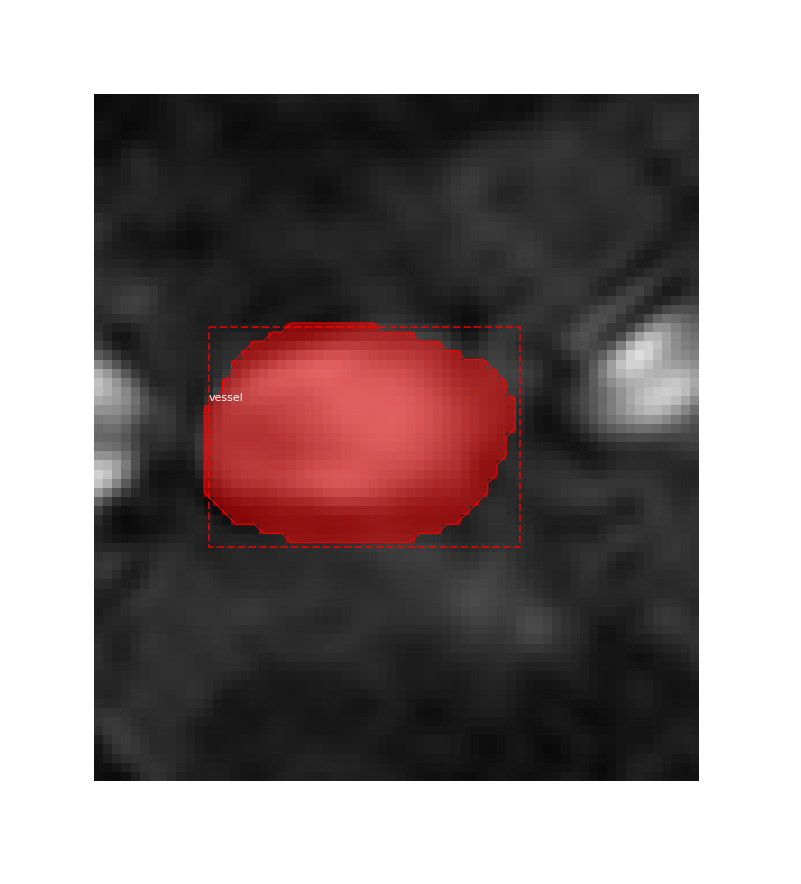

In [5]:
image_id = 216
image = train_set.load_image(image_id)
print(image.shape)
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)
bbox = extract_bboxes(mask)
display_instances(image, bbox, mask, class_ids, train_set.class_names)

In [28]:
# define a configuration for the model
class PlaqueConfig(Config):
    # define the name of the configuration
    NAME = "plaque_cfg"
    # number of classes (background + plaque)
    NUM_CLASSES = 1 + 1
    # number of training steps per epoch
    STEPS_PER_EPOCH = 700

In [29]:
config = PlaqueConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [30]:
model = MaskRCNN(mode='training', model_dir='./', config=config)
model.load_weights('mask_rcnn_coco.h5', by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [ ]:
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, epochs=5, layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./plaque_cfg20201031T2225\mask_rcnn_plaque_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Tim

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5


c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/700 [..............................] - ETA: 18:58:38 - loss: 6.8272 - rpn_class_loss: 0.0452 - rpn_bbox_loss: 1.9052 - mrcnn_class_loss: 1.9785 - mrcnn_bbox_loss: 2.2510 - mrcnn_mask_loss: 0.6472

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/700 [..............................] - ETA: 21:14:37 - loss: 6.9563 - rpn_class_loss: 0.0567 - rpn_bbox_loss: 2.5877 - mrcnn_class_loss: 1.5320 - mrcnn_bbox_loss: 2.1205 - mrcnn_mask_loss: 0.6594

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/700 [..............................] - ETA: 19:44:56 - loss: 5.6423 - rpn_class_loss: 0.0470 - rpn_bbox_loss: 1.9104 - mrcnn_class_loss: 1.0968 - mrcnn_bbox_loss: 1.8969 - mrcnn_mask_loss: 0.6913

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/700 [..............................] - ETA: 19:06:08 - loss: 5.1853 - rpn_class_loss: 0.0488 - rpn_bbox_loss: 1.7403 - mrcnn_class_loss: 0.8340 - mrcnn_bbox_loss: 1.8678 - mrcnn_mask_loss: 0.6944

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/700 [..............................] - ETA: 18:22:34 - loss: 4.6040 - rpn_class_loss: 0.0420 - rpn_bbox_loss: 1.4587 - mrcnn_class_loss: 0.6841 - mrcnn_bbox_loss: 1.7452 - mrcnn_mask_loss: 0.6740

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/700 [..............................] - ETA: 17:58:49 - loss: 4.4048 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 1.3140 - mrcnn_class_loss: 0.5849 - mrcnn_bbox_loss: 1.6985 - mrcnn_mask_loss: 0.7536

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/700 [..............................] - ETA: 18:11:10 - loss: 4.0560 - rpn_class_loss: 0.0542 - rpn_bbox_loss: 1.1577 - mrcnn_class_loss: 0.5090 - mrcnn_bbox_loss: 1.6038 - mrcnn_mask_loss: 0.7313

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/700 [..............................] - ETA: 18:17:43 - loss: 3.8195 - rpn_class_loss: 0.0582 - rpn_bbox_loss: 1.1033 - mrcnn_class_loss: 0.4575 - mrcnn_bbox_loss: 1.4924 - mrcnn_mask_loss: 0.7081

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/700 [..............................] - ETA: 18:14:31 - loss: 3.6996 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.1046 - mrcnn_class_loss: 0.4215 - mrcnn_bbox_loss: 1.4288 - mrcnn_mask_loss: 0.6885

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/700 [..............................] - ETA: 18:23:43 - loss: 3.6525 - rpn_class_loss: 0.0635 - rpn_bbox_loss: 1.1172 - mrcnn_class_loss: 0.3826 - mrcnn_bbox_loss: 1.4084 - mrcnn_mask_loss: 0.6809

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/700 [..............................] - ETA: 18:39:13 - loss: 3.5641 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 1.1036 - mrcnn_class_loss: 0.3584 - mrcnn_bbox_loss: 1.3697 - mrcnn_mask_loss: 0.6746

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/700 [..............................] - ETA: 18:28:19 - loss: 3.4502 - rpn_class_loss: 0.0559 - rpn_bbox_loss: 1.0415 - mrcnn_class_loss: 0.3322 - mrcnn_bbox_loss: 1.3494 - mrcnn_mask_loss: 0.6712

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/700 [..............................] - ETA: 18:42:51 - loss: 3.3625 - rpn_class_loss: 0.0560 - rpn_bbox_loss: 1.0087 - mrcnn_class_loss: 0.3173 - mrcnn_bbox_loss: 1.3188 - mrcnn_mask_loss: 0.6617

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/700 [..............................] - ETA: 18:52:10 - loss: 3.3151 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 1.0059 - mrcnn_class_loss: 0.3021 - mrcnn_bbox_loss: 1.2944 - mrcnn_mask_loss: 0.6565

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/700 [..............................] - ETA: 18:48:27 - loss: 3.2663 - rpn_class_loss: 0.0538 - rpn_bbox_loss: 1.0094 - mrcnn_class_loss: 0.2853 - mrcnn_bbox_loss: 1.2687 - mrcnn_mask_loss: 0.6491

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/700 [..............................] - ETA: 18:50:37 - loss: 3.2056 - rpn_class_loss: 0.0558 - rpn_bbox_loss: 0.9643 - mrcnn_class_loss: 0.2743 - mrcnn_bbox_loss: 1.2723 - mrcnn_mask_loss: 0.6389

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 17/700 [..............................] - ETA: 18:44:58 - loss: 3.1621 - rpn_class_loss: 0.0581 - rpn_bbox_loss: 0.9597 - mrcnn_class_loss: 0.2679 - mrcnn_bbox_loss: 1.2409 - mrcnn_mask_loss: 0.6355

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/700 [..............................] - ETA: 18:42:50 - loss: 3.0931 - rpn_class_loss: 0.0614 - rpn_bbox_loss: 0.9366 - mrcnn_class_loss: 0.2544 - mrcnn_bbox_loss: 1.1978 - mrcnn_mask_loss: 0.6429

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 19/700 [..............................] - ETA: 18:33:42 - loss: 3.0442 - rpn_class_loss: 0.0619 - rpn_bbox_loss: 0.9249 - mrcnn_class_loss: 0.2493 - mrcnn_bbox_loss: 1.1716 - mrcnn_mask_loss: 0.6366

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/700 [..............................] - ETA: 18:28:23 - loss: 3.0022 - rpn_class_loss: 0.0609 - rpn_bbox_loss: 0.9249 - mrcnn_class_loss: 0.2391 - mrcnn_bbox_loss: 1.1472 - mrcnn_mask_loss: 0.6301

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/700 [..............................] - ETA: 18:19:44 - loss: 3.0013 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 0.9452 - mrcnn_class_loss: 0.2333 - mrcnn_bbox_loss: 1.1307 - mrcnn_mask_loss: 0.6259

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/700 [..............................] - ETA: 18:20:16 - loss: 2.9731 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 0.9462 - mrcnn_class_loss: 0.2244 - mrcnn_bbox_loss: 1.1159 - mrcnn_mask_loss: 0.6217

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/700 [..............................] - ETA: 18:15:54 - loss: 2.9054 - rpn_class_loss: 0.0643 - rpn_bbox_loss: 0.9230 - mrcnn_class_loss: 0.2167 - mrcnn_bbox_loss: 1.0931 - mrcnn_mask_loss: 0.6082

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/700 [>.............................] - ETA: 18:10:08 - loss: 2.8685 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 0.9049 - mrcnn_class_loss: 0.2095 - mrcnn_bbox_loss: 1.0823 - mrcnn_mask_loss: 0.6055

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/700 [>.............................] - ETA: 18:03:10 - loss: 2.7988 - rpn_class_loss: 0.0667 - rpn_bbox_loss: 0.8794 - mrcnn_class_loss: 0.2026 - mrcnn_bbox_loss: 1.0554 - mrcnn_mask_loss: 0.5947

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/700 [>.............................] - ETA: 18:02:59 - loss: 2.7747 - rpn_class_loss: 0.0706 - rpn_bbox_loss: 0.8650 - mrcnn_class_loss: 0.2000 - mrcnn_bbox_loss: 1.0470 - mrcnn_mask_loss: 0.5922

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/700 [>.............................] - ETA: 17:55:48 - loss: 2.7307 - rpn_class_loss: 0.0689 - rpn_bbox_loss: 0.8400 - mrcnn_class_loss: 0.2007 - mrcnn_bbox_loss: 1.0338 - mrcnn_mask_loss: 0.5873

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/700 [>.............................] - ETA: 17:53:21 - loss: 2.6945 - rpn_class_loss: 0.0670 - rpn_bbox_loss: 0.8316 - mrcnn_class_loss: 0.1963 - mrcnn_bbox_loss: 1.0142 - mrcnn_mask_loss: 0.5854

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/700 [>.............................] - ETA: 17:49:42 - loss: 2.6701 - rpn_class_loss: 0.0681 - rpn_bbox_loss: 0.8254 - mrcnn_class_loss: 0.1922 - mrcnn_bbox_loss: 0.9922 - mrcnn_mask_loss: 0.5922

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/700 [>.............................] - ETA: 17:41:32 - loss: 2.6453 - rpn_class_loss: 0.0662 - rpn_bbox_loss: 0.8158 - mrcnn_class_loss: 0.1901 - mrcnn_bbox_loss: 0.9871 - mrcnn_mask_loss: 0.5862

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/700 [>.............................] - ETA: 17:44:15 - loss: 2.6193 - rpn_class_loss: 0.0650 - rpn_bbox_loss: 0.8096 - mrcnn_class_loss: 0.1874 - mrcnn_bbox_loss: 0.9740 - mrcnn_mask_loss: 0.5833

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/700 [>.............................] - ETA: 17:39:39 - loss: 2.5812 - rpn_class_loss: 0.0637 - rpn_bbox_loss: 0.7930 - mrcnn_class_loss: 0.1845 - mrcnn_bbox_loss: 0.9638 - mrcnn_mask_loss: 0.5762

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/700 [>.............................] - ETA: 17:32:05 - loss: 2.5590 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.7747 - mrcnn_class_loss: 0.1821 - mrcnn_bbox_loss: 0.9700 - mrcnn_mask_loss: 0.5705

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/700 [>.............................] - ETA: 17:26:00 - loss: 2.5357 - rpn_class_loss: 0.0618 - rpn_bbox_loss: 0.7647 - mrcnn_class_loss: 0.1800 - mrcnn_bbox_loss: 0.9621 - mrcnn_mask_loss: 0.5671

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/700 [>.............................] - ETA: 17:21:08 - loss: 2.5137 - rpn_class_loss: 0.0622 - rpn_bbox_loss: 0.7602 - mrcnn_class_loss: 0.1768 - mrcnn_bbox_loss: 0.9513 - mrcnn_mask_loss: 0.5631

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/700 [>.............................] - ETA: 17:21:31 - loss: 2.4767 - rpn_class_loss: 0.0611 - rpn_bbox_loss: 0.7426 - mrcnn_class_loss: 0.1738 - mrcnn_bbox_loss: 0.9413 - mrcnn_mask_loss: 0.5578

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/700 [>.............................] - ETA: 17:22:55 - loss: 2.4460 - rpn_class_loss: 0.0600 - rpn_bbox_loss: 0.7264 - mrcnn_class_loss: 0.1715 - mrcnn_bbox_loss: 0.9350 - mrcnn_mask_loss: 0.5530

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/700 [>.............................] - ETA: 17:27:50 - loss: 2.4165 - rpn_class_loss: 0.0585 - rpn_bbox_loss: 0.7209 - mrcnn_class_loss: 0.1685 - mrcnn_bbox_loss: 0.9187 - mrcnn_mask_loss: 0.5499

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/700 [>.............................] - ETA: 17:29:28 - loss: 2.3915 - rpn_class_loss: 0.0588 - rpn_bbox_loss: 0.7115 - mrcnn_class_loss: 0.1649 - mrcnn_bbox_loss: 0.9109 - mrcnn_mask_loss: 0.5453

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/700 [>.............................] - ETA: 17:31:16 - loss: 2.3653 - rpn_class_loss: 0.0579 - rpn_bbox_loss: 0.6982 - mrcnn_class_loss: 0.1615 - mrcnn_bbox_loss: 0.9056 - mrcnn_mask_loss: 0.5422

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/700 [>.............................] - ETA: 17:29:45 - loss: 2.3366 - rpn_class_loss: 0.0571 - rpn_bbox_loss: 0.6922 - mrcnn_class_loss: 0.1580 - mrcnn_bbox_loss: 0.8929 - mrcnn_mask_loss: 0.5364

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/700 [>.............................] - ETA: 17:28:35 - loss: 2.3071 - rpn_class_loss: 0.0563 - rpn_bbox_loss: 0.6829 - mrcnn_class_loss: 0.1557 - mrcnn_bbox_loss: 0.8804 - mrcnn_mask_loss: 0.5318

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/700 [>.............................] - ETA: 17:24:36 - loss: 2.3027 - rpn_class_loss: 0.0554 - rpn_bbox_loss: 0.6822 - mrcnn_class_loss: 0.1536 - mrcnn_bbox_loss: 0.8799 - mrcnn_mask_loss: 0.5316

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/700 [>.............................] - ETA: 17:22:31 - loss: 2.2848 - rpn_class_loss: 0.0552 - rpn_bbox_loss: 0.6760 - mrcnn_class_loss: 0.1508 - mrcnn_bbox_loss: 0.8734 - mrcnn_mask_loss: 0.5294

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/700 [>.............................] - ETA: 17:21:06 - loss: 2.2687 - rpn_class_loss: 0.0544 - rpn_bbox_loss: 0.6643 - mrcnn_class_loss: 0.1501 - mrcnn_bbox_loss: 0.8720 - mrcnn_mask_loss: 0.5280

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/700 [>.............................] - ETA: 17:17:11 - loss: 2.2553 - rpn_class_loss: 0.0540 - rpn_bbox_loss: 0.6586 - mrcnn_class_loss: 0.1486 - mrcnn_bbox_loss: 0.8676 - mrcnn_mask_loss: 0.5265

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/700 [=>............................] - ETA: 17:16:42 - loss: 2.2407 - rpn_class_loss: 0.0528 - rpn_bbox_loss: 0.6519 - mrcnn_class_loss: 0.1471 - mrcnn_bbox_loss: 0.8624 - mrcnn_mask_loss: 0.5263

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/700 [=>............................] - ETA: 17:20:05 - loss: 2.2543 - rpn_class_loss: 0.0537 - rpn_bbox_loss: 0.6560 - mrcnn_class_loss: 0.1450 - mrcnn_bbox_loss: 0.8710 - mrcnn_mask_loss: 0.5287

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/700 [=>............................] - ETA: 17:23:03 - loss: 2.2303 - rpn_class_loss: 0.0527 - rpn_bbox_loss: 0.6469 - mrcnn_class_loss: 0.1435 - mrcnn_bbox_loss: 0.8608 - mrcnn_mask_loss: 0.5265

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/700 [=>............................] - ETA: 17:17:24 - loss: 2.2050 - rpn_class_loss: 0.0517 - rpn_bbox_loss: 0.6390 - mrcnn_class_loss: 0.1416 - mrcnn_bbox_loss: 0.8511 - mrcnn_mask_loss: 0.5216

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/700 [=>............................] - ETA: 17:13:17 - loss: 2.1957 - rpn_class_loss: 0.0511 - rpn_bbox_loss: 0.6382 - mrcnn_class_loss: 0.1403 - mrcnn_bbox_loss: 0.8465 - mrcnn_mask_loss: 0.5195

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/700 [=>............................] - ETA: 17:11:29 - loss: 2.1776 - rpn_class_loss: 0.0502 - rpn_bbox_loss: 0.6313 - mrcnn_class_loss: 0.1390 - mrcnn_bbox_loss: 0.8404 - mrcnn_mask_loss: 0.5167

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/700 [=>............................] - ETA: 17:11:27 - loss: 2.1573 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.6239 - mrcnn_class_loss: 0.1372 - mrcnn_bbox_loss: 0.8347 - mrcnn_mask_loss: 0.5119

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/700 [=>............................] - ETA: 17:07:25 - loss: 2.1482 - rpn_class_loss: 0.0500 - rpn_bbox_loss: 0.6156 - mrcnn_class_loss: 0.1354 - mrcnn_bbox_loss: 0.8327 - mrcnn_mask_loss: 0.5145

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/700 [=>............................] - ETA: 17:05:59 - loss: 2.1356 - rpn_class_loss: 0.0494 - rpn_bbox_loss: 0.6126 - mrcnn_class_loss: 0.1335 - mrcnn_bbox_loss: 0.8268 - mrcnn_mask_loss: 0.5132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/700 [=>............................] - ETA: 17:01:33 - loss: 2.1214 - rpn_class_loss: 0.0496 - rpn_bbox_loss: 0.6049 - mrcnn_class_loss: 0.1328 - mrcnn_bbox_loss: 0.8211 - mrcnn_mask_loss: 0.5131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/700 [=>............................] - ETA: 17:05:40 - loss: 2.1055 - rpn_class_loss: 0.0490 - rpn_bbox_loss: 0.5991 - mrcnn_class_loss: 0.1313 - mrcnn_bbox_loss: 0.8156 - mrcnn_mask_loss: 0.5104

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 58/700 [=>............................] - ETA: 17:01:50 - loss: 2.0936 - rpn_class_loss: 0.0485 - rpn_bbox_loss: 0.5941 - mrcnn_class_loss: 0.1308 - mrcnn_bbox_loss: 0.8108 - mrcnn_mask_loss: 0.5093

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/700 [=>............................] - ETA: 16:58:32 - loss: 2.0811 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.5895 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.8055 - mrcnn_mask_loss: 0.5087

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 60/700 [=>............................] - ETA: 17:01:51 - loss: 2.0778 - rpn_class_loss: 0.0481 - rpn_bbox_loss: 0.5897 - mrcnn_class_loss: 0.1291 - mrcnn_bbox_loss: 0.8006 - mrcnn_mask_loss: 0.5104

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/700 [=>............................] - ETA: 17:01:53 - loss: 2.0643 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.5859 - mrcnn_class_loss: 0.1277 - mrcnn_bbox_loss: 0.7954 - mrcnn_mask_loss: 0.5080

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/700 [=>............................] - ETA: 17:03:41 - loss: 2.0536 - rpn_class_loss: 0.0478 - rpn_bbox_loss: 0.5823 - mrcnn_class_loss: 0.1260 - mrcnn_bbox_loss: 0.7923 - mrcnn_mask_loss: 0.5052

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/700 [=>............................] - ETA: 16:57:47 - loss: 2.0409 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.5786 - mrcnn_class_loss: 0.1245 - mrcnn_bbox_loss: 0.7869 - mrcnn_mask_loss: 0.5033

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/700 [=>............................] - ETA: 16:56:19 - loss: 2.0295 - rpn_class_loss: 0.0471 - rpn_bbox_loss: 0.5735 - mrcnn_class_loss: 0.1232 - mrcnn_bbox_loss: 0.7832 - mrcnn_mask_loss: 0.5025

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/700 [=>............................] - ETA: 16:53:12 - loss: 2.0186 - rpn_class_loss: 0.0468 - rpn_bbox_loss: 0.5697 - mrcnn_class_loss: 0.1219 - mrcnn_bbox_loss: 0.7803 - mrcnn_mask_loss: 0.4999

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/700 [=>............................] - ETA: 16:49:28 - loss: 2.0112 - rpn_class_loss: 0.0477 - rpn_bbox_loss: 0.5704 - mrcnn_class_loss: 0.1205 - mrcnn_bbox_loss: 0.7726 - mrcnn_mask_loss: 0.4999

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/700 [=>............................] - ETA: 16:49:16 - loss: 1.9985 - rpn_class_loss: 0.0472 - rpn_bbox_loss: 0.5648 - mrcnn_class_loss: 0.1195 - mrcnn_bbox_loss: 0.7683 - mrcnn_mask_loss: 0.4987

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/700 [=>............................] - ETA: 16:44:38 - loss: 1.9871 - rpn_class_loss: 0.0473 - rpn_bbox_loss: 0.5615 - mrcnn_class_loss: 0.1182 - mrcnn_bbox_loss: 0.7641 - mrcnn_mask_loss: 0.4960

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/700 [=>............................] - ETA: 16:43:21 - loss: 1.9733 - rpn_class_loss: 0.0469 - rpn_bbox_loss: 0.5573 - mrcnn_class_loss: 0.1170 - mrcnn_bbox_loss: 0.7586 - mrcnn_mask_loss: 0.4935

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/700 [==>...........................] - ETA: 16:43:14 - loss: 1.9553 - rpn_class_loss: 0.0463 - rpn_bbox_loss: 0.5511 - mrcnn_class_loss: 0.1158 - mrcnn_bbox_loss: 0.7507 - mrcnn_mask_loss: 0.4914

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/700 [==>...........................] - ETA: 16:42:43 - loss: 1.9448 - rpn_class_loss: 0.0457 - rpn_bbox_loss: 0.5492 - mrcnn_class_loss: 0.1150 - mrcnn_bbox_loss: 0.7441 - mrcnn_mask_loss: 0.4908

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/700 [==>...........................] - ETA: 16:40:09 - loss: 1.9360 - rpn_class_loss: 0.0456 - rpn_bbox_loss: 0.5455 - mrcnn_class_loss: 0.1144 - mrcnn_bbox_loss: 0.7403 - mrcnn_mask_loss: 0.4901

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/700 [==>...........................] - ETA: 16:36:56 - loss: 1.9253 - rpn_class_loss: 0.0451 - rpn_bbox_loss: 0.5414 - mrcnn_class_loss: 0.1135 - mrcnn_bbox_loss: 0.7364 - mrcnn_mask_loss: 0.4888

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/700 [==>...........................] - ETA: 16:34:09 - loss: 1.9168 - rpn_class_loss: 0.0448 - rpn_bbox_loss: 0.5363 - mrcnn_class_loss: 0.1127 - mrcnn_bbox_loss: 0.7361 - mrcnn_mask_loss: 0.4869

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/700 [==>...........................] - ETA: 16:33:52 - loss: 1.9098 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.5355 - mrcnn_class_loss: 0.1119 - mrcnn_bbox_loss: 0.7320 - mrcnn_mask_loss: 0.4858

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/700 [==>...........................] - ETA: 16:31:27 - loss: 1.8946 - rpn_class_loss: 0.0446 - rpn_bbox_loss: 0.5314 - mrcnn_class_loss: 0.1105 - mrcnn_bbox_loss: 0.7258 - mrcnn_mask_loss: 0.4823

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/700 [==>...........................] - ETA: 16:27:45 - loss: 1.8875 - rpn_class_loss: 0.0441 - rpn_bbox_loss: 0.5295 - mrcnn_class_loss: 0.1097 - mrcnn_bbox_loss: 0.7227 - mrcnn_mask_loss: 0.4815

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/700 [==>...........................] - ETA: 16:27:09 - loss: 1.8774 - rpn_class_loss: 0.0437 - rpn_bbox_loss: 0.5245 - mrcnn_class_loss: 0.1088 - mrcnn_bbox_loss: 0.7203 - mrcnn_mask_loss: 0.4802

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/700 [==>...........................] - ETA: 16:25:29 - loss: 1.8687 - rpn_class_loss: 0.0433 - rpn_bbox_loss: 0.5221 - mrcnn_class_loss: 0.1082 - mrcnn_bbox_loss: 0.7165 - mrcnn_mask_loss: 0.4787

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/700 [==>...........................] - ETA: 16:22:41 - loss: 1.8548 - rpn_class_loss: 0.0428 - rpn_bbox_loss: 0.5177 - mrcnn_class_loss: 0.1073 - mrcnn_bbox_loss: 0.7112 - mrcnn_mask_loss: 0.4758

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/700 [==>...........................] - ETA: 16:21:08 - loss: 1.8443 - rpn_class_loss: 0.0425 - rpn_bbox_loss: 0.5142 - mrcnn_class_loss: 0.1068 - mrcnn_bbox_loss: 0.7068 - mrcnn_mask_loss: 0.4740

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/700 [==>...........................] - ETA: 16:19:46 - loss: 1.8368 - rpn_class_loss: 0.0423 - rpn_bbox_loss: 0.5131 - mrcnn_class_loss: 0.1065 - mrcnn_bbox_loss: 0.7028 - mrcnn_mask_loss: 0.4722

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/700 [==>...........................] - ETA: 16:16:44 - loss: 1.8272 - rpn_class_loss: 0.0418 - rpn_bbox_loss: 0.5099 - mrcnn_class_loss: 0.1058 - mrcnn_bbox_loss: 0.6989 - mrcnn_mask_loss: 0.4707

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/700 [==>...........................] - ETA: 16:16:15 - loss: 1.8150 - rpn_class_loss: 0.0414 - rpn_bbox_loss: 0.5046 - mrcnn_class_loss: 0.1049 - mrcnn_bbox_loss: 0.6951 - mrcnn_mask_loss: 0.4690

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/700 [==>...........................] - ETA: 16:13:05 - loss: 1.8027 - rpn_class_loss: 0.0411 - rpn_bbox_loss: 0.4993 - mrcnn_class_loss: 0.1041 - mrcnn_bbox_loss: 0.6911 - mrcnn_mask_loss: 0.4671

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/700 [==>...........................] - ETA: 16:11:55 - loss: 1.7918 - rpn_class_loss: 0.0407 - rpn_bbox_loss: 0.4953 - mrcnn_class_loss: 0.1035 - mrcnn_bbox_loss: 0.6861 - mrcnn_mask_loss: 0.4662

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/700 [==>...........................] - ETA: 16:14:54 - loss: 1.7834 - rpn_class_loss: 0.0402 - rpn_bbox_loss: 0.4944 - mrcnn_class_loss: 0.1028 - mrcnn_bbox_loss: 0.6811 - mrcnn_mask_loss: 0.4649

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/700 [==>...........................] - ETA: 16:11:45 - loss: 1.7695 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.4894 - mrcnn_class_loss: 0.1020 - mrcnn_bbox_loss: 0.6754 - mrcnn_mask_loss: 0.4629

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/700 [==>...........................] - ETA: 16:11:35 - loss: 1.7575 - rpn_class_loss: 0.0398 - rpn_bbox_loss: 0.4854 - mrcnn_class_loss: 0.1011 - mrcnn_bbox_loss: 0.6705 - mrcnn_mask_loss: 0.4608

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/700 [==>...........................] - ETA: 16:10:28 - loss: 1.7511 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 0.4823 - mrcnn_class_loss: 0.1012 - mrcnn_bbox_loss: 0.6682 - mrcnn_mask_loss: 0.4599

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/700 [==>...........................] - ETA: 16:06:44 - loss: 1.7416 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.4785 - mrcnn_class_loss: 0.1006 - mrcnn_bbox_loss: 0.6641 - mrcnn_mask_loss: 0.4591

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/700 [==>...........................] - ETA: 16:04:31 - loss: 1.7375 - rpn_class_loss: 0.0393 - rpn_bbox_loss: 0.4781 - mrcnn_class_loss: 0.0998 - mrcnn_bbox_loss: 0.6624 - mrcnn_mask_loss: 0.4579

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/700 [==>...........................] - ETA: 16:06:06 - loss: 1.7318 - rpn_class_loss: 0.0391 - rpn_bbox_loss: 0.4763 - mrcnn_class_loss: 0.0993 - mrcnn_bbox_loss: 0.6594 - mrcnn_mask_loss: 0.4577

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/700 [===>..........................] - ETA: 16:06:05 - loss: 1.7212 - rpn_class_loss: 0.0387 - rpn_bbox_loss: 0.4730 - mrcnn_class_loss: 0.0984 - mrcnn_bbox_loss: 0.6551 - mrcnn_mask_loss: 0.4559

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/700 [===>..........................] - ETA: 16:03:15 - loss: 1.7174 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.4716 - mrcnn_class_loss: 0.0983 - mrcnn_bbox_loss: 0.6529 - mrcnn_mask_loss: 0.4561

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/700 [===>..........................] - ETA: 16:01:41 - loss: 1.7120 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.4720 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.6490 - mrcnn_mask_loss: 0.4549

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 97/700 [===>..........................] - ETA: 15:59:06 - loss: 1.7065 - rpn_class_loss: 0.0386 - rpn_bbox_loss: 0.4703 - mrcnn_class_loss: 0.0977 - mrcnn_bbox_loss: 0.6456 - mrcnn_mask_loss: 0.4543

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/700 [===>..........................] - ETA: 15:55:40 - loss: 1.6970 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 0.4674 - mrcnn_class_loss: 0.0971 - mrcnn_bbox_loss: 0.6413 - mrcnn_mask_loss: 0.4529

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/700 [===>..........................] - ETA: 15:53:14 - loss: 1.6884 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.4632 - mrcnn_class_loss: 0.0967 - mrcnn_bbox_loss: 0.6379 - mrcnn_mask_loss: 0.4525

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/700 [===>..........................] - ETA: 15:52:53 - loss: 1.6805 - rpn_class_loss: 0.0380 - rpn_bbox_loss: 0.4599 - mrcnn_class_loss: 0.0964 - mrcnn_bbox_loss: 0.6343 - mrcnn_mask_loss: 0.4519

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/700 [===>..........................] - ETA: 15:50:57 - loss: 1.6759 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.4586 - mrcnn_class_loss: 0.0961 - mrcnn_bbox_loss: 0.6320 - mrcnn_mask_loss: 0.4515

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/700 [===>..........................] - ETA: 15:48:10 - loss: 1.6790 - rpn_class_loss: 0.0385 - rpn_bbox_loss: 0.4575 - mrcnn_class_loss: 0.0952 - mrcnn_bbox_loss: 0.6350 - mrcnn_mask_loss: 0.4527

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/700 [===>..........................] - ETA: 15:46:56 - loss: 1.6703 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 0.4548 - mrcnn_class_loss: 0.0947 - mrcnn_bbox_loss: 0.6313 - mrcnn_mask_loss: 0.4513

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/700 [===>..........................] - ETA: 15:44:29 - loss: 1.6671 - rpn_class_loss: 0.0379 - rpn_bbox_loss: 0.4525 - mrcnn_class_loss: 0.0943 - mrcnn_bbox_loss: 0.6308 - mrcnn_mask_loss: 0.4515

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

105/700 [===>..........................] - ETA: 15:43:02 - loss: 1.6604 - rpn_class_loss: 0.0378 - rpn_bbox_loss: 0.4506 - mrcnn_class_loss: 0.0937 - mrcnn_bbox_loss: 0.6280 - mrcnn_mask_loss: 0.4503

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/700 [===>..........................] - ETA: 15:39:37 - loss: 1.6548 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 0.4493 - mrcnn_class_loss: 0.0935 - mrcnn_bbox_loss: 0.6252 - mrcnn_mask_loss: 0.4494

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/700 [===>..........................] - ETA: 15:37:19 - loss: 1.6455 - rpn_class_loss: 0.0373 - rpn_bbox_loss: 0.4462 - mrcnn_class_loss: 0.0929 - mrcnn_bbox_loss: 0.6215 - mrcnn_mask_loss: 0.4476

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/700 [===>..........................] - ETA: 15:38:54 - loss: 1.6363 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.4434 - mrcnn_class_loss: 0.0923 - mrcnn_bbox_loss: 0.6177 - mrcnn_mask_loss: 0.4459

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/700 [===>..........................] - ETA: 15:36:05 - loss: 1.6339 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.4418 - mrcnn_class_loss: 0.0920 - mrcnn_bbox_loss: 0.6170 - mrcnn_mask_loss: 0.4460

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/700 [===>..........................] - ETA: 15:33:06 - loss: 1.6266 - rpn_class_loss: 0.0372 - rpn_bbox_loss: 0.4399 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.6135 - mrcnn_mask_loss: 0.4446

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/700 [===>..........................] - ETA: 15:33:53 - loss: 1.6224 - rpn_class_loss: 0.0370 - rpn_bbox_loss: 0.4385 - mrcnn_class_loss: 0.0908 - mrcnn_bbox_loss: 0.6121 - mrcnn_mask_loss: 0.4439

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/700 [===>..........................] - ETA: 15:31:03 - loss: 1.6234 - rpn_class_loss: 0.0367 - rpn_bbox_loss: 0.4391 - mrcnn_class_loss: 0.0903 - mrcnn_bbox_loss: 0.6134 - mrcnn_mask_loss: 0.4440

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/700 [===>..........................] - ETA: 15:28:35 - loss: 1.6160 - rpn_class_loss: 0.0364 - rpn_bbox_loss: 0.4369 - mrcnn_class_loss: 0.0899 - mrcnn_bbox_loss: 0.6100 - mrcnn_mask_loss: 0.4428

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/700 [===>..........................] - ETA: 15:25:49 - loss: 1.6114 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.4349 - mrcnn_class_loss: 0.0894 - mrcnn_bbox_loss: 0.6085 - mrcnn_mask_loss: 0.4424

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/700 [===>..........................] - ETA: 15:23:29 - loss: 1.6146 - rpn_class_loss: 0.0362 - rpn_bbox_loss: 0.4365 - mrcnn_class_loss: 0.0889 - mrcnn_bbox_loss: 0.6108 - mrcnn_mask_loss: 0.4422

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/700 [===>..........................] - ETA: 15:23:34 - loss: 1.6106 - rpn_class_loss: 0.0359 - rpn_bbox_loss: 0.4352 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.6090 - mrcnn_mask_loss: 0.4420

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/700 [====>.........................] - ETA: 15:23:33 - loss: 1.6052 - rpn_class_loss: 0.0357 - rpn_bbox_loss: 0.4323 - mrcnn_class_loss: 0.0881 - mrcnn_bbox_loss: 0.6082 - mrcnn_mask_loss: 0.4408

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/700 [====>.........................] - ETA: 15:21:38 - loss: 1.6016 - rpn_class_loss: 0.0355 - rpn_bbox_loss: 0.4321 - mrcnn_class_loss: 0.0877 - mrcnn_bbox_loss: 0.6059 - mrcnn_mask_loss: 0.4403

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/700 [====>.........................] - ETA: 15:19:24 - loss: 1.5971 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.4302 - mrcnn_class_loss: 0.0875 - mrcnn_bbox_loss: 0.6052 - mrcnn_mask_loss: 0.4389

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/700 [====>.........................] - ETA: 15:16:59 - loss: 1.5892 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.4269 - mrcnn_class_loss: 0.0869 - mrcnn_bbox_loss: 0.6025 - mrcnn_mask_loss: 0.4378

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/700 [====>.........................] - ETA: 15:17:34 - loss: 1.5854 - rpn_class_loss: 0.0353 - rpn_bbox_loss: 0.4251 - mrcnn_class_loss: 0.0867 - mrcnn_bbox_loss: 0.6002 - mrcnn_mask_loss: 0.4381

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/700 [====>.........................] - ETA: 15:15:28 - loss: 1.5778 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.4232 - mrcnn_class_loss: 0.0862 - mrcnn_bbox_loss: 0.5966 - mrcnn_mask_loss: 0.4368

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/700 [====>.........................] - ETA: 15:13:24 - loss: 1.5723 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.4218 - mrcnn_class_loss: 0.0856 - mrcnn_bbox_loss: 0.5944 - mrcnn_mask_loss: 0.4356

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/700 [====>.........................] - ETA: 15:12:01 - loss: 1.5658 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 0.4194 - mrcnn_class_loss: 0.0852 - mrcnn_bbox_loss: 0.5921 - mrcnn_mask_loss: 0.4344

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/700 [====>.........................] - ETA: 15:10:10 - loss: 1.5605 - rpn_class_loss: 0.0344 - rpn_bbox_loss: 0.4177 - mrcnn_class_loss: 0.0848 - mrcnn_bbox_loss: 0.5896 - mrcnn_mask_loss: 0.4339

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/700 [====>.........................] - ETA: 15:09:32 - loss: 1.5623 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.4165 - mrcnn_class_loss: 0.0845 - mrcnn_bbox_loss: 0.5927 - mrcnn_mask_loss: 0.4342

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/700 [====>.........................] - ETA: 15:08:17 - loss: 1.5570 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 0.4147 - mrcnn_class_loss: 0.0844 - mrcnn_bbox_loss: 0.5908 - mrcnn_mask_loss: 0.4329

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/700 [====>.........................] - ETA: 15:05:52 - loss: 1.5503 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.4128 - mrcnn_class_loss: 0.0839 - mrcnn_bbox_loss: 0.5879 - mrcnn_mask_loss: 0.4317

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/700 [====>.........................] - ETA: 15:03:18 - loss: 1.5441 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.4108 - mrcnn_class_loss: 0.0835 - mrcnn_bbox_loss: 0.5852 - mrcnn_mask_loss: 0.4308

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/700 [====>.........................] - ETA: 15:03:15 - loss: 1.5374 - rpn_class_loss: 0.0336 - rpn_bbox_loss: 0.4080 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.5823 - mrcnn_mask_loss: 0.4304

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/700 [====>.........................] - ETA: 15:00:41 - loss: 1.5362 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.4070 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.5828 - mrcnn_mask_loss: 0.4303

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/700 [====>.........................] - ETA: 14:58:23 - loss: 1.5330 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.4054 - mrcnn_class_loss: 0.0825 - mrcnn_bbox_loss: 0.5820 - mrcnn_mask_loss: 0.4297

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/700 [====>.........................] - ETA: 14:56:28 - loss: 1.5264 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.4034 - mrcnn_class_loss: 0.0821 - mrcnn_bbox_loss: 0.5796 - mrcnn_mask_loss: 0.4281

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/700 [====>.........................] - ETA: 14:57:12 - loss: 1.5206 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.4018 - mrcnn_class_loss: 0.0817 - mrcnn_bbox_loss: 0.5766 - mrcnn_mask_loss: 0.4273

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/700 [====>.........................] - ETA: 14:54:53 - loss: 1.5146 - rpn_class_loss: 0.0330 - rpn_bbox_loss: 0.4000 - mrcnn_class_loss: 0.0813 - mrcnn_bbox_loss: 0.5743 - mrcnn_mask_loss: 0.4260

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/700 [====>.........................] - ETA: 14:51:55 - loss: 1.5098 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.3981 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.5725 - mrcnn_mask_loss: 0.4254

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/700 [====>.........................] - ETA: 14:49:52 - loss: 1.5055 - rpn_class_loss: 0.0327 - rpn_bbox_loss: 0.3962 - mrcnn_class_loss: 0.0807 - mrcnn_bbox_loss: 0.5712 - mrcnn_mask_loss: 0.4247

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/700 [====>.........................] - ETA: 14:49:11 - loss: 1.5012 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.3946 - mrcnn_class_loss: 0.0804 - mrcnn_bbox_loss: 0.5695 - mrcnn_mask_loss: 0.4243

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/700 [====>.........................] - ETA: 14:46:19 - loss: 1.4964 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.3927 - mrcnn_class_loss: 0.0800 - mrcnn_bbox_loss: 0.5677 - mrcnn_mask_loss: 0.4237

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/700 [=====>........................] - ETA: 14:43:44 - loss: 1.4895 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.3906 - mrcnn_class_loss: 0.0795 - mrcnn_bbox_loss: 0.5649 - mrcnn_mask_loss: 0.4223

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/700 [=====>........................] - ETA: 14:44:31 - loss: 1.4853 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.3898 - mrcnn_class_loss: 0.0792 - mrcnn_bbox_loss: 0.5625 - mrcnn_mask_loss: 0.4217

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/700 [=====>........................] - ETA: 14:42:15 - loss: 1.4840 - rpn_class_loss: 0.0321 - rpn_bbox_loss: 0.3893 - mrcnn_class_loss: 0.0790 - mrcnn_bbox_loss: 0.5614 - mrcnn_mask_loss: 0.4223

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/700 [=====>........................] - ETA: 14:39:48 - loss: 1.4793 - rpn_class_loss: 0.0319 - rpn_bbox_loss: 0.3885 - mrcnn_class_loss: 0.0786 - mrcnn_bbox_loss: 0.5591 - mrcnn_mask_loss: 0.4211

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/700 [=====>........................] - ETA: 14:37:16 - loss: 1.4756 - rpn_class_loss: 0.0320 - rpn_bbox_loss: 0.3870 - mrcnn_class_loss: 0.0783 - mrcnn_bbox_loss: 0.5577 - mrcnn_mask_loss: 0.4206

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/700 [=====>........................] - ETA: 14:36:35 - loss: 1.4716 - rpn_class_loss: 0.0318 - rpn_bbox_loss: 0.3853 - mrcnn_class_loss: 0.0780 - mrcnn_bbox_loss: 0.5564 - mrcnn_mask_loss: 0.4201

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/700 [=====>........................] - ETA: 14:38:30 - loss: 1.4678 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.3847 - mrcnn_class_loss: 0.0778 - mrcnn_bbox_loss: 0.5541 - mrcnn_mask_loss: 0.4196

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/700 [=====>........................] - ETA: 14:36:01 - loss: 1.4643 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.3837 - mrcnn_class_loss: 0.0774 - mrcnn_bbox_loss: 0.5529 - mrcnn_mask_loss: 0.4186

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

148/700 [=====>........................] - ETA: 14:34:10 - loss: 1.4630 - rpn_class_loss: 0.0316 - rpn_bbox_loss: 0.3849 - mrcnn_class_loss: 0.0771 - mrcnn_bbox_loss: 0.5519 - mrcnn_mask_loss: 0.4177

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/700 [=====>........................] - ETA: 14:31:53 - loss: 1.4615 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.3838 - mrcnn_class_loss: 0.0770 - mrcnn_bbox_loss: 0.5518 - mrcnn_mask_loss: 0.4175

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/700 [=====>........................] - ETA: 14:29:57 - loss: 1.4567 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.3826 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.5495 - mrcnn_mask_loss: 0.4167

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

151/700 [=====>........................] - ETA: 14:27:28 - loss: 1.4532 - rpn_class_loss: 0.0314 - rpn_bbox_loss: 0.3812 - mrcnn_class_loss: 0.0767 - mrcnn_bbox_loss: 0.5478 - mrcnn_mask_loss: 0.4160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/700 [=====>........................] - ETA: 14:26:50 - loss: 1.4487 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.3793 - mrcnn_class_loss: 0.0766 - mrcnn_bbox_loss: 0.5457 - mrcnn_mask_loss: 0.4159

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/700 [=====>........................] - ETA: 14:24:58 - loss: 1.4462 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.3784 - mrcnn_class_loss: 0.0764 - mrcnn_bbox_loss: 0.5443 - mrcnn_mask_loss: 0.4160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/700 [=====>........................] - ETA: 14:22:52 - loss: 1.4425 - rpn_class_loss: 0.0310 - rpn_bbox_loss: 0.3771 - mrcnn_class_loss: 0.0762 - mrcnn_bbox_loss: 0.5431 - mrcnn_mask_loss: 0.4151

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/700 [=====>........................] - ETA: 14:20:02 - loss: 1.4372 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.3755 - mrcnn_class_loss: 0.0759 - mrcnn_bbox_loss: 0.5410 - mrcnn_mask_loss: 0.4140

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/700 [=====>........................] - ETA: 14:17:44 - loss: 1.4333 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.3740 - mrcnn_class_loss: 0.0756 - mrcnn_bbox_loss: 0.5399 - mrcnn_mask_loss: 0.4132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/700 [=====>........................] - ETA: 14:17:10 - loss: 1.4296 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.3726 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.5385 - mrcnn_mask_loss: 0.4127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/700 [=====>........................] - ETA: 14:16:17 - loss: 1.4245 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.3706 - mrcnn_class_loss: 0.0749 - mrcnn_bbox_loss: 0.5363 - mrcnn_mask_loss: 0.4123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/700 [=====>........................] - ETA: 14:15:19 - loss: 1.4256 - rpn_class_loss: 0.0303 - rpn_bbox_loss: 0.3744 - mrcnn_class_loss: 0.0746 - mrcnn_bbox_loss: 0.5343 - mrcnn_mask_loss: 0.4120

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/700 [=====>........................] - ETA: 14:13:17 - loss: 1.4235 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.3741 - mrcnn_class_loss: 0.0744 - mrcnn_bbox_loss: 0.5334 - mrcnn_mask_loss: 0.4114

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/700 [=====>........................] - ETA: 14:12:45 - loss: 1.4191 - rpn_class_loss: 0.0300 - rpn_bbox_loss: 0.3729 - mrcnn_class_loss: 0.0742 - mrcnn_bbox_loss: 0.5311 - mrcnn_mask_loss: 0.4108

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/700 [=====>........................] - ETA: 14:10:45 - loss: 1.4158 - rpn_class_loss: 0.0299 - rpn_bbox_loss: 0.3712 - mrcnn_class_loss: 0.0741 - mrcnn_bbox_loss: 0.5298 - mrcnn_mask_loss: 0.4108

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/700 [=====>........................] - ETA: 14:08:48 - loss: 1.4126 - rpn_class_loss: 0.0298 - rpn_bbox_loss: 0.3694 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.5287 - mrcnn_mask_loss: 0.4108

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/700 [======>.......................] - ETA: 14:06:53 - loss: 1.4089 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.3682 - mrcnn_class_loss: 0.0736 - mrcnn_bbox_loss: 0.5272 - mrcnn_mask_loss: 0.4103

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/700 [======>.......................] - ETA: 14:06:36 - loss: 1.4062 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.3672 - mrcnn_class_loss: 0.0733 - mrcnn_bbox_loss: 0.5261 - mrcnn_mask_loss: 0.4099

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/700 [======>.......................] - ETA: 14:04:24 - loss: 1.4028 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.3660 - mrcnn_class_loss: 0.0731 - mrcnn_bbox_loss: 0.5250 - mrcnn_mask_loss: 0.4091

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

167/700 [======>.......................] - ETA: 14:02:38 - loss: 1.4033 - rpn_class_loss: 0.0297 - rpn_bbox_loss: 0.3652 - mrcnn_class_loss: 0.0732 - mrcnn_bbox_loss: 0.5256 - mrcnn_mask_loss: 0.4096

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/700 [======>.......................] - ETA: 14:00:44 - loss: 1.4002 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.3642 - mrcnn_class_loss: 0.0729 - mrcnn_bbox_loss: 0.5246 - mrcnn_mask_loss: 0.4089

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

169/700 [======>.......................] - ETA: 14:00:42 - loss: 1.3963 - rpn_class_loss: 0.0296 - rpn_bbox_loss: 0.3628 - mrcnn_class_loss: 0.0726 - mrcnn_bbox_loss: 0.5229 - mrcnn_mask_loss: 0.4085

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/700 [======>.......................] - ETA: 13:58:17 - loss: 1.3940 - rpn_class_loss: 0.0295 - rpn_bbox_loss: 0.3616 - mrcnn_class_loss: 0.0725 - mrcnn_bbox_loss: 0.5222 - mrcnn_mask_loss: 0.4083

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/700 [======>.......................] - ETA: 13:56:43 - loss: 1.3912 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 0.3605 - mrcnn_class_loss: 0.0722 - mrcnn_bbox_loss: 0.5213 - mrcnn_mask_loss: 0.4079

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/700 [======>.......................] - ETA: 13:56:37 - loss: 1.3887 - rpn_class_loss: 0.0292 - rpn_bbox_loss: 0.3602 - mrcnn_class_loss: 0.0720 - mrcnn_bbox_loss: 0.5201 - mrcnn_mask_loss: 0.4073

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/700 [======>.......................] - ETA: 13:55:45 - loss: 1.3839 - rpn_class_loss: 0.0290 - rpn_bbox_loss: 0.3585 - mrcnn_class_loss: 0.0717 - mrcnn_bbox_loss: 0.5180 - mrcnn_mask_loss: 0.4066

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/700 [======>.......................] - ETA: 13:54:12 - loss: 1.3802 - rpn_class_loss: 0.0289 - rpn_bbox_loss: 0.3571 - mrcnn_class_loss: 0.0715 - mrcnn_bbox_loss: 0.5165 - mrcnn_mask_loss: 0.4061

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/700 [======>.......................] - ETA: 13:52:13 - loss: 1.3754 - rpn_class_loss: 0.0288 - rpn_bbox_loss: 0.3557 - mrcnn_class_loss: 0.0713 - mrcnn_bbox_loss: 0.5146 - mrcnn_mask_loss: 0.4050

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/700 [======>.......................] - ETA: 13:50:31 - loss: 1.3707 - rpn_class_loss: 0.0287 - rpn_bbox_loss: 0.3543 - mrcnn_class_loss: 0.0711 - mrcnn_bbox_loss: 0.5127 - mrcnn_mask_loss: 0.4040

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/700 [======>.......................] - ETA: 13:48:26 - loss: 1.3692 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.3543 - mrcnn_class_loss: 0.0710 - mrcnn_bbox_loss: 0.5119 - mrcnn_mask_loss: 0.4034

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/700 [======>.......................] - ETA: 13:46:21 - loss: 1.3679 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.3538 - mrcnn_class_loss: 0.0708 - mrcnn_bbox_loss: 0.5113 - mrcnn_mask_loss: 0.4034

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/700 [======>.......................] - ETA: 13:44:30 - loss: 1.3649 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.3526 - mrcnn_class_loss: 0.0705 - mrcnn_bbox_loss: 0.5103 - mrcnn_mask_loss: 0.4029

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/700 [======>.......................] - ETA: 13:45:28 - loss: 1.3613 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.3517 - mrcnn_class_loss: 0.0703 - mrcnn_bbox_loss: 0.5082 - mrcnn_mask_loss: 0.4025

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/700 [======>.......................] - ETA: 13:44:33 - loss: 1.3577 - rpn_class_loss: 0.0286 - rpn_bbox_loss: 0.3506 - mrcnn_class_loss: 0.0701 - mrcnn_bbox_loss: 0.5068 - mrcnn_mask_loss: 0.4016

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/700 [======>.......................] - ETA: 13:42:44 - loss: 1.3546 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.3507 - mrcnn_class_loss: 0.0698 - mrcnn_bbox_loss: 0.5052 - mrcnn_mask_loss: 0.4005

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/700 [======>.......................] - ETA: 13:40:30 - loss: 1.3505 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.3493 - mrcnn_class_loss: 0.0696 - mrcnn_bbox_loss: 0.5032 - mrcnn_mask_loss: 0.3999

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/700 [======>.......................] - ETA: 13:38:03 - loss: 1.3469 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.3482 - mrcnn_class_loss: 0.0695 - mrcnn_bbox_loss: 0.5015 - mrcnn_mask_loss: 0.3994

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/700 [======>.......................] - ETA: 13:37:38 - loss: 1.3447 - rpn_class_loss: 0.0284 - rpn_bbox_loss: 0.3474 - mrcnn_class_loss: 0.0694 - mrcnn_bbox_loss: 0.5005 - mrcnn_mask_loss: 0.3990

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/700 [======>.......................] - ETA: 13:36:00 - loss: 1.3408 - rpn_class_loss: 0.0283 - rpn_bbox_loss: 0.3461 - mrcnn_class_loss: 0.0693 - mrcnn_bbox_loss: 0.4986 - mrcnn_mask_loss: 0.3984

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/700 [=======>......................] - ETA: 13:33:41 - loss: 1.3381 - rpn_class_loss: 0.0282 - rpn_bbox_loss: 0.3455 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.4972 - mrcnn_mask_loss: 0.3981

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/700 [=======>......................] - ETA: 13:31:45 - loss: 1.3350 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.3444 - mrcnn_class_loss: 0.0692 - mrcnn_bbox_loss: 0.4956 - mrcnn_mask_loss: 0.3977

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/700 [=======>......................] - ETA: 13:29:28 - loss: 1.3317 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.3440 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.4938 - mrcnn_mask_loss: 0.3970

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/700 [=======>......................] - ETA: 13:27:30 - loss: 1.3298 - rpn_class_loss: 0.0280 - rpn_bbox_loss: 0.3430 - mrcnn_class_loss: 0.0687 - mrcnn_bbox_loss: 0.4929 - mrcnn_mask_loss: 0.3971

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/700 [=======>......................] - ETA: 13:26:22 - loss: 1.3263 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.3429 - mrcnn_class_loss: 0.0685 - mrcnn_bbox_loss: 0.4909 - mrcnn_mask_loss: 0.3962

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/700 [=======>......................] - ETA: 13:24:42 - loss: 1.3234 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.3420 - mrcnn_class_loss: 0.0684 - mrcnn_bbox_loss: 0.4894 - mrcnn_mask_loss: 0.3958

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/700 [=======>......................] - ETA: 13:22:41 - loss: 1.3233 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.3431 - mrcnn_class_loss: 0.0682 - mrcnn_bbox_loss: 0.4885 - mrcnn_mask_loss: 0.3958

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/700 [=======>......................] - ETA: 13:23:12 - loss: 1.3210 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.3422 - mrcnn_class_loss: 0.0680 - mrcnn_bbox_loss: 0.4872 - mrcnn_mask_loss: 0.3959

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/700 [=======>......................] - ETA: 13:21:48 - loss: 1.3172 - rpn_class_loss: 0.0276 - rpn_bbox_loss: 0.3408 - mrcnn_class_loss: 0.0678 - mrcnn_bbox_loss: 0.4855 - mrcnn_mask_loss: 0.3956

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/700 [=======>......................] - ETA: 13:21:01 - loss: 1.3142 - rpn_class_loss: 0.0275 - rpn_bbox_loss: 0.3396 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.4840 - mrcnn_mask_loss: 0.3955

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/700 [=======>......................] - ETA: 13:19:21 - loss: 1.3103 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.3387 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.4825 - mrcnn_mask_loss: 0.3944

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/700 [=======>......................] - ETA: 13:17:50 - loss: 1.3077 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.3376 - mrcnn_class_loss: 0.0673 - mrcnn_bbox_loss: 0.4815 - mrcnn_mask_loss: 0.3940

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/700 [=======>......................] - ETA: 13:15:54 - loss: 1.3040 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.3366 - mrcnn_class_loss: 0.0671 - mrcnn_bbox_loss: 0.4799 - mrcnn_mask_loss: 0.3932

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/700 [=======>......................] - ETA: 13:14:07 - loss: 1.3018 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.3357 - mrcnn_class_loss: 0.0670 - mrcnn_bbox_loss: 0.4791 - mrcnn_mask_loss: 0.3929

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/700 [=======>......................] - ETA: 13:11:52 - loss: 1.2993 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.3349 - mrcnn_class_loss: 0.0668 - mrcnn_bbox_loss: 0.4779 - mrcnn_mask_loss: 0.3926

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/700 [=======>......................] - ETA: 13:10:55 - loss: 1.2955 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.3336 - mrcnn_class_loss: 0.0665 - mrcnn_bbox_loss: 0.4764 - mrcnn_mask_loss: 0.3919

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/700 [=======>......................] - ETA: 13:09:37 - loss: 1.2943 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.3332 - mrcnn_class_loss: 0.0663 - mrcnn_bbox_loss: 0.4757 - mrcnn_mask_loss: 0.3920

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/700 [=======>......................] - ETA: 13:08:21 - loss: 1.2914 - rpn_class_loss: 0.0270 - rpn_bbox_loss: 0.3330 - mrcnn_class_loss: 0.0661 - mrcnn_bbox_loss: 0.4742 - mrcnn_mask_loss: 0.3911

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/700 [=======>......................] - ETA: 13:07:43 - loss: 1.2884 - rpn_class_loss: 0.0269 - rpn_bbox_loss: 0.3319 - mrcnn_class_loss: 0.0659 - mrcnn_bbox_loss: 0.4732 - mrcnn_mask_loss: 0.3906

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/700 [=======>......................] - ETA: 13:08:11 - loss: 1.2864 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.3318 - mrcnn_class_loss: 0.0657 - mrcnn_bbox_loss: 0.4720 - mrcnn_mask_loss: 0.3901

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/700 [=======>......................] - ETA: 13:05:56 - loss: 1.2843 - rpn_class_loss: 0.0268 - rpn_bbox_loss: 0.3309 - mrcnn_class_loss: 0.0655 - mrcnn_bbox_loss: 0.4716 - mrcnn_mask_loss: 0.3895

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/700 [=======>......................] - ETA: 13:03:50 - loss: 1.2811 - rpn_class_loss: 0.0267 - rpn_bbox_loss: 0.3300 - mrcnn_class_loss: 0.0653 - mrcnn_bbox_loss: 0.4702 - mrcnn_mask_loss: 0.3889

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/700 [=======>......................] - ETA: 13:02:55 - loss: 1.2782 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.3288 - mrcnn_class_loss: 0.0652 - mrcnn_bbox_loss: 0.4687 - mrcnn_mask_loss: 0.3889

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/700 [========>.....................] - ETA: 13:01:53 - loss: 1.2753 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.3280 - mrcnn_class_loss: 0.0651 - mrcnn_bbox_loss: 0.4673 - mrcnn_mask_loss: 0.3884

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/700 [========>.....................] - ETA: 13:00:23 - loss: 1.2742 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.3271 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.4676 - mrcnn_mask_loss: 0.3880

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/700 [========>.....................] - ETA: 12:58:34 - loss: 1.2711 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.3262 - mrcnn_class_loss: 0.0646 - mrcnn_bbox_loss: 0.4662 - mrcnn_mask_loss: 0.3876

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/700 [========>.....................] - ETA: 12:56:22 - loss: 1.2680 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.3249 - mrcnn_class_loss: 0.0645 - mrcnn_bbox_loss: 0.4652 - mrcnn_mask_loss: 0.3871

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

214/700 [========>.....................] - ETA: 12:55:25 - loss: 1.2658 - rpn_class_loss: 0.0263 - rpn_bbox_loss: 0.3240 - mrcnn_class_loss: 0.0643 - mrcnn_bbox_loss: 0.4644 - mrcnn_mask_loss: 0.3867

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/700 [========>.....................] - ETA: 12:53:41 - loss: 1.2628 - rpn_class_loss: 0.0262 - rpn_bbox_loss: 0.3230 - mrcnn_class_loss: 0.0641 - mrcnn_bbox_loss: 0.4632 - mrcnn_mask_loss: 0.3863

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/700 [========>.....................] - ETA: 12:52:07 - loss: 1.2606 - rpn_class_loss: 0.0261 - rpn_bbox_loss: 0.3225 - mrcnn_class_loss: 0.0640 - mrcnn_bbox_loss: 0.4622 - mrcnn_mask_loss: 0.3858

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/700 [========>.....................] - ETA: 12:51:30 - loss: 1.2571 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.3212 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.4607 - mrcnn_mask_loss: 0.3853

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/700 [========>.....................] - ETA: 12:49:30 - loss: 1.2548 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.3202 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.4597 - mrcnn_mask_loss: 0.3852

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/700 [========>.....................] - ETA: 12:48:36 - loss: 1.2520 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.3197 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.4584 - mrcnn_mask_loss: 0.3845

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

220/700 [========>.....................] - ETA: 12:47:53 - loss: 1.2508 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.3193 - mrcnn_class_loss: 0.0637 - mrcnn_bbox_loss: 0.4574 - mrcnn_mask_loss: 0.3845

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/700 [========>.....................] - ETA: 12:45:56 - loss: 1.2489 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.3192 - mrcnn_class_loss: 0.0635 - mrcnn_bbox_loss: 0.4568 - mrcnn_mask_loss: 0.3836

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/700 [========>.....................] - ETA: 12:44:07 - loss: 1.2458 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.3183 - mrcnn_class_loss: 0.0633 - mrcnn_bbox_loss: 0.4554 - mrcnn_mask_loss: 0.3831

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/700 [========>.....................] - ETA: 12:43:21 - loss: 1.2462 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.3181 - mrcnn_class_loss: 0.0631 - mrcnn_bbox_loss: 0.4566 - mrcnn_mask_loss: 0.3825

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/700 [========>.....................] - ETA: 12:42:21 - loss: 1.2432 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.3171 - mrcnn_class_loss: 0.0630 - mrcnn_bbox_loss: 0.4554 - mrcnn_mask_loss: 0.3820

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/700 [========>.....................] - ETA: 12:40:38 - loss: 1.2414 - rpn_class_loss: 0.0257 - rpn_bbox_loss: 0.3162 - mrcnn_class_loss: 0.0629 - mrcnn_bbox_loss: 0.4548 - mrcnn_mask_loss: 0.3817

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/700 [========>.....................] - ETA: 12:38:47 - loss: 1.2392 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.3154 - mrcnn_class_loss: 0.0628 - mrcnn_bbox_loss: 0.4539 - mrcnn_mask_loss: 0.3814

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/700 [========>.....................] - ETA: 12:37:12 - loss: 1.2363 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.3147 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.4525 - mrcnn_mask_loss: 0.3809

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/700 [========>.....................] - ETA: 12:35:26 - loss: 1.2376 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.3160 - mrcnn_class_loss: 0.0627 - mrcnn_bbox_loss: 0.4524 - mrcnn_mask_loss: 0.3809

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/700 [========>.....................] - ETA: 12:33:25 - loss: 1.2340 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.3150 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.4510 - mrcnn_mask_loss: 0.3800

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/700 [========>.....................] - ETA: 12:32:10 - loss: 1.2343 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.3147 - mrcnn_class_loss: 0.0624 - mrcnn_bbox_loss: 0.4515 - mrcnn_mask_loss: 0.3802

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/700 [========>.....................] - ETA: 12:30:36 - loss: 1.2334 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.3140 - mrcnn_class_loss: 0.0623 - mrcnn_bbox_loss: 0.4516 - mrcnn_mask_loss: 0.3800

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/700 [========>.....................] - ETA: 12:29:12 - loss: 1.2312 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.3131 - mrcnn_class_loss: 0.0622 - mrcnn_bbox_loss: 0.4509 - mrcnn_mask_loss: 0.3796

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/700 [========>.....................] - ETA: 12:27:14 - loss: 1.2282 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.3122 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.4499 - mrcnn_mask_loss: 0.3788

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/700 [=========>....................] - ETA: 12:25:20 - loss: 1.2270 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.3114 - mrcnn_class_loss: 0.0621 - mrcnn_bbox_loss: 0.4498 - mrcnn_mask_loss: 0.3785

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/700 [=========>....................] - ETA: 12:23:46 - loss: 1.2235 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.3106 - mrcnn_class_loss: 0.0620 - mrcnn_bbox_loss: 0.4483 - mrcnn_mask_loss: 0.3776

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/700 [=========>....................] - ETA: 12:21:53 - loss: 1.2219 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.3105 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.4473 - mrcnn_mask_loss: 0.3772

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/700 [=========>....................] - ETA: 12:21:28 - loss: 1.2222 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.3110 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.4470 - mrcnn_mask_loss: 0.3775

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/700 [=========>....................] - ETA: 12:20:34 - loss: 1.2215 - rpn_class_loss: 0.0250 - rpn_bbox_loss: 0.3107 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.4470 - mrcnn_mask_loss: 0.3772

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/700 [=========>....................] - ETA: 12:19:04 - loss: 1.2207 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.3106 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.4467 - mrcnn_mask_loss: 0.3769

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/700 [=========>....................] - ETA: 12:17:42 - loss: 1.2193 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.3102 - mrcnn_class_loss: 0.0615 - mrcnn_bbox_loss: 0.4460 - mrcnn_mask_loss: 0.3767

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/700 [=========>....................] - ETA: 12:16:05 - loss: 1.2177 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.3095 - mrcnn_class_loss: 0.0614 - mrcnn_bbox_loss: 0.4456 - mrcnn_mask_loss: 0.3763

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/700 [=========>....................] - ETA: 12:14:22 - loss: 1.2148 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.3086 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.4445 - mrcnn_mask_loss: 0.3757

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/700 [=========>....................] - ETA: 12:12:42 - loss: 1.2129 - rpn_class_loss: 0.0248 - rpn_bbox_loss: 0.3081 - mrcnn_class_loss: 0.0612 - mrcnn_bbox_loss: 0.4434 - mrcnn_mask_loss: 0.3753

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/700 [=========>....................] - ETA: 12:11:06 - loss: 1.2113 - rpn_class_loss: 0.0247 - rpn_bbox_loss: 0.3075 - mrcnn_class_loss: 0.0611 - mrcnn_bbox_loss: 0.4428 - mrcnn_mask_loss: 0.3752

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/700 [=========>....................] - ETA: 12:09:51 - loss: 1.2091 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.3070 - mrcnn_class_loss: 0.0610 - mrcnn_bbox_loss: 0.4414 - mrcnn_mask_loss: 0.3750

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

246/700 [=========>....................] - ETA: 12:09:48 - loss: 1.2069 - rpn_class_loss: 0.0246 - rpn_bbox_loss: 0.3060 - mrcnn_class_loss: 0.0609 - mrcnn_bbox_loss: 0.4409 - mrcnn_mask_loss: 0.3744

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/700 [=========>....................] - ETA: 12:08:25 - loss: 1.2052 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.3060 - mrcnn_class_loss: 0.0608 - mrcnn_bbox_loss: 0.4402 - mrcnn_mask_loss: 0.3737

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/700 [=========>....................] - ETA: 12:06:33 - loss: 1.2030 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.3053 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.4394 - mrcnn_mask_loss: 0.3732

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/700 [=========>....................] - ETA: 12:04:32 - loss: 1.2022 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.3049 - mrcnn_class_loss: 0.0606 - mrcnn_bbox_loss: 0.4395 - mrcnn_mask_loss: 0.3728

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/700 [=========>....................] - ETA: 12:02:25 - loss: 1.2003 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.3040 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.4389 - mrcnn_mask_loss: 0.3725

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/700 [=========>....................] - ETA: 12:01:02 - loss: 1.1981 - rpn_class_loss: 0.0243 - rpn_bbox_loss: 0.3033 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.4380 - mrcnn_mask_loss: 0.3720

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/700 [=========>....................] - ETA: 11:59:17 - loss: 1.1959 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.3027 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.4370 - mrcnn_mask_loss: 0.3717

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/700 [=========>....................] - ETA: 11:57:24 - loss: 1.1929 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.3018 - mrcnn_class_loss: 0.0602 - mrcnn_bbox_loss: 0.4358 - mrcnn_mask_loss: 0.3710

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/700 [=========>....................] - ETA: 11:55:45 - loss: 1.1909 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.3012 - mrcnn_class_loss: 0.0601 - mrcnn_bbox_loss: 0.4346 - mrcnn_mask_loss: 0.3709

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/700 [=========>....................] - ETA: 11:54:45 - loss: 1.1892 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.3005 - mrcnn_class_loss: 0.0600 - mrcnn_bbox_loss: 0.4343 - mrcnn_mask_loss: 0.3704

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/700 [=========>....................] - ETA: 11:53:26 - loss: 1.1866 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.2998 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.4332 - mrcnn_mask_loss: 0.3697

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/700 [==========>...................] - ETA: 11:52:47 - loss: 1.1864 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.2998 - mrcnn_class_loss: 0.0599 - mrcnn_bbox_loss: 0.4328 - mrcnn_mask_loss: 0.3699

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/700 [==========>...................] - ETA: 11:51:42 - loss: 1.1836 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.2989 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.4316 - mrcnn_mask_loss: 0.3695

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/700 [==========>...................] - ETA: 11:50:53 - loss: 1.1809 - rpn_class_loss: 0.0239 - rpn_bbox_loss: 0.2980 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.4304 - mrcnn_mask_loss: 0.3690

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/700 [==========>...................] - ETA: 11:50:39 - loss: 1.1797 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.2977 - mrcnn_class_loss: 0.0596 - mrcnn_bbox_loss: 0.4296 - mrcnn_mask_loss: 0.3689

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/700 [==========>...................] - ETA: 11:49:11 - loss: 1.1772 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.2971 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.4285 - mrcnn_mask_loss: 0.3685

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/700 [==========>...................] - ETA: 11:47:55 - loss: 1.1757 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.2963 - mrcnn_class_loss: 0.0594 - mrcnn_bbox_loss: 0.4278 - mrcnn_mask_loss: 0.3684

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/700 [==========>...................] - ETA: 11:47:07 - loss: 1.1762 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.2961 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.4286 - mrcnn_mask_loss: 0.3684

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/700 [==========>...................] - ETA: 11:45:26 - loss: 1.1751 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.2965 - mrcnn_class_loss: 0.0592 - mrcnn_bbox_loss: 0.4274 - mrcnn_mask_loss: 0.3681

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/700 [==========>...................] - ETA: 11:44:12 - loss: 1.1756 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.2965 - mrcnn_class_loss: 0.0591 - mrcnn_bbox_loss: 0.4277 - mrcnn_mask_loss: 0.3685

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/700 [==========>...................] - ETA: 11:42:17 - loss: 1.1733 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.2957 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.4267 - mrcnn_mask_loss: 0.3682

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/700 [==========>...................] - ETA: 11:41:06 - loss: 1.1714 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.2952 - mrcnn_class_loss: 0.0588 - mrcnn_bbox_loss: 0.4261 - mrcnn_mask_loss: 0.3677

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/700 [==========>...................] - ETA: 11:40:12 - loss: 1.1688 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.0586 - mrcnn_bbox_loss: 0.4252 - mrcnn_mask_loss: 0.3670

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/700 [==========>...................] - ETA: 11:38:27 - loss: 1.1671 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.2941 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.4244 - mrcnn_mask_loss: 0.3665

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/700 [==========>...................] - ETA: 11:36:41 - loss: 1.1651 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.2934 - mrcnn_class_loss: 0.0584 - mrcnn_bbox_loss: 0.4236 - mrcnn_mask_loss: 0.3662

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/700 [==========>...................] - ETA: 11:34:35 - loss: 1.1626 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.2926 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.4224 - mrcnn_mask_loss: 0.3658

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

272/700 [==========>...................] - ETA: 11:33:03 - loss: 1.1625 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.2925 - mrcnn_class_loss: 0.0583 - mrcnn_bbox_loss: 0.4221 - mrcnn_mask_loss: 0.3660

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/700 [==========>...................] - ETA: 11:31:21 - loss: 1.1618 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.2925 - mrcnn_class_loss: 0.0582 - mrcnn_bbox_loss: 0.4216 - mrcnn_mask_loss: 0.3659

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/700 [==========>...................] - ETA: 11:29:51 - loss: 1.1601 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.2921 - mrcnn_class_loss: 0.0581 - mrcnn_bbox_loss: 0.4211 - mrcnn_mask_loss: 0.3653

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/700 [==========>...................] - ETA: 11:29:20 - loss: 1.1582 - rpn_class_loss: 0.0235 - rpn_bbox_loss: 0.2912 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.4206 - mrcnn_mask_loss: 0.3649

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/700 [==========>...................] - ETA: 11:27:38 - loss: 1.1563 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.2907 - mrcnn_class_loss: 0.0579 - mrcnn_bbox_loss: 0.4199 - mrcnn_mask_loss: 0.3645

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/700 [==========>...................] - ETA: 11:27:07 - loss: 1.1538 - rpn_class_loss: 0.0234 - rpn_bbox_loss: 0.2899 - mrcnn_class_loss: 0.0577 - mrcnn_bbox_loss: 0.4189 - mrcnn_mask_loss: 0.3639

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/700 [==========>...................] - ETA: 11:25:27 - loss: 1.1514 - rpn_class_loss: 0.0233 - rpn_bbox_loss: 0.2894 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.4177 - mrcnn_mask_loss: 0.3634

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/700 [==========>...................] - ETA: 11:24:12 - loss: 1.1493 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.2885 - mrcnn_class_loss: 0.0576 - mrcnn_bbox_loss: 0.4169 - mrcnn_mask_loss: 0.3631

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/700 [===========>..................] - ETA: 11:23:28 - loss: 1.1473 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.2878 - mrcnn_class_loss: 0.0575 - mrcnn_bbox_loss: 0.4160 - mrcnn_mask_loss: 0.3629

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/700 [===========>..................] - ETA: 11:21:45 - loss: 1.1471 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.2878 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.4160 - mrcnn_mask_loss: 0.3629

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/700 [===========>..................] - ETA: 11:20:47 - loss: 1.1471 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.2876 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.4160 - mrcnn_mask_loss: 0.3631

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/700 [===========>..................] - ETA: 11:19:06 - loss: 1.1443 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.2867 - mrcnn_class_loss: 0.0572 - mrcnn_bbox_loss: 0.4147 - mrcnn_mask_loss: 0.3627

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/700 [===========>..................] - ETA: 11:17:38 - loss: 1.1453 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.2870 - mrcnn_class_loss: 0.0571 - mrcnn_bbox_loss: 0.4152 - mrcnn_mask_loss: 0.3629

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/700 [===========>..................] - ETA: 11:15:47 - loss: 1.1436 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.2863 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.4146 - mrcnn_mask_loss: 0.3626

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/700 [===========>..................] - ETA: 11:13:51 - loss: 1.1420 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.2854 - mrcnn_class_loss: 0.0569 - mrcnn_bbox_loss: 0.4145 - mrcnn_mask_loss: 0.3623

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/700 [===========>..................] - ETA: 11:12:17 - loss: 1.1421 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.2851 - mrcnn_class_loss: 0.0568 - mrcnn_bbox_loss: 0.4150 - mrcnn_mask_loss: 0.3623

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/700 [===========>..................] - ETA: 11:10:25 - loss: 1.1399 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.2844 - mrcnn_class_loss: 0.0566 - mrcnn_bbox_loss: 0.4141 - mrcnn_mask_loss: 0.3619

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/700 [===========>..................] - ETA: 11:09:00 - loss: 1.1386 - rpn_class_loss: 0.0228 - rpn_bbox_loss: 0.2843 - mrcnn_class_loss: 0.0565 - mrcnn_bbox_loss: 0.4135 - mrcnn_mask_loss: 0.3615

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/700 [===========>..................] - ETA: 11:07:14 - loss: 1.1362 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.2834 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.4126 - mrcnn_mask_loss: 0.3610

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/700 [===========>..................] - ETA: 11:05:11 - loss: 1.1348 - rpn_class_loss: 0.0227 - rpn_bbox_loss: 0.2829 - mrcnn_class_loss: 0.0563 - mrcnn_bbox_loss: 0.4121 - mrcnn_mask_loss: 0.3609

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/700 [===========>..................] - ETA: 11:05:15 - loss: 1.1327 - rpn_class_loss: 0.0226 - rpn_bbox_loss: 0.2821 - mrcnn_class_loss: 0.0562 - mrcnn_bbox_loss: 0.4111 - mrcnn_mask_loss: 0.3607

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/700 [===========>..................] - ETA: 11:03:13 - loss: 1.1304 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.2813 - mrcnn_class_loss: 0.0561 - mrcnn_bbox_loss: 0.4103 - mrcnn_mask_loss: 0.3601

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/700 [===========>..................] - ETA: 11:01:33 - loss: 1.1283 - rpn_class_loss: 0.0225 - rpn_bbox_loss: 0.2806 - mrcnn_class_loss: 0.0560 - mrcnn_bbox_loss: 0.4094 - mrcnn_mask_loss: 0.3597

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/700 [===========>..................] - ETA: 11:00:10 - loss: 1.1267 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2803 - mrcnn_class_loss: 0.0559 - mrcnn_bbox_loss: 0.4086 - mrcnn_mask_loss: 0.3595

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/700 [===========>..................] - ETA: 10:58:15 - loss: 1.1254 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2798 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.4082 - mrcnn_mask_loss: 0.3592

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/700 [===========>..................] - ETA: 10:56:28 - loss: 1.1241 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2796 - mrcnn_class_loss: 0.0557 - mrcnn_bbox_loss: 0.4076 - mrcnn_mask_loss: 0.3589

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/700 [===========>..................] - ETA: 10:55:25 - loss: 1.1253 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.2813 - mrcnn_class_loss: 0.0556 - mrcnn_bbox_loss: 0.4073 - mrcnn_mask_loss: 0.3586

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/700 [===========>..................] - ETA: 10:53:31 - loss: 1.1230 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2806 - mrcnn_class_loss: 0.0555 - mrcnn_bbox_loss: 0.4064 - mrcnn_mask_loss: 0.3582

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/700 [===========>..................] - ETA: 10:52:20 - loss: 1.1208 - rpn_class_loss: 0.0223 - rpn_bbox_loss: 0.2800 - mrcnn_class_loss: 0.0554 - mrcnn_bbox_loss: 0.4055 - mrcnn_mask_loss: 0.3577

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/700 [===========>..................] - ETA: 10:51:40 - loss: 1.1188 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2793 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.4046 - mrcnn_mask_loss: 0.3575

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

302/700 [===========>..................] - ETA: 10:49:46 - loss: 1.1167 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2785 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.4038 - mrcnn_mask_loss: 0.3571

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/700 [===========>..................] - ETA: 10:49:04 - loss: 1.1155 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2783 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.4032 - mrcnn_mask_loss: 0.3569

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/700 [============>.................] - ETA: 10:47:22 - loss: 1.1143 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.2778 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.4030 - mrcnn_mask_loss: 0.3564

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/700 [============>.................] - ETA: 10:46:33 - loss: 1.1126 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2772 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.4022 - mrcnn_mask_loss: 0.3561

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/700 [============>.................] - ETA: 10:44:54 - loss: 1.1120 - rpn_class_loss: 0.0221 - rpn_bbox_loss: 0.2769 - mrcnn_class_loss: 0.0549 - mrcnn_bbox_loss: 0.4022 - mrcnn_mask_loss: 0.3559

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/700 [============>.................] - ETA: 10:42:50 - loss: 1.1100 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2764 - mrcnn_class_loss: 0.0548 - mrcnn_bbox_loss: 0.4014 - mrcnn_mask_loss: 0.3555

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/700 [============>.................] - ETA: 10:41:15 - loss: 1.1085 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2758 - mrcnn_class_loss: 0.0547 - mrcnn_bbox_loss: 0.4009 - mrcnn_mask_loss: 0.3551

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/700 [============>.................] - ETA: 10:40:03 - loss: 1.1070 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2753 - mrcnn_class_loss: 0.0546 - mrcnn_bbox_loss: 0.4003 - mrcnn_mask_loss: 0.3550

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

310/700 [============>.................] - ETA: 10:38:21 - loss: 1.1061 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2750 - mrcnn_class_loss: 0.0545 - mrcnn_bbox_loss: 0.3999 - mrcnn_mask_loss: 0.3547

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/700 [============>.................] - ETA: 10:36:24 - loss: 1.1046 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2749 - mrcnn_class_loss: 0.0544 - mrcnn_bbox_loss: 0.3989 - mrcnn_mask_loss: 0.3543

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/700 [============>.................] - ETA: 10:34:43 - loss: 1.1027 - rpn_class_loss: 0.0220 - rpn_bbox_loss: 0.2743 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.3981 - mrcnn_mask_loss: 0.3541

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/700 [============>.................] - ETA: 10:33:06 - loss: 1.1007 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2737 - mrcnn_class_loss: 0.0542 - mrcnn_bbox_loss: 0.3973 - mrcnn_mask_loss: 0.3537

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/700 [============>.................] - ETA: 10:31:13 - loss: 1.0989 - rpn_class_loss: 0.0219 - rpn_bbox_loss: 0.2731 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.3965 - mrcnn_mask_loss: 0.3533

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/700 [============>.................] - ETA: 10:29:59 - loss: 1.0978 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2727 - mrcnn_class_loss: 0.0541 - mrcnn_bbox_loss: 0.3962 - mrcnn_mask_loss: 0.3530

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/700 [============>.................] - ETA: 10:28:12 - loss: 1.0966 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2725 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.3957 - mrcnn_mask_loss: 0.3527

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/700 [============>.................] - ETA: 10:26:37 - loss: 1.0952 - rpn_class_loss: 0.0218 - rpn_bbox_loss: 0.2720 - mrcnn_class_loss: 0.0540 - mrcnn_bbox_loss: 0.3953 - mrcnn_mask_loss: 0.3522

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/700 [============>.................] - ETA: 10:26:09 - loss: 1.0939 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2716 - mrcnn_class_loss: 0.0539 - mrcnn_bbox_loss: 0.3947 - mrcnn_mask_loss: 0.3520

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/700 [============>.................] - ETA: 10:24:26 - loss: 1.0925 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.3941 - mrcnn_mask_loss: 0.3517

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/700 [============>.................] - ETA: 10:22:54 - loss: 1.0908 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2708 - mrcnn_class_loss: 0.0538 - mrcnn_bbox_loss: 0.3932 - mrcnn_mask_loss: 0.3514

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/700 [============>.................] - ETA: 10:22:07 - loss: 1.0897 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.2701 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.3931 - mrcnn_mask_loss: 0.3512

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/700 [============>.................] - ETA: 10:20:07 - loss: 1.0897 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2705 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.3929 - mrcnn_mask_loss: 0.3512

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/700 [============>.................] - ETA: 10:18:23 - loss: 1.0886 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2701 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.3924 - mrcnn_mask_loss: 0.3510

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/700 [============>.................] - ETA: 10:16:50 - loss: 1.0870 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.2695 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.3917 - mrcnn_mask_loss: 0.3507

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/700 [============>.................] - ETA: 10:14:47 - loss: 1.0852 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2689 - mrcnn_class_loss: 0.0536 - mrcnn_bbox_loss: 0.3909 - mrcnn_mask_loss: 0.3504

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/700 [============>.................] - ETA: 10:13:12 - loss: 1.0836 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.2684 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.3902 - mrcnn_mask_loss: 0.3500

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/700 [=============>................] - ETA: 10:11:17 - loss: 1.0818 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.2678 - mrcnn_class_loss: 0.0535 - mrcnn_bbox_loss: 0.3895 - mrcnn_mask_loss: 0.3498

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/700 [=============>................] - ETA: 10:09:27 - loss: 1.0798 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2672 - mrcnn_class_loss: 0.0534 - mrcnn_bbox_loss: 0.3886 - mrcnn_mask_loss: 0.3493

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/700 [=============>................] - ETA: 10:07:37 - loss: 1.0779 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2666 - mrcnn_class_loss: 0.0533 - mrcnn_bbox_loss: 0.3878 - mrcnn_mask_loss: 0.3490

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/700 [=============>................] - ETA: 10:06:01 - loss: 1.0764 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.2661 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.3872 - mrcnn_mask_loss: 0.3487

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/700 [=============>................] - ETA: 10:04:18 - loss: 1.0753 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.2658 - mrcnn_class_loss: 0.0531 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.3484

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/700 [=============>................] - ETA: 10:02:33 - loss: 1.0736 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.2653 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.3860 - mrcnn_mask_loss: 0.3482

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

333/700 [=============>................] - ETA: 10:00:59 - loss: 1.0731 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.2651 - mrcnn_class_loss: 0.0530 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.3481

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/700 [=============>................] - ETA: 9:59:19 - loss: 1.0727 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.2646 - mrcnn_class_loss: 0.0529 - mrcnn_bbox_loss: 0.3858 - mrcnn_mask_loss: 0.3482 

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/700 [=============>................] - ETA: 9:57:54 - loss: 1.0713 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.2645 - mrcnn_class_loss: 0.0528 - mrcnn_bbox_loss: 0.3849 - mrcnn_mask_loss: 0.3480

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/700 [=============>................] - ETA: 9:56:24 - loss: 1.0704 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.2641 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.3846 - mrcnn_mask_loss: 0.3479

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/700 [=============>................] - ETA: 9:55:15 - loss: 1.0687 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.2637 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.3837 - mrcnn_mask_loss: 0.3476

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/700 [=============>................] - ETA: 9:54:07 - loss: 1.0701 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.2643 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.3843 - mrcnn_mask_loss: 0.3479

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/700 [=============>................] - ETA: 9:52:19 - loss: 1.0700 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.2639 - mrcnn_class_loss: 0.0527 - mrcnn_bbox_loss: 0.3845 - mrcnn_mask_loss: 0.3479

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/700 [=============>................] - ETA: 9:51:17 - loss: 1.0685 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.2636 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.3838 - mrcnn_mask_loss: 0.3475

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/700 [=============>................] - ETA: 9:49:30 - loss: 1.0671 - rpn_class_loss: 0.0210 - rpn_bbox_loss: 0.2630 - mrcnn_class_loss: 0.0525 - mrcnn_bbox_loss: 0.3836 - mrcnn_mask_loss: 0.3470

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/700 [=============>................] - ETA: 9:47:55 - loss: 1.0657 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.2623 - mrcnn_class_loss: 0.0524 - mrcnn_bbox_loss: 0.3833 - mrcnn_mask_loss: 0.3468

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/700 [=============>................] - ETA: 9:46:28 - loss: 1.0642 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.2617 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.3828 - mrcnn_mask_loss: 0.3465

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/700 [=============>................] - ETA: 9:44:35 - loss: 1.0622 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.2612 - mrcnn_class_loss: 0.0522 - mrcnn_bbox_loss: 0.3819 - mrcnn_mask_loss: 0.3460

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/700 [=============>................] - ETA: 9:42:38 - loss: 1.0606 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.2608 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.3812 - mrcnn_mask_loss: 0.3457

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/700 [=============>................] - ETA: 9:40:52 - loss: 1.0598 - rpn_class_loss: 0.0208 - rpn_bbox_loss: 0.2607 - mrcnn_class_loss: 0.0521 - mrcnn_bbox_loss: 0.3807 - mrcnn_mask_loss: 0.3456

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

347/700 [=============>................] - ETA: 9:39:30 - loss: 1.0578 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.2601 - mrcnn_class_loss: 0.0520 - mrcnn_bbox_loss: 0.3800 - mrcnn_mask_loss: 0.3451

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/700 [=============>................] - ETA: 9:38:01 - loss: 1.0566 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.2597 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.3794 - mrcnn_mask_loss: 0.3449

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/700 [=============>................] - ETA: 9:36:32 - loss: 1.0548 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.2592 - mrcnn_class_loss: 0.0519 - mrcnn_bbox_loss: 0.3785 - mrcnn_mask_loss: 0.3446

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/700 [==============>...............] - ETA: 9:35:02 - loss: 1.0529 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.2586 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.3777 - mrcnn_mask_loss: 0.3443

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/700 [==============>...............] - ETA: 9:33:33 - loss: 1.0523 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.2583 - mrcnn_class_loss: 0.0518 - mrcnn_bbox_loss: 0.3774 - mrcnn_mask_loss: 0.3442

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/700 [==============>...............] - ETA: 9:31:52 - loss: 1.0508 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.2578 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.3768 - mrcnn_mask_loss: 0.3440

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/700 [==============>...............] - ETA: 9:30:20 - loss: 1.0501 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.2576 - mrcnn_class_loss: 0.0516 - mrcnn_bbox_loss: 0.3767 - mrcnn_mask_loss: 0.3438

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/700 [==============>...............] - ETA: 9:28:40 - loss: 1.0482 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.2571 - mrcnn_class_loss: 0.0515 - mrcnn_bbox_loss: 0.3759 - mrcnn_mask_loss: 0.3433

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/700 [==============>...............] - ETA: 9:27:15 - loss: 1.0471 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.2572 - mrcnn_class_loss: 0.0514 - mrcnn_bbox_loss: 0.3752 - mrcnn_mask_loss: 0.3429

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/700 [==============>...............] - ETA: 9:26:15 - loss: 1.0458 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.2569 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.3748 - mrcnn_mask_loss: 0.3425

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/700 [==============>...............] - ETA: 9:24:27 - loss: 1.0440 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.2563 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.3740 - mrcnn_mask_loss: 0.3420

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/700 [==============>...............] - ETA: 9:22:45 - loss: 1.0424 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.2558 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.3734 - mrcnn_mask_loss: 0.3418

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/700 [==============>...............] - ETA: 9:21:27 - loss: 1.0422 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.2559 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.3732 - mrcnn_mask_loss: 0.3417

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/700 [==============>...............] - ETA: 9:19:49 - loss: 1.0406 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.2555 - mrcnn_class_loss: 0.0511 - mrcnn_bbox_loss: 0.3724 - mrcnn_mask_loss: 0.3413

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/700 [==============>...............] - ETA: 9:18:00 - loss: 1.0395 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.2550 - mrcnn_class_loss: 0.0510 - mrcnn_bbox_loss: 0.3720 - mrcnn_mask_loss: 0.3413

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/700 [==============>...............] - ETA: 9:16:18 - loss: 1.0380 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.2545 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.3714 - mrcnn_mask_loss: 0.3410

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/700 [==============>...............] - ETA: 9:14:47 - loss: 1.0375 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.2542 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.3711 - mrcnn_mask_loss: 0.3410

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/700 [==============>...............] - ETA: 9:12:45 - loss: 1.0357 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.2538 - mrcnn_class_loss: 0.0508 - mrcnn_bbox_loss: 0.3703 - mrcnn_mask_loss: 0.3406

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/700 [==============>...............] - ETA: 9:11:07 - loss: 1.0338 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.2532 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.3696 - mrcnn_mask_loss: 0.3401

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/700 [==============>...............] - ETA: 9:09:51 - loss: 1.0341 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.2537 - mrcnn_class_loss: 0.0507 - mrcnn_bbox_loss: 0.3696 - mrcnn_mask_loss: 0.3398

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/700 [==============>...............] - ETA: 9:08:07 - loss: 1.0328 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.2532 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.3691 - mrcnn_mask_loss: 0.3397

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/700 [==============>...............] - ETA: 9:06:13 - loss: 1.0310 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.2526 - mrcnn_class_loss: 0.0506 - mrcnn_bbox_loss: 0.3683 - mrcnn_mask_loss: 0.3393

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/700 [==============>...............] - ETA: 9:04:21 - loss: 1.0293 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.2522 - mrcnn_class_loss: 0.0505 - mrcnn_bbox_loss: 0.3675 - mrcnn_mask_loss: 0.3390

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/700 [==============>...............] - ETA: 9:02:29 - loss: 1.0284 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.2519 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.3671 - mrcnn_mask_loss: 0.3389

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/700 [==============>...............] - ETA: 9:00:53 - loss: 1.0266 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.2513 - mrcnn_class_loss: 0.0504 - mrcnn_bbox_loss: 0.3663 - mrcnn_mask_loss: 0.3385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/700 [==============>...............] - ETA: 8:59:06 - loss: 1.0264 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.2512 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.3663 - mrcnn_mask_loss: 0.3385

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/700 [==============>...............] - ETA: 8:57:13 - loss: 1.0254 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.2509 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.3659 - mrcnn_mask_loss: 0.3382

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/700 [===============>..............] - ETA: 8:55:27 - loss: 1.0238 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.2504 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.3653 - mrcnn_mask_loss: 0.3379

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/700 [===============>..............] - ETA: 8:53:58 - loss: 1.0219 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.2498 - mrcnn_class_loss: 0.0502 - mrcnn_bbox_loss: 0.3646 - mrcnn_mask_loss: 0.3373

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/700 [===============>..............] - ETA: 8:52:51 - loss: 1.0206 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2493 - mrcnn_class_loss: 0.0501 - mrcnn_bbox_loss: 0.3644 - mrcnn_mask_loss: 0.3369

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/700 [===============>..............] - ETA: 8:51:42 - loss: 1.0201 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2490 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.3643 - mrcnn_mask_loss: 0.3368

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/700 [===============>..............] - ETA: 8:50:56 - loss: 1.0190 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.2486 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.3637 - mrcnn_mask_loss: 0.3369

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/700 [===============>..............] - ETA: 8:49:09 - loss: 1.0179 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2482 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.3632 - mrcnn_mask_loss: 0.3367

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/700 [===============>..............] - ETA: 8:47:24 - loss: 1.0176 - rpn_class_loss: 0.0198 - rpn_bbox_loss: 0.2479 - mrcnn_class_loss: 0.0499 - mrcnn_bbox_loss: 0.3632 - mrcnn_mask_loss: 0.3368

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/700 [===============>..............] - ETA: 8:45:45 - loss: 1.0161 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.2474 - mrcnn_class_loss: 0.0498 - mrcnn_bbox_loss: 0.3626 - mrcnn_mask_loss: 0.3365

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/700 [===============>..............] - ETA: 8:43:47 - loss: 1.0158 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.2474 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.3627 - mrcnn_mask_loss: 0.3363

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/700 [===============>..............] - ETA: 8:42:26 - loss: 1.0144 - rpn_class_loss: 0.0197 - rpn_bbox_loss: 0.2470 - mrcnn_class_loss: 0.0497 - mrcnn_bbox_loss: 0.3622 - mrcnn_mask_loss: 0.3359

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

384/700 [===============>..............] - ETA: 8:41:24 - loss: 1.0129 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.2466 - mrcnn_class_loss: 0.0496 - mrcnn_bbox_loss: 0.3615 - mrcnn_mask_loss: 0.3356

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/700 [===============>..............] - ETA: 8:39:32 - loss: 1.0133 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.2464 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.3618 - mrcnn_mask_loss: 0.3360

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/700 [===============>..............] - ETA: 8:37:36 - loss: 1.0122 - rpn_class_loss: 0.0196 - rpn_bbox_loss: 0.2462 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.3612 - mrcnn_mask_loss: 0.3358

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/700 [===============>..............] - ETA: 8:36:14 - loss: 1.0110 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.2460 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.3606 - mrcnn_mask_loss: 0.3355

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/700 [===============>..............] - ETA: 8:34:35 - loss: 1.0097 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.2456 - mrcnn_class_loss: 0.0493 - mrcnn_bbox_loss: 0.3601 - mrcnn_mask_loss: 0.3353

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/700 [===============>..............] - ETA: 8:32:46 - loss: 1.0084 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.2452 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.3595 - mrcnn_mask_loss: 0.3350

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/700 [===============>..............] - ETA: 8:31:22 - loss: 1.0072 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2447 - mrcnn_class_loss: 0.0492 - mrcnn_bbox_loss: 0.3590 - mrcnn_mask_loss: 0.3349

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/700 [===============>..............] - ETA: 8:29:38 - loss: 1.0058 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2442 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.3585 - mrcnn_mask_loss: 0.3345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

392/700 [===============>..............] - ETA: 8:27:57 - loss: 1.0060 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.2441 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.3587 - mrcnn_mask_loss: 0.3346

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/700 [===============>..............] - ETA: 8:26:08 - loss: 1.0053 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2441 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.3582 - mrcnn_mask_loss: 0.3345

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/700 [===============>..............] - ETA: 8:24:39 - loss: 1.0050 - rpn_class_loss: 0.0195 - rpn_bbox_loss: 0.2441 - mrcnn_class_loss: 0.0491 - mrcnn_bbox_loss: 0.3580 - mrcnn_mask_loss: 0.3344

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/700 [===============>..............] - ETA: 8:23:15 - loss: 1.0034 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2435 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.3574 - mrcnn_mask_loss: 0.3341

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/700 [===============>..............] - ETA: 8:21:57 - loss: 1.0021 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2430 - mrcnn_class_loss: 0.0489 - mrcnn_bbox_loss: 0.3570 - mrcnn_mask_loss: 0.3338

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/700 [================>.............] - ETA: 8:20:17 - loss: 1.0009 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2428 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.3563 - mrcnn_mask_loss: 0.3336

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/700 [================>.............] - ETA: 8:18:25 - loss: 0.9998 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.2425 - mrcnn_class_loss: 0.0488 - mrcnn_bbox_loss: 0.3557 - mrcnn_mask_loss: 0.3334

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/700 [================>.............] - ETA: 8:16:36 - loss: 0.9981 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.2421 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.3550 - mrcnn_mask_loss: 0.3329

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/700 [================>.............] - ETA: 8:15:02 - loss: 0.9968 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.2417 - mrcnn_class_loss: 0.0487 - mrcnn_bbox_loss: 0.3544 - mrcnn_mask_loss: 0.3328

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/700 [================>.............] - ETA: 8:13:31 - loss: 0.9953 - rpn_class_loss: 0.0193 - rpn_bbox_loss: 0.2413 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.3537 - mrcnn_mask_loss: 0.3324

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/700 [================>.............] - ETA: 8:12:00 - loss: 0.9952 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.2417 - mrcnn_class_loss: 0.0486 - mrcnn_bbox_loss: 0.3533 - mrcnn_mask_loss: 0.3324

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/700 [================>.............] - ETA: 8:10:18 - loss: 0.9940 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.2413 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.3527 - mrcnn_mask_loss: 0.3322

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/700 [================>.............] - ETA: 8:09:00 - loss: 0.9926 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.2410 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.3521 - mrcnn_mask_loss: 0.3318

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/700 [================>.............] - ETA: 8:07:23 - loss: 0.9912 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.2407 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.3515 - mrcnn_mask_loss: 0.3315

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/700 [================>.............] - ETA: 8:05:34 - loss: 0.9905 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.2407 - mrcnn_class_loss: 0.0484 - mrcnn_bbox_loss: 0.3511 - mrcnn_mask_loss: 0.3312

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/700 [================>.............] - ETA: 8:04:24 - loss: 0.9891 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.2402 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.3505 - mrcnn_mask_loss: 0.3309

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/700 [================>.............] - ETA: 8:02:38 - loss: 0.9878 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.2398 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.3308

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/700 [================>.............] - ETA: 8:01:04 - loss: 0.9862 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.2393 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.3493 - mrcnn_mask_loss: 0.3304

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/700 [================>.............] - ETA: 7:59:20 - loss: 0.9850 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.2391 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.3488 - mrcnn_mask_loss: 0.3300

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

411/700 [================>.............] - ETA: 7:58:17 - loss: 0.9847 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.2388 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.3485 - mrcnn_mask_loss: 0.3301

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/700 [================>.............] - ETA: 7:56:42 - loss: 0.9843 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.2387 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.3483 - mrcnn_mask_loss: 0.3302

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/700 [================>.............] - ETA: 7:55:13 - loss: 0.9840 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.2385 - mrcnn_class_loss: 0.0481 - mrcnn_bbox_loss: 0.3482 - mrcnn_mask_loss: 0.3302

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/700 [================>.............] - ETA: 7:53:39 - loss: 0.9827 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.2381 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3477 - mrcnn_mask_loss: 0.3299

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/700 [================>.............] - ETA: 7:52:16 - loss: 0.9816 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.2378 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.3471 - mrcnn_mask_loss: 0.3297

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/700 [================>.............] - ETA: 7:50:27 - loss: 0.9803 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.2374 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.3466 - mrcnn_mask_loss: 0.3294

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/700 [================>.............] - ETA: 7:48:32 - loss: 0.9792 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.2370 - mrcnn_class_loss: 0.0479 - mrcnn_bbox_loss: 0.3461 - mrcnn_mask_loss: 0.3293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/700 [================>.............] - ETA: 7:46:55 - loss: 0.9783 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.2367 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.3456 - mrcnn_mask_loss: 0.3293

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/700 [================>.............] - ETA: 7:45:10 - loss: 0.9769 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.2363 - mrcnn_class_loss: 0.0478 - mrcnn_bbox_loss: 0.3450 - mrcnn_mask_loss: 0.3289

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/700 [=================>............] - ETA: 7:43:26 - loss: 0.9757 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.2359 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.3445 - mrcnn_mask_loss: 0.3286

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/700 [=================>............] - ETA: 7:41:46 - loss: 0.9749 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.2355 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.3443 - mrcnn_mask_loss: 0.3286

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/700 [=================>............] - ETA: 7:39:58 - loss: 0.9747 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.2359 - mrcnn_class_loss: 0.0477 - mrcnn_bbox_loss: 0.3437 - mrcnn_mask_loss: 0.3286

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/700 [=================>............] - ETA: 7:38:09 - loss: 0.9733 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.2355 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.3431 - mrcnn_mask_loss: 0.3282

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/700 [=================>............] - ETA: 7:36:16 - loss: 0.9722 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.2352 - mrcnn_class_loss: 0.0476 - mrcnn_bbox_loss: 0.3428 - mrcnn_mask_loss: 0.3279

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/700 [=================>............] - ETA: 7:34:29 - loss: 0.9710 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.2347 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.3424 - mrcnn_mask_loss: 0.3276

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/700 [=================>............] - ETA: 7:32:40 - loss: 0.9699 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.2344 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.3418 - mrcnn_mask_loss: 0.3275

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/700 [=================>............] - ETA: 7:30:56 - loss: 0.9691 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.2341 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3412 - mrcnn_mask_loss: 0.3276

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/700 [=================>............] - ETA: 7:29:09 - loss: 0.9676 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.2337 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3406 - mrcnn_mask_loss: 0.3273

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/700 [=================>............] - ETA: 7:27:23 - loss: 0.9665 - rpn_class_loss: 0.0186 - rpn_bbox_loss: 0.2333 - mrcnn_class_loss: 0.0474 - mrcnn_bbox_loss: 0.3401 - mrcnn_mask_loss: 0.3272

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/700 [=================>............] - ETA: 7:25:47 - loss: 0.9652 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.2329 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.3395 - mrcnn_mask_loss: 0.3269

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/700 [=================>............] - ETA: 7:24:11 - loss: 0.9647 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.2326 - mrcnn_class_loss: 0.0473 - mrcnn_bbox_loss: 0.3396 - mrcnn_mask_loss: 0.3268

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

432/700 [=================>............] - ETA: 7:22:31 - loss: 0.9637 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.2322 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.3391 - mrcnn_mask_loss: 0.3266

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/700 [=================>............] - ETA: 7:20:52 - loss: 0.9627 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.2318 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.3388 - mrcnn_mask_loss: 0.3264

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/700 [=================>............] - ETA: 7:19:12 - loss: 0.9624 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.2316 - mrcnn_class_loss: 0.0472 - mrcnn_bbox_loss: 0.3388 - mrcnn_mask_loss: 0.3265

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/700 [=================>............] - ETA: 7:17:24 - loss: 0.9614 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.2312 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.3385 - mrcnn_mask_loss: 0.3262

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/700 [=================>............] - ETA: 7:16:01 - loss: 0.9606 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.2308 - mrcnn_class_loss: 0.0471 - mrcnn_bbox_loss: 0.3383 - mrcnn_mask_loss: 0.3260

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/700 [=================>............] - ETA: 7:14:42 - loss: 0.9600 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.2306 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.3381 - mrcnn_mask_loss: 0.3260

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/700 [=================>............] - ETA: 7:13:05 - loss: 0.9592 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.2303 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.3378 - mrcnn_mask_loss: 0.3258

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/700 [=================>............] - ETA: 7:11:24 - loss: 0.9591 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.3376 - mrcnn_mask_loss: 0.3260

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/700 [=================>............] - ETA: 7:09:51 - loss: 0.9587 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.0469 - mrcnn_bbox_loss: 0.3375 - mrcnn_mask_loss: 0.3258

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/700 [=================>............] - ETA: 7:08:24 - loss: 0.9575 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.2298 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.3370 - mrcnn_mask_loss: 0.3256

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/700 [=================>............] - ETA: 7:06:41 - loss: 0.9564 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.2294 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.3366 - mrcnn_mask_loss: 0.3254

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/700 [=================>............] - ETA: 7:04:57 - loss: 0.9550 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.2291 - mrcnn_class_loss: 0.0467 - mrcnn_bbox_loss: 0.3360 - mrcnn_mask_loss: 0.3250

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/700 [==================>...........] - ETA: 7:03:14 - loss: 0.9537 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.2287 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.3355 - mrcnn_mask_loss: 0.3247

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

445/700 [==================>...........] - ETA: 7:01:33 - loss: 0.9533 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.2285 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.3353 - mrcnn_mask_loss: 0.3246

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/700 [==================>...........] - ETA: 7:00:09 - loss: 0.9521 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.2281 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.3349 - mrcnn_mask_loss: 0.3243

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/700 [==================>...........] - ETA: 6:58:33 - loss: 0.9516 - rpn_class_loss: 0.0182 - rpn_bbox_loss: 0.2278 - mrcnn_class_loss: 0.0465 - mrcnn_bbox_loss: 0.3346 - mrcnn_mask_loss: 0.3245

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/700 [==================>...........] - ETA: 6:56:47 - loss: 0.9509 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.2278 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.3342 - mrcnn_mask_loss: 0.3243

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/700 [==================>...........] - ETA: 6:55:00 - loss: 0.9502 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.3339 - mrcnn_mask_loss: 0.3242

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/700 [==================>...........] - ETA: 6:53:41 - loss: 0.9492 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.2273 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.3333 - mrcnn_mask_loss: 0.3241

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

451/700 [==================>...........] - ETA: 6:52:18 - loss: 0.9477 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.2269 - mrcnn_class_loss: 0.0463 - mrcnn_bbox_loss: 0.3328 - mrcnn_mask_loss: 0.3237

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/700 [==================>...........] - ETA: 6:50:30 - loss: 0.9464 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2265 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.3323 - mrcnn_mask_loss: 0.3233

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/700 [==================>...........] - ETA: 6:48:44 - loss: 0.9453 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.3317 - mrcnn_mask_loss: 0.3232

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/700 [==================>...........] - ETA: 6:47:08 - loss: 0.9453 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2260 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.3318 - mrcnn_mask_loss: 0.3232

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/700 [==================>...........] - ETA: 6:45:25 - loss: 0.9458 - rpn_class_loss: 0.0181 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0462 - mrcnn_bbox_loss: 0.3318 - mrcnn_mask_loss: 0.3234

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/700 [==================>...........] - ETA: 6:43:38 - loss: 0.9450 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2263 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.3314 - mrcnn_mask_loss: 0.3231

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/700 [==================>...........] - ETA: 6:42:05 - loss: 0.9444 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2261 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.3312 - mrcnn_mask_loss: 0.3230

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/700 [==================>...........] - ETA: 6:40:43 - loss: 0.9435 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.3308 - mrcnn_mask_loss: 0.3228

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/700 [==================>...........] - ETA: 6:38:59 - loss: 0.9434 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0460 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.3227

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/700 [==================>...........] - ETA: 6:37:51 - loss: 0.9423 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2254 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.3304 - mrcnn_mask_loss: 0.3226

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/700 [==================>...........] - ETA: 6:36:05 - loss: 0.9417 - rpn_class_loss: 0.0180 - rpn_bbox_loss: 0.2253 - mrcnn_class_loss: 0.0459 - mrcnn_bbox_loss: 0.3300 - mrcnn_mask_loss: 0.3225

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/700 [==================>...........] - ETA: 6:34:36 - loss: 0.9407 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.2250 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.3296 - mrcnn_mask_loss: 0.3223

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/700 [==================>...........] - ETA: 6:33:00 - loss: 0.9395 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.3291 - mrcnn_mask_loss: 0.3220

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/700 [==================>...........] - ETA: 6:31:19 - loss: 0.9385 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.3287 - mrcnn_mask_loss: 0.3219

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/700 [==================>...........] - ETA: 6:29:33 - loss: 0.9375 - rpn_class_loss: 0.0179 - rpn_bbox_loss: 0.2240 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.3282 - mrcnn_mask_loss: 0.3216

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/700 [==================>...........] - ETA: 6:27:50 - loss: 0.9362 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.3277 - mrcnn_mask_loss: 0.3213

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/700 [===================>..........] - ETA: 6:26:22 - loss: 0.9347 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0457 - mrcnn_bbox_loss: 0.3272 - mrcnn_mask_loss: 0.3210

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/700 [===================>..........] - ETA: 6:24:54 - loss: 0.9338 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.2230 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.3267 - mrcnn_mask_loss: 0.3207

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/700 [===================>..........] - ETA: 6:23:35 - loss: 0.9328 - rpn_class_loss: 0.0178 - rpn_bbox_loss: 0.2227 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.3205

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/700 [===================>..........] - ETA: 6:21:45 - loss: 0.9315 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.2223 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.3258 - mrcnn_mask_loss: 0.3202

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/700 [===================>..........] - ETA: 6:20:03 - loss: 0.9304 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.2220 - mrcnn_class_loss: 0.0455 - mrcnn_bbox_loss: 0.3253 - mrcnn_mask_loss: 0.3200

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/700 [===================>..........] - ETA: 6:18:15 - loss: 0.9297 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.2217 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.3250 - mrcnn_mask_loss: 0.3198

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/700 [===================>..........] - ETA: 6:16:32 - loss: 0.9285 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.0454 - mrcnn_bbox_loss: 0.3245 - mrcnn_mask_loss: 0.3196

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/700 [===================>..........] - ETA: 6:15:01 - loss: 0.9283 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.2215 - mrcnn_class_loss: 0.0453 - mrcnn_bbox_loss: 0.3243 - mrcnn_mask_loss: 0.3196

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/700 [===================>..........] - ETA: 6:13:15 - loss: 0.9270 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.2211 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.3238 - mrcnn_mask_loss: 0.3193

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/700 [===================>..........] - ETA: 6:11:30 - loss: 0.9258 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.2208 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.3233 - mrcnn_mask_loss: 0.3190

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/700 [===================>..........] - ETA: 6:09:45 - loss: 0.9249 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.3229 - mrcnn_mask_loss: 0.3187

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/700 [===================>..........] - ETA: 6:08:09 - loss: 0.9242 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.2204 - mrcnn_class_loss: 0.0451 - mrcnn_bbox_loss: 0.3226 - mrcnn_mask_loss: 0.3186

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/700 [===================>..........] - ETA: 6:06:34 - loss: 0.9230 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.2201 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.3221 - mrcnn_mask_loss: 0.3183

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/700 [===================>..........] - ETA: 6:04:52 - loss: 0.9230 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.2202 - mrcnn_class_loss: 0.0450 - mrcnn_bbox_loss: 0.3219 - mrcnn_mask_loss: 0.3184

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

481/700 [===================>..........] - ETA: 6:03:18 - loss: 0.9221 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.2199 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.3215 - mrcnn_mask_loss: 0.3182

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/700 [===================>..........] - ETA: 6:01:45 - loss: 0.9211 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2196 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.3211 - mrcnn_mask_loss: 0.3180

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/700 [===================>..........] - ETA: 6:00:07 - loss: 0.9197 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2193 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.3205 - mrcnn_mask_loss: 0.3177

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/700 [===================>..........] - ETA: 5:58:20 - loss: 0.9193 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.3205 - mrcnn_mask_loss: 0.3175

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/700 [===================>..........] - ETA: 5:56:33 - loss: 0.9190 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2191 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.3175

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/700 [===================>..........] - ETA: 5:54:50 - loss: 0.9179 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2188 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.3198 - mrcnn_mask_loss: 0.3173

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/700 [===================>..........] - ETA: 5:53:10 - loss: 0.9169 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.2184 - mrcnn_class_loss: 0.0447 - mrcnn_bbox_loss: 0.3194 - mrcnn_mask_loss: 0.3171

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/700 [===================>..........] - ETA: 5:51:45 - loss: 0.9160 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.3191 - mrcnn_mask_loss: 0.3169

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/700 [===================>..........] - ETA: 5:49:56 - loss: 0.9149 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.2178 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.3186 - mrcnn_mask_loss: 0.3167

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/700 [====================>.........] - ETA: 5:48:14 - loss: 0.9138 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.2175 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.3180 - mrcnn_mask_loss: 0.3164

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/700 [====================>.........] - ETA: 5:46:26 - loss: 0.9129 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0445 - mrcnn_bbox_loss: 0.3177 - mrcnn_mask_loss: 0.3162

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/700 [====================>.........] - ETA: 5:44:49 - loss: 0.9119 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.3174 - mrcnn_mask_loss: 0.3159

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/700 [====================>.........] - ETA: 5:43:19 - loss: 0.9108 - rpn_class_loss: 0.0173 - rpn_bbox_loss: 0.2165 - mrcnn_class_loss: 0.0444 - mrcnn_bbox_loss: 0.3169 - mrcnn_mask_loss: 0.3157

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/700 [====================>.........] - ETA: 5:41:40 - loss: 0.9096 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.2161 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.3165 - mrcnn_mask_loss: 0.3154

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/700 [====================>.........] - ETA: 5:40:01 - loss: 0.9088 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.2160 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.3161 - mrcnn_mask_loss: 0.3152

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/700 [====================>.........] - ETA: 5:38:27 - loss: 0.9076 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.2157 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.3155 - mrcnn_mask_loss: 0.3149

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/700 [====================>.........] - ETA: 5:36:42 - loss: 0.9063 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.2153 - mrcnn_class_loss: 0.0442 - mrcnn_bbox_loss: 0.3150 - mrcnn_mask_loss: 0.3146

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/700 [====================>.........] - ETA: 5:34:52 - loss: 0.9050 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.2150 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.3145 - mrcnn_mask_loss: 0.3143

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/700 [====================>.........] - ETA: 5:33:06 - loss: 0.9047 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2147 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.3147 - mrcnn_mask_loss: 0.3141

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/700 [====================>.........] - ETA: 5:31:22 - loss: 0.9042 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0441 - mrcnn_bbox_loss: 0.3145 - mrcnn_mask_loss: 0.3140

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


501/700 [====================>.........] - ETA: 5:29:41 - loss: 0.9030 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2141 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.3140 - mrcnn_mask_loss: 0.3138

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


502/700 [====================>.........] - ETA: 5:28:11 - loss: 0.9024 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.3138 - mrcnn_mask_loss: 0.3138

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


503/700 [====================>.........] - ETA: 5:26:48 - loss: 0.9025 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2138 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.3138 - mrcnn_mask_loss: 0.3137

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


504/700 [====================>.........] - ETA: 5:25:01 - loss: 0.9018 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2137 - mrcnn_class_loss: 0.0440 - mrcnn_bbox_loss: 0.3134 - mrcnn_mask_loss: 0.3136

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


505/700 [====================>.........] - ETA: 5:23:15 - loss: 0.9005 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.2134 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.3129 - mrcnn_mask_loss: 0.3132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


506/700 [====================>.........] - ETA: 5:21:42 - loss: 0.8998 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2132 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.3127 - mrcnn_mask_loss: 0.3130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


507/700 [====================>.........] - ETA: 5:20:03 - loss: 0.8991 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2130 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.3123 - mrcnn_mask_loss: 0.3129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


508/700 [====================>.........] - ETA: 5:18:20 - loss: 0.8984 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2130 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.3119 - mrcnn_mask_loss: 0.3128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


509/700 [====================>.........] - ETA: 5:16:39 - loss: 0.8975 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.2128 - mrcnn_class_loss: 0.0438 - mrcnn_bbox_loss: 0.3115 - mrcnn_mask_loss: 0.3125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


510/700 [====================>.........] - ETA: 5:14:56 - loss: 0.8965 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.2125 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.3111 - mrcnn_mask_loss: 0.3123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


511/700 [====================>.........] - ETA: 5:13:17 - loss: 0.8956 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.3107 - mrcnn_mask_loss: 0.3120

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


512/700 [====================>.........] - ETA: 5:11:34 - loss: 0.8944 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.2120 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.3103 - mrcnn_mask_loss: 0.3117

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


513/700 [====================>.........] - ETA: 5:09:52 - loss: 0.8932 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.2116 - mrcnn_class_loss: 0.0436 - mrcnn_bbox_loss: 0.3098 - mrcnn_mask_loss: 0.3113

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


514/700 [=====================>........] - ETA: 5:08:02 - loss: 0.8924 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.3094 - mrcnn_mask_loss: 0.3114

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


515/700 [=====================>........] - ETA: 5:06:26 - loss: 0.8916 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.0435 - mrcnn_bbox_loss: 0.3089 - mrcnn_mask_loss: 0.3113

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

516/700 [=====================>........] - ETA: 5:04:55 - loss: 0.8915 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.3087 - mrcnn_mask_loss: 0.3112

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


517/700 [=====================>........] - ETA: 5:03:10 - loss: 0.8904 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.3082 - mrcnn_mask_loss: 0.3109

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


518/700 [=====================>........] - ETA: 5:01:29 - loss: 0.8898 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 0.3109

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


519/700 [=====================>........] - ETA: 4:59:49 - loss: 0.8895 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 0.3106

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


520/700 [=====================>........] - ETA: 4:58:11 - loss: 0.8908 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2114 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.3087 - mrcnn_mask_loss: 0.3106

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


521/700 [=====================>........] - ETA: 4:56:30 - loss: 0.8900 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.3086 - mrcnn_mask_loss: 0.3104

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


522/700 [=====================>........] - ETA: 4:54:59 - loss: 0.8891 - rpn_class_loss: 0.0168 - rpn_bbox_loss: 0.2108 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.3081 - mrcnn_mask_loss: 0.3102

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


523/700 [=====================>........] - ETA: 4:53:16 - loss: 0.8901 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.3088 - mrcnn_mask_loss: 0.3101

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


524/700 [=====================>........] - ETA: 4:51:34 - loss: 0.8897 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.3086 - mrcnn_mask_loss: 0.3100

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


525/700 [=====================>........] - ETA: 4:49:54 - loss: 0.8891 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.2111 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.3083 - mrcnn_mask_loss: 0.3099

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


526/700 [=====================>........] - ETA: 4:48:18 - loss: 0.8881 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.2108 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.3079 - mrcnn_mask_loss: 0.3096

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


527/700 [=====================>........] - ETA: 4:46:41 - loss: 0.8876 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.2108 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.3077 - mrcnn_mask_loss: 0.3095

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


528/700 [=====================>........] - ETA: 4:44:57 - loss: 0.8868 - rpn_class_loss: 0.0167 - rpn_bbox_loss: 0.2105 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.3075 - mrcnn_mask_loss: 0.3092

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


529/700 [=====================>........] - ETA: 4:43:24 - loss: 0.8863 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2104 - mrcnn_class_loss: 0.0430 - mrcnn_bbox_loss: 0.3073 - mrcnn_mask_loss: 0.3090

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


530/700 [=====================>........] - ETA: 4:41:41 - loss: 0.8854 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.3069 - mrcnn_mask_loss: 0.3088

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


531/700 [=====================>........] - ETA: 4:40:09 - loss: 0.8848 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2099 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.3068 - mrcnn_mask_loss: 0.3086

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


532/700 [=====================>........] - ETA: 4:38:27 - loss: 0.8839 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2097 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.3064 - mrcnn_mask_loss: 0.3084

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


533/700 [=====================>........] - ETA: 4:36:55 - loss: 0.8831 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2095 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.3061 - mrcnn_mask_loss: 0.3082

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


534/700 [=====================>........] - ETA: 4:35:17 - loss: 0.8826 - rpn_class_loss: 0.0166 - rpn_bbox_loss: 0.2093 - mrcnn_class_loss: 0.0428 - mrcnn_bbox_loss: 0.3059 - mrcnn_mask_loss: 0.3080

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


535/700 [=====================>........] - ETA: 4:33:32 - loss: 0.8820 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.2090 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.3058 - mrcnn_mask_loss: 0.3079

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


536/700 [=====================>........] - ETA: 4:31:54 - loss: 0.8813 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.3057 - mrcnn_mask_loss: 0.3077

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


537/700 [======================>.......] - ETA: 4:30:22 - loss: 0.8802 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.2083 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.3053 - mrcnn_mask_loss: 0.3075

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


538/700 [======================>.......] - ETA: 4:28:47 - loss: 0.8791 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.2080 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.3049 - mrcnn_mask_loss: 0.3072

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


539/700 [======================>.......] - ETA: 4:27:07 - loss: 0.8787 - rpn_class_loss: 0.0165 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.3047 - mrcnn_mask_loss: 0.3071

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


540/700 [======================>.......] - ETA: 4:25:23 - loss: 0.8779 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2076 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.3042 - mrcnn_mask_loss: 0.3071

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


541/700 [======================>.......] - ETA: 4:23:40 - loss: 0.8771 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.3070

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


542/700 [======================>.......] - ETA: 4:21:59 - loss: 0.8762 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2072 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.3035 - mrcnn_mask_loss: 0.3067

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


543/700 [======================>.......] - ETA: 4:20:17 - loss: 0.8751 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.2069 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.3031 - mrcnn_mask_loss: 0.3065

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


544/700 [======================>.......] - ETA: 4:18:34 - loss: 0.8744 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.2067 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.3028 - mrcnn_mask_loss: 0.3064

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


545/700 [======================>.......] - ETA: 4:16:48 - loss: 0.8738 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.2064 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.3027 - mrcnn_mask_loss: 0.3061

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


546/700 [======================>.......] - ETA: 4:15:10 - loss: 0.8731 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.3025 - mrcnn_mask_loss: 0.3059

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

547/700 [======================>.......] - ETA: 4:13:38 - loss: 0.8722 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.2058 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.3022 - mrcnn_mask_loss: 0.3057

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


548/700 [======================>.......] - ETA: 4:11:51 - loss: 0.8714 - rpn_class_loss: 0.0163 - rpn_bbox_loss: 0.2056 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.3018 - mrcnn_mask_loss: 0.3055

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


549/700 [======================>.......] - ETA: 4:10:17 - loss: 0.8707 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2053 - mrcnn_class_loss: 0.0422 - mrcnn_bbox_loss: 0.3015 - mrcnn_mask_loss: 0.3055

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


550/700 [======================>.......] - ETA: 4:08:47 - loss: 0.8697 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2052 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.3011 - mrcnn_mask_loss: 0.3051

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


551/700 [======================>.......] - ETA: 4:07:16 - loss: 0.8690 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.3048

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


552/700 [======================>.......] - ETA: 4:05:31 - loss: 0.8680 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2047 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.3005 - mrcnn_mask_loss: 0.3046

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


553/700 [======================>.......] - ETA: 4:03:48 - loss: 0.8680 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2049 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.3003 - mrcnn_mask_loss: 0.3046

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


554/700 [======================>.......] - ETA: 4:02:12 - loss: 0.8677 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2046 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.3003 - mrcnn_mask_loss: 0.3046

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


555/700 [======================>.......] - ETA: 4:00:30 - loss: 0.8671 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2044 - mrcnn_class_loss: 0.0421 - mrcnn_bbox_loss: 0.3000 - mrcnn_mask_loss: 0.3044

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


556/700 [======================>.......] - ETA: 3:58:54 - loss: 0.8662 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2041 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.2998 - mrcnn_mask_loss: 0.3041

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


557/700 [======================>.......] - ETA: 3:57:11 - loss: 0.8655 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2038 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.3039

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

558/700 [======================>.......] - ETA: 3:55:34 - loss: 0.8655 - rpn_class_loss: 0.0162 - rpn_bbox_loss: 0.2038 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.2996 - mrcnn_mask_loss: 0.3040

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


559/700 [======================>.......] - ETA: 3:53:49 - loss: 0.8645 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2035 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.2992 - mrcnn_mask_loss: 0.3037

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


560/700 [=======================>......] - ETA: 3:52:08 - loss: 0.8636 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2032 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2988 - mrcnn_mask_loss: 0.3035

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


561/700 [=======================>......] - ETA: 3:50:25 - loss: 0.8626 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2985 - mrcnn_mask_loss: 0.3032

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


562/700 [=======================>......] - ETA: 3:48:46 - loss: 0.8622 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2028 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2983 - mrcnn_mask_loss: 0.3031

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


563/700 [=======================>......] - ETA: 3:47:12 - loss: 0.8615 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2025 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2982 - mrcnn_mask_loss: 0.3029

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


564/700 [=======================>......] - ETA: 3:45:33 - loss: 0.8609 - rpn_class_loss: 0.0161 - rpn_bbox_loss: 0.2022 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.2980 - mrcnn_mask_loss: 0.3028

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


565/700 [=======================>......] - ETA: 3:43:55 - loss: 0.8604 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2022 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.2977 - mrcnn_mask_loss: 0.3027

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


566/700 [=======================>......] - ETA: 3:42:19 - loss: 0.8595 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2019 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.2974 - mrcnn_mask_loss: 0.3025

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


567/700 [=======================>......] - ETA: 3:40:36 - loss: 0.8592 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2017 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2972 - mrcnn_mask_loss: 0.3025

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


568/700 [=======================>......] - ETA: 3:38:53 - loss: 0.8583 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2014 - mrcnn_class_loss: 0.0417 - mrcnn_bbox_loss: 0.2969 - mrcnn_mask_loss: 0.3023

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


569/700 [=======================>......] - ETA: 3:37:12 - loss: 0.8573 - rpn_class_loss: 0.0160 - rpn_bbox_loss: 0.2011 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2965 - mrcnn_mask_loss: 0.3021

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


570/700 [=======================>......] - ETA: 3:35:37 - loss: 0.8566 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2009 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.2962 - mrcnn_mask_loss: 0.3020

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


571/700 [=======================>......] - ETA: 3:33:56 - loss: 0.8558 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2007 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2958 - mrcnn_mask_loss: 0.3018

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


572/700 [=======================>......] - ETA: 3:32:16 - loss: 0.8549 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2005 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2955 - mrcnn_mask_loss: 0.3016

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


573/700 [=======================>......] - ETA: 3:30:36 - loss: 0.8540 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2002 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2951 - mrcnn_mask_loss: 0.3013

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


574/700 [=======================>......] - ETA: 3:28:55 - loss: 0.8537 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2004 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2948 - mrcnn_mask_loss: 0.3011

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


575/700 [=======================>......] - ETA: 3:27:13 - loss: 0.8528 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2001 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2944 - mrcnn_mask_loss: 0.3009

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


576/700 [=======================>......] - ETA: 3:25:32 - loss: 0.8522 - rpn_class_loss: 0.0159 - rpn_bbox_loss: 0.2001 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.2941 - mrcnn_mask_loss: 0.3008

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


577/700 [=======================>......] - ETA: 3:23:50 - loss: 0.8515 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1999 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.2937 - mrcnn_mask_loss: 0.3007

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


578/700 [=======================>......] - ETA: 3:22:14 - loss: 0.8510 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1998 - mrcnn_class_loss: 0.0414 - mrcnn_bbox_loss: 0.2935 - mrcnn_mask_loss: 0.3005

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


579/700 [=======================>......] - ETA: 3:20:32 - loss: 0.8503 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1996 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2933 - mrcnn_mask_loss: 0.3003

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


580/700 [=======================>......] - ETA: 3:18:51 - loss: 0.8494 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1993 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2929 - mrcnn_mask_loss: 0.3001

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


581/700 [=======================>......] - ETA: 3:17:15 - loss: 0.8485 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1991 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2925 - mrcnn_mask_loss: 0.2999

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


582/700 [=======================>......] - ETA: 3:15:33 - loss: 0.8478 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.1988 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.2923 - mrcnn_mask_loss: 0.2997

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


583/700 [=======================>......] - ETA: 3:13:49 - loss: 0.8470 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1985 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2920 - mrcnn_mask_loss: 0.2996

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


584/700 [========================>.....] - ETA: 3:12:09 - loss: 0.8463 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1983 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2916 - mrcnn_mask_loss: 0.2995

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


585/700 [========================>.....] - ETA: 3:10:31 - loss: 0.8460 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1982 - mrcnn_class_loss: 0.0412 - mrcnn_bbox_loss: 0.2915 - mrcnn_mask_loss: 0.2993

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


586/700 [========================>.....] - ETA: 3:08:50 - loss: 0.8452 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1981 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2913 - mrcnn_mask_loss: 0.2990

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


587/700 [========================>.....] - ETA: 3:07:16 - loss: 0.8445 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.1978 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.2910 - mrcnn_mask_loss: 0.2989

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


588/700 [========================>.....] - ETA: 3:05:36 - loss: 0.8436 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1976 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2906 - mrcnn_mask_loss: 0.2987

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


589/700 [========================>.....] - ETA: 3:03:59 - loss: 0.8430 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1975 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2903 - mrcnn_mask_loss: 0.2986

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


590/700 [========================>.....] - ETA: 3:02:22 - loss: 0.8427 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1974 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2902 - mrcnn_mask_loss: 0.2985

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


591/700 [========================>.....] - ETA: 3:00:48 - loss: 0.8417 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1971 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.2898 - mrcnn_mask_loss: 0.2982

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


592/700 [========================>.....] - ETA: 2:59:07 - loss: 0.8411 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1969 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.2897 - mrcnn_mask_loss: 0.2980

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

593/700 [========================>.....] - ETA: 2:57:38 - loss: 0.8405 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1966 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.2896 - mrcnn_mask_loss: 0.2979

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


594/700 [========================>.....] - ETA: 2:55:58 - loss: 0.8396 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1964 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2892 - mrcnn_mask_loss: 0.2976

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


595/700 [========================>.....] - ETA: 2:54:21 - loss: 0.8393 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1962 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2891 - mrcnn_mask_loss: 0.2976

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


596/700 [========================>.....] - ETA: 2:52:41 - loss: 0.8384 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2888 - mrcnn_mask_loss: 0.2974

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


597/700 [========================>.....] - ETA: 2:50:59 - loss: 0.8380 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1958 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2885 - mrcnn_mask_loss: 0.2974

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

598/700 [========================>.....] - ETA: 2:49:17 - loss: 0.8379 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1957 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2883 - mrcnn_mask_loss: 0.2975

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


599/700 [========================>.....] - ETA: 2:47:37 - loss: 0.8374 - rpn_class_loss: 0.0156 - rpn_bbox_loss: 0.1955 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2881 - mrcnn_mask_loss: 0.2975

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


600/700 [========================>.....] - ETA: 2:45:54 - loss: 0.8368 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1954 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 0.2972

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


601/700 [========================>.....] - ETA: 2:44:20 - loss: 0.8358 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1952 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2875 - mrcnn_mask_loss: 0.2970

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


602/700 [========================>.....] - ETA: 2:42:40 - loss: 0.8358 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1949 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2876 - mrcnn_mask_loss: 0.2970

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


603/700 [========================>.....] - ETA: 2:41:01 - loss: 0.8356 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.2877 - mrcnn_mask_loss: 0.2969

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


604/700 [========================>.....] - ETA: 2:39:20 - loss: 0.8353 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1946 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2878 - mrcnn_mask_loss: 0.2968

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


605/700 [========================>.....] - ETA: 2:37:38 - loss: 0.8344 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1943 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2874 - mrcnn_mask_loss: 0.2966

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


606/700 [========================>.....] - ETA: 2:35:59 - loss: 0.8339 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1941 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2872 - mrcnn_mask_loss: 0.2965

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


607/700 [=========================>....] - ETA: 2:34:18 - loss: 0.8331 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1939 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.2868 - mrcnn_mask_loss: 0.2964

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


608/700 [=========================>....] - ETA: 2:32:35 - loss: 0.8323 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1937 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.2865 - mrcnn_mask_loss: 0.2962

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


609/700 [=========================>....] - ETA: 2:30:54 - loss: 0.8314 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.1935 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.2861 - mrcnn_mask_loss: 0.2959

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


610/700 [=========================>....] - ETA: 2:29:15 - loss: 0.8304 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1932 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2857 - mrcnn_mask_loss: 0.2956

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


611/700 [=========================>....] - ETA: 2:27:37 - loss: 0.8298 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1930 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2854 - mrcnn_mask_loss: 0.2956

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


612/700 [=========================>....] - ETA: 2:25:58 - loss: 0.8293 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1929 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.2851 - mrcnn_mask_loss: 0.2955

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


613/700 [=========================>....] - ETA: 2:24:15 - loss: 0.8286 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1927 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2849 - mrcnn_mask_loss: 0.2953

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


614/700 [=========================>....] - ETA: 2:22:36 - loss: 0.8278 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1924 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2846 - mrcnn_mask_loss: 0.2951

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


615/700 [=========================>....] - ETA: 2:20:59 - loss: 0.8270 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.1922 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2843 - mrcnn_mask_loss: 0.2949

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


616/700 [=========================>....] - ETA: 2:19:16 - loss: 0.8261 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1919 - mrcnn_class_loss: 0.0403 - mrcnn_bbox_loss: 0.2840 - mrcnn_mask_loss: 0.2946

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


617/700 [=========================>....] - ETA: 2:17:36 - loss: 0.8255 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1919 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.2836 - mrcnn_mask_loss: 0.2944

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


618/700 [=========================>....] - ETA: 2:15:56 - loss: 0.8248 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1917 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.2833 - mrcnn_mask_loss: 0.2943

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


619/700 [=========================>....] - ETA: 2:14:16 - loss: 0.8240 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1915 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.2829 - mrcnn_mask_loss: 0.2941

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


620/700 [=========================>....] - ETA: 2:12:37 - loss: 0.8231 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1912 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.2825 - mrcnn_mask_loss: 0.2939

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

621/700 [=========================>....] - ETA: 2:10:59 - loss: 0.8228 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1911 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2823 - mrcnn_mask_loss: 0.2939

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


622/700 [=========================>....] - ETA: 2:09:18 - loss: 0.8219 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1909 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2820 - mrcnn_mask_loss: 0.2936

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


623/700 [=========================>....] - ETA: 2:07:42 - loss: 0.8211 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1907 - mrcnn_class_loss: 0.0401 - mrcnn_bbox_loss: 0.2816 - mrcnn_mask_loss: 0.2934

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


624/700 [=========================>....] - ETA: 2:06:02 - loss: 0.8208 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1906 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2815 - mrcnn_mask_loss: 0.2933

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


625/700 [=========================>....] - ETA: 2:04:22 - loss: 0.8201 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1905 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.2812 - mrcnn_mask_loss: 0.2932

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


626/700 [=========================>....] - ETA: 2:02:42 - loss: 0.8193 - rpn_class_loss: 0.0153 - rpn_bbox_loss: 0.1902 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2809 - mrcnn_mask_loss: 0.2929

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


627/700 [=========================>....] - ETA: 2:01:02 - loss: 0.8184 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1900 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2805 - mrcnn_mask_loss: 0.2928

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


628/700 [=========================>....] - ETA: 1:59:23 - loss: 0.8180 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1899 - mrcnn_class_loss: 0.0399 - mrcnn_bbox_loss: 0.2803 - mrcnn_mask_loss: 0.2928

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


629/700 [=========================>....] - ETA: 1:57:50 - loss: 0.8171 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1896 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2799 - mrcnn_mask_loss: 0.2925

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

630/700 [==========================>...] - ETA: 1:56:09 - loss: 0.8162 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1894 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.2795 - mrcnn_mask_loss: 0.2923

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


631/700 [==========================>...] - ETA: 1:54:32 - loss: 0.8154 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1892 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2792 - mrcnn_mask_loss: 0.2922

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


632/700 [==========================>...] - ETA: 1:52:55 - loss: 0.8149 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.1889 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2788 - mrcnn_mask_loss: 0.2923

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


633/700 [==========================>...] - ETA: 1:51:19 - loss: 0.8143 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1887 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.2785 - mrcnn_mask_loss: 0.2923

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


634/700 [==========================>...] - ETA: 1:49:39 - loss: 0.8136 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1885 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2782 - mrcnn_mask_loss: 0.2922

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


635/700 [==========================>...] - ETA: 1:47:58 - loss: 0.8129 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1883 - mrcnn_class_loss: 0.0396 - mrcnn_bbox_loss: 0.2778 - mrcnn_mask_loss: 0.2921

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


636/700 [==========================>...] - ETA: 1:46:19 - loss: 0.8120 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1880 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2775 - mrcnn_mask_loss: 0.2919

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


637/700 [==========================>...] - ETA: 1:44:38 - loss: 0.8115 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1879 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2773 - mrcnn_mask_loss: 0.2917

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


638/700 [==========================>...] - ETA: 1:42:58 - loss: 0.8108 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1877 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2769 - mrcnn_mask_loss: 0.2916

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


639/700 [==========================>...] - ETA: 1:41:17 - loss: 0.8099 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1874 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2766 - mrcnn_mask_loss: 0.2914

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


640/700 [==========================>...] - ETA: 1:39:38 - loss: 0.8097 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1875 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2764 - mrcnn_mask_loss: 0.2914

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


641/700 [==========================>...] - ETA: 1:37:59 - loss: 0.8093 - rpn_class_loss: 0.0151 - rpn_bbox_loss: 0.1873 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2763 - mrcnn_mask_loss: 0.2913

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


642/700 [==========================>...] - ETA: 1:36:20 - loss: 0.8085 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1870 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2760 - mrcnn_mask_loss: 0.2911

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


643/700 [==========================>...] - ETA: 1:34:38 - loss: 0.8077 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1868 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.2756 - mrcnn_mask_loss: 0.2908

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


644/700 [==========================>...] - ETA: 1:32:57 - loss: 0.8069 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1866 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.2754 - mrcnn_mask_loss: 0.2906

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


645/700 [==========================>...] - ETA: 1:31:20 - loss: 0.8060 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1864 - mrcnn_class_loss: 0.0393 - mrcnn_bbox_loss: 0.2751 - mrcnn_mask_loss: 0.2903

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


646/700 [==========================>...] - ETA: 1:29:40 - loss: 0.8054 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.1862 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2749 - mrcnn_mask_loss: 0.2902

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


647/700 [==========================>...] - ETA: 1:28:02 - loss: 0.8046 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1859 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2745 - mrcnn_mask_loss: 0.2900

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


648/700 [==========================>...] - ETA: 1:26:23 - loss: 0.8040 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1858 - mrcnn_class_loss: 0.0392 - mrcnn_bbox_loss: 0.2743 - mrcnn_mask_loss: 0.2899

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


649/700 [==========================>...] - ETA: 1:24:46 - loss: 0.8033 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1856 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2740 - mrcnn_mask_loss: 0.2898

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


650/700 [==========================>...] - ETA: 1:23:05 - loss: 0.8026 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1854 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2737 - mrcnn_mask_loss: 0.2896

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


651/700 [==========================>...] - ETA: 1:21:28 - loss: 0.8023 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1852 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2735 - mrcnn_mask_loss: 0.2896

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


652/700 [==========================>...] - ETA: 1:19:48 - loss: 0.8017 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1850 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2733 - mrcnn_mask_loss: 0.2894

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


653/700 [==========================>...] - ETA: 1:18:09 - loss: 0.8009 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.1848 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2729 - mrcnn_mask_loss: 0.2892

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


654/700 [===========================>..] - ETA: 1:16:28 - loss: 0.8003 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1846 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2727 - mrcnn_mask_loss: 0.2891

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


655/700 [===========================>..] - ETA: 1:14:50 - loss: 0.7996 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1845 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.2725 - mrcnn_mask_loss: 0.2889

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


656/700 [===========================>..] - ETA: 1:13:10 - loss: 0.7988 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1842 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2722 - mrcnn_mask_loss: 0.2887

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


657/700 [===========================>..] - ETA: 1:11:30 - loss: 0.7981 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1841 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2718 - mrcnn_mask_loss: 0.2885

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


658/700 [===========================>..] - ETA: 1:09:49 - loss: 0.7975 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1839 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2716 - mrcnn_mask_loss: 0.2884

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


659/700 [===========================>..] - ETA: 1:08:09 - loss: 0.7971 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1839 - mrcnn_class_loss: 0.0389 - mrcnn_bbox_loss: 0.2714 - mrcnn_mask_loss: 0.2882

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


660/700 [===========================>..] - ETA: 1:06:31 - loss: 0.7964 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1837 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2711 - mrcnn_mask_loss: 0.2880

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


661/700 [===========================>..] - ETA: 1:04:50 - loss: 0.7959 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1835 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2709 - mrcnn_mask_loss: 0.2879

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type.

662/700 [===========================>..] - ETA: 1:03:11 - loss: 0.7958 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1835 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2708 - mrcnn_mask_loss: 0.2880

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


663/700 [===========================>..] - ETA: 1:01:31 - loss: 0.7950 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1833 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.2705 - mrcnn_mask_loss: 0.2877

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


664/700 [===========================>..] - ETA: 59:51 - loss: 0.7944 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1831 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.2875  

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


665/700 [===========================>..] - ETA: 58:11 - loss: 0.7941 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1832 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2700 - mrcnn_mask_loss: 0.2875

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


666/700 [===========================>..] - ETA: 56:31 - loss: 0.7938 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1829 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2701 - mrcnn_mask_loss: 0.2874

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


667/700 [===========================>..] - ETA: 54:52 - loss: 0.7935 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1829 - mrcnn_class_loss: 0.0387 - mrcnn_bbox_loss: 0.2699 - mrcnn_mask_loss: 0.2873

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


668/700 [===========================>..] - ETA: 53:12 - loss: 0.7927 - rpn_class_loss: 0.0148 - rpn_bbox_loss: 0.1826 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2696 - mrcnn_mask_loss: 0.2871

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


669/700 [===========================>..] - ETA: 51:33 - loss: 0.7918 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1824 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2693 - mrcnn_mask_loss: 0.2868

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


670/700 [===========================>..] - ETA: 49:53 - loss: 0.7914 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1823 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2691 - mrcnn_mask_loss: 0.2867

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


671/700 [===========================>..] - ETA: 48:13 - loss: 0.7907 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1821 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2687 - mrcnn_mask_loss: 0.2866

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


672/700 [===========================>..] - ETA: 46:33 - loss: 0.7904 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1821 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2685 - mrcnn_mask_loss: 0.2866

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


673/700 [===========================>..] - ETA: 44:52 - loss: 0.7895 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1818 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2682 - mrcnn_mask_loss: 0.2863

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


674/700 [===========================>..] - ETA: 43:13 - loss: 0.7889 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1817 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2679 - mrcnn_mask_loss: 0.2861

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


675/700 [===========================>..] - ETA: 41:34 - loss: 0.7881 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.1815 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2675 - mrcnn_mask_loss: 0.2859

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


676/700 [===========================>..] - ETA: 39:54 - loss: 0.7874 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1813 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2673 - mrcnn_mask_loss: 0.2857

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


677/700 [============================>.] - ETA: 38:14 - loss: 0.7867 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1811 - mrcnn_class_loss: 0.0384 - mrcnn_bbox_loss: 0.2670 - mrcnn_mask_loss: 0.2856

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


678/700 [============================>.] - ETA: 36:33 - loss: 0.7860 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1809 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2667 - mrcnn_mask_loss: 0.2855

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


679/700 [============================>.] - ETA: 34:53 - loss: 0.7854 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1807 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2664 - mrcnn_mask_loss: 0.2853

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


680/700 [============================>.] - ETA: 33:13 - loss: 0.7847 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1805 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2661 - mrcnn_mask_loss: 0.2851

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

681/700 [============================>.] - ETA: 31:34 - loss: 0.7847 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1804 - mrcnn_class_loss: 0.0383 - mrcnn_bbox_loss: 0.2661 - mrcnn_mask_loss: 0.2853

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


682/700 [============================>.] - ETA: 29:54 - loss: 0.7839 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1803 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2657 - mrcnn_mask_loss: 0.2850

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


683/700 [============================>.] - ETA: 28:13 - loss: 0.7834 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1803 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2654 - mrcnn_mask_loss: 0.2849

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


684/700 [============================>.] - ETA: 26:34 - loss: 0.7827 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1801 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2651 - mrcnn_mask_loss: 0.2847

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


685/700 [============================>.] - ETA: 24:55 - loss: 0.7820 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1800 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2648 - mrcnn_mask_loss: 0.2845

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


686/700 [============================>.] - ETA: 23:15 - loss: 0.7815 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1798 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2646 - mrcnn_mask_loss: 0.2844

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


687/700 [============================>.] - ETA: 21:35 - loss: 0.7812 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1797 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.2645 - mrcnn_mask_loss: 0.2843

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


688/700 [============================>.] - ETA: 19:55 - loss: 0.7805 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1795 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2643 - mrcnn_mask_loss: 0.2840

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


689/700 [============================>.] - ETA: 18:16 - loss: 0.7798 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.1793 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2640 - mrcnn_mask_loss: 0.2838

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


690/700 [============================>.] - ETA: 16:36 - loss: 0.7794 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1793 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.2637 - mrcnn_mask_loss: 0.2838

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


691/700 [============================>.] - ETA: 14:56 - loss: 0.7786 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1790 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2634 - mrcnn_mask_loss: 0.2836

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


692/700 [============================>.] - ETA: 13:17 - loss: 0.7779 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1788 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2631 - mrcnn_mask_loss: 0.2834

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


693/700 [============================>.] - ETA: 11:38 - loss: 0.7772 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1786 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2628 - mrcnn_mask_loss: 0.2832

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


694/700 [============================>.] - ETA: 9:58 - loss: 0.7766 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1785 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.2626 - mrcnn_mask_loss: 0.2831 

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


695/700 [============================>.] - ETA: 8:18 - loss: 0.7758 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1783 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2622 - mrcnn_mask_loss: 0.2829

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


696/700 [============================>.] - ETA: 6:39 - loss: 0.7752 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.1781 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2620 - mrcnn_mask_loss: 0.2828

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


697/700 [============================>.] - ETA: 4:59 - loss: 0.7746 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1779 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2617 - mrcnn_mask_loss: 0.2827

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


698/700 [============================>.] - ETA: 3:19 - loss: 0.7743 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1778 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2617 - mrcnn_mask_loss: 0.2826

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


699/700 [============================>.] - ETA: 1:39 - loss: 0.7739 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1777 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2615 - mrcnn_mask_loss: 0.2825

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

700/700 [==============================] - 72501s 104s/step - loss: 0.7736 - rpn_class_loss: 0.0144 - rpn_bbox_loss: 0.1775 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.2613 - mrcnn_mask_loss: 0.2824 - val_loss: 1.4126 - val_rpn_class_loss: 0.0326 - val_rpn_bbox_loss: 0.6083 - val_mrcnn_class_loss: 0.0389 - val_mrcnn_bbox_loss: 0.3258 - val_mrcnn_mask_loss: 0.4070
Epoch 2/5


c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/700 [..............................] - ETA: 23:04:58 - loss: 0.5587 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.0727 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.1956 - mrcnn_mask_loss: 0.2210

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/700 [..............................] - ETA: 23:56:59 - loss: 0.4504 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0380 - mrcnn_bbox_loss: 0.1455 - mrcnn_mask_loss: 0.1997

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/700 [..............................] - ETA: 21:37:10 - loss: 0.4031 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.2025

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/700 [..............................] - ETA: 20:36:34 - loss: 0.3884 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1998

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/700 [..............................] - ETA: 20:11:36 - loss: 0.3692 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1930

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/700 [..............................] - ETA: 20:18:04 - loss: 0.3459 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1816

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/700 [..............................] - ETA: 20:48:55 - loss: 0.3347 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0494 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1823

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

  8/700 [..............................] - ETA: 21:18:33 - loss: 0.3315 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1792

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/700 [..............................] - ETA: 20:50:42 - loss: 0.3411 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1836

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/700 [..............................] - ETA: 20:46:32 - loss: 0.3371 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1799

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/700 [..............................] - ETA: 20:32:36 - loss: 0.3308 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1782

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/700 [..............................] - ETA: 20:17:53 - loss: 0.3729 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1818

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/700 [..............................] - ETA: 19:57:06 - loss: 0.3598 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0934 - mrcnn_mask_loss: 0.1756

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/700 [..............................] - ETA: 19:57:35 - loss: 0.3724 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1785

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/700 [..............................] - ETA: 19:45:15 - loss: 0.3758 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1805

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/700 [..............................] - ETA: 19:55:41 - loss: 0.3719 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0709 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1810

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/700 [..............................] - ETA: 19:52:41 - loss: 0.3684 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0687 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0937 - mrcnn_mask_loss: 0.1824

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/700 [..............................] - ETA: 19:46:21 - loss: 0.3589 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1775

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/700 [..............................] - ETA: 19:42:03 - loss: 0.3637 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.1775

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/700 [..............................] - ETA: 19:43:59 - loss: 0.3565 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1750

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/700 [..............................] - ETA: 19:41:12 - loss: 0.3548 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0679 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1749

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/700 [..............................] - ETA: 19:29:08 - loss: 0.3470 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1721

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/700 [..............................] - ETA: 19:35:34 - loss: 0.3417 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1705

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 24/700 [>.............................] - ETA: 19:36:37 - loss: 0.3510 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1744

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/700 [>.............................] - ETA: 19:29:13 - loss: 0.3473 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0668 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1733

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/700 [>.............................] - ETA: 19:26:53 - loss: 0.3445 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1715

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/700 [>.............................] - ETA: 19:22:55 - loss: 0.3474 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1727

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/700 [>.............................] - ETA: 19:35:03 - loss: 0.3447 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1706

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/700 [>.............................] - ETA: 19:33:08 - loss: 0.3454 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0663 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1708

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/700 [>.............................] - ETA: 19:33:45 - loss: 0.3474 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1713

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/700 [>.............................] - ETA: 19:24:58 - loss: 0.3458 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1703

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/700 [>.............................] - ETA: 19:26:47 - loss: 0.3453 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0672 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1695

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/700 [>.............................] - ETA: 19:20:59 - loss: 0.3434 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1678

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/700 [>.............................] - ETA: 19:22:20 - loss: 0.3409 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0654 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1683

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/700 [>.............................] - ETA: 19:21:45 - loss: 0.3405 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.1686

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/700 [>.............................] - ETA: 19:19:48 - loss: 0.3374 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0643 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1673

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/700 [>.............................] - ETA: 19:19:48 - loss: 0.3397 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1684

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/700 [>.............................] - ETA: 19:15:47 - loss: 0.3409 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0653 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1670

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/700 [>.............................] - ETA: 19:14:32 - loss: 0.3545 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1716

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/700 [>.............................] - ETA: 19:17:04 - loss: 0.3563 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0898 - mrcnn_mask_loss: 0.1714

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/700 [>.............................] - ETA: 19:19:12 - loss: 0.3544 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1709

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/700 [>.............................] - ETA: 19:13:33 - loss: 0.3545 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1706

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/700 [>.............................] - ETA: 19:12:19 - loss: 0.3538 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1701

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/700 [>.............................] - ETA: 19:05:35 - loss: 0.3519 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1694

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/700 [>.............................] - ETA: 19:03:17 - loss: 0.3538 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1712

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 46/700 [>.............................] - ETA: 19:09:57 - loss: 0.3628 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1736

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/700 [=>............................] - ETA: 19:10:20 - loss: 0.3600 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.1733

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/700 [=>............................] - ETA: 19:10:01 - loss: 0.3596 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1735

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/700 [=>............................] - ETA: 19:09:42 - loss: 0.3583 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1738

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/700 [=>............................] - ETA: 19:08:07 - loss: 0.3568 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1731

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/700 [=>............................] - ETA: 19:05:49 - loss: 0.3564 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1733

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/700 [=>............................] - ETA: 19:05:20 - loss: 0.3549 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0702 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1734

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/700 [=>............................] - ETA: 19:12:27 - loss: 0.3539 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1740

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/700 [=>............................] - ETA: 19:13:47 - loss: 0.3573 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1759

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/700 [=>............................] - ETA: 19:15:37 - loss: 0.3576 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1766

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/700 [=>............................] - ETA: 19:13:05 - loss: 0.3563 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1758

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/700 [=>............................] - ETA: 19:08:12 - loss: 0.3562 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1761

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/700 [=>............................] - ETA: 19:02:37 - loss: 0.3539 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1753

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/700 [=>............................] - ETA: 19:00:50 - loss: 0.3580 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0866 - mrcnn_mask_loss: 0.1759

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/700 [=>............................] - ETA: 19:01:19 - loss: 0.3591 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0730 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1772

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/700 [=>............................] - ETA: 19:00:03 - loss: 0.3572 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1767

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/700 [=>............................] - ETA: 18:58:22 - loss: 0.3554 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1760

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/700 [=>............................] - ETA: 18:57:46 - loss: 0.3568 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1762

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/700 [=>............................] - ETA: 18:56:34 - loss: 0.3592 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1770

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/700 [=>............................] - ETA: 18:52:21 - loss: 0.3606 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1773

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/700 [=>............................] - ETA: 18:47:02 - loss: 0.3605 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1774

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/700 [=>............................] - ETA: 18:46:46 - loss: 0.3599 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1778

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/700 [=>............................] - ETA: 18:42:59 - loss: 0.3600 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1775

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/700 [=>............................] - ETA: 18:40:09 - loss: 0.3579 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1770

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/700 [==>...........................] - ETA: 18:34:46 - loss: 0.3559 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0702 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1763

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/700 [==>...........................] - ETA: 18:32:43 - loss: 0.3558 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1753

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 72/700 [==>...........................] - ETA: 18:30:58 - loss: 0.3576 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1759

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/700 [==>...........................] - ETA: 18:29:32 - loss: 0.3559 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1753

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/700 [==>...........................] - ETA: 18:28:34 - loss: 0.3574 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1755

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/700 [==>...........................] - ETA: 18:25:28 - loss: 0.3579 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1760

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/700 [==>...........................] - ETA: 18:22:13 - loss: 0.3585 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0702 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1764

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/700 [==>...........................] - ETA: 18:17:55 - loss: 0.3572 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1761

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/700 [==>...........................] - ETA: 18:16:52 - loss: 0.3565 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1766

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/700 [==>...........................] - ETA: 18:14:37 - loss: 0.3603 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0721 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1766

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/700 [==>...........................] - ETA: 18:12:56 - loss: 0.3608 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1771

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/700 [==>...........................] - ETA: 18:11:16 - loss: 0.3612 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1775

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/700 [==>...........................] - ETA: 18:11:54 - loss: 0.3595 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0712 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1773

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/700 [==>...........................] - ETA: 18:09:21 - loss: 0.3580 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1772

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/700 [==>...........................] - ETA: 18:09:22 - loss: 0.3564 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1765

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 85/700 [==>...........................] - ETA: 18:10:04 - loss: 0.3618 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1794

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/700 [==>...........................] - ETA: 18:09:35 - loss: 0.3614 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1799

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/700 [==>...........................] - ETA: 18:09:04 - loss: 0.3637 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1802

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/700 [==>...........................] - ETA: 18:06:36 - loss: 0.3619 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1796

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/700 [==>...........................] - ETA: 18:05:43 - loss: 0.3613 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0704 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1792

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/700 [==>...........................] - ETA: 18:04:35 - loss: 0.3606 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0870 - mrcnn_mask_loss: 0.1789

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/700 [==>...........................] - ETA: 18:01:09 - loss: 0.3636 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1798

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/700 [==>...........................] - ETA: 17:58:13 - loss: 0.3655 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1806

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/700 [==>...........................] - ETA: 17:58:03 - loss: 0.3656 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1806

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/700 [===>..........................] - ETA: 17:55:33 - loss: 0.3683 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0702 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1817

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/700 [===>..........................] - ETA: 17:53:37 - loss: 0.3673 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0699 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1812

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/700 [===>..........................] - ETA: 17:50:45 - loss: 0.3668 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1814

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/700 [===>..........................] - ETA: 17:49:06 - loss: 0.3681 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0699 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1817

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/700 [===>..........................] - ETA: 17:47:47 - loss: 0.3677 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0699 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1818

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/700 [===>..........................] - ETA: 17:53:22 - loss: 0.3666 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0695 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1811

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/700 [===>..........................] - ETA: 17:53:59 - loss: 0.3647 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.1802

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/700 [===>..........................] - ETA: 17:51:14 - loss: 0.3629 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.1796

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/700 [===>..........................] - ETA: 17:47:57 - loss: 0.3624 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1795

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/700 [===>..........................] - ETA: 17:44:29 - loss: 0.3625 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0685 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1794

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/700 [===>..........................] - ETA: 17:42:30 - loss: 0.3617 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1792

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/700 [===>..........................] - ETA: 17:40:11 - loss: 0.3608 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0680 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1789

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/700 [===>..........................] - ETA: 17:38:44 - loss: 0.3623 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1788

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/700 [===>..........................] - ETA: 17:36:58 - loss: 0.3612 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0687 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1787

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/700 [===>..........................] - ETA: 17:35:49 - loss: 0.3603 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0688 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1784

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/700 [===>..........................] - ETA: 17:34:21 - loss: 0.3594 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1782

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/700 [===>..........................] - ETA: 17:32:04 - loss: 0.3592 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1782

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/700 [===>..........................] - ETA: 17:29:25 - loss: 0.3616 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1790

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/700 [===>..........................] - ETA: 17:26:38 - loss: 0.3612 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1790

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/700 [===>..........................] - ETA: 17:24:41 - loss: 0.3606 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0682 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1790

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/700 [===>..........................] - ETA: 17:25:07 - loss: 0.3607 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0681 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1791

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/700 [===>..........................] - ETA: 17:22:54 - loss: 0.3596 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0677 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1789

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/700 [===>..........................] - ETA: 17:20:11 - loss: 0.3608 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0678 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1789

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/700 [====>.........................] - ETA: 17:19:31 - loss: 0.3609 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.1792

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

118/700 [====>.........................] - ETA: 17:17:59 - loss: 0.3602 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0674 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1789

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/700 [====>.........................] - ETA: 17:14:53 - loss: 0.3596 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0670 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1794

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/700 [====>.........................] - ETA: 17:13:07 - loss: 0.3599 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1798

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/700 [====>.........................] - ETA: 17:10:46 - loss: 0.3609 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1803

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/700 [====>.........................] - ETA: 17:10:31 - loss: 0.3619 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1805

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/700 [====>.........................] - ETA: 17:09:55 - loss: 0.3623 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0676 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1807

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/700 [====>.........................] - ETA: 17:08:51 - loss: 0.3612 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0673 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1806

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/700 [====>.........................] - ETA: 17:07:13 - loss: 0.3605 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0669 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0887 - mrcnn_mask_loss: 0.1805

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/700 [====>.........................] - ETA: 17:04:29 - loss: 0.3602 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0667 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1807

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/700 [====>.........................] - ETA: 17:04:38 - loss: 0.3598 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1805

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/700 [====>.........................] - ETA: 17:02:15 - loss: 0.3592 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1800

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

129/700 [====>.........................] - ETA: 16:59:40 - loss: 0.3604 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1807

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/700 [====>.........................] - ETA: 16:59:15 - loss: 0.3597 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0664 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1804

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/700 [====>.........................] - ETA: 16:56:34 - loss: 0.3585 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1802

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/700 [====>.........................] - ETA: 16:54:36 - loss: 0.3599 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0671 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1801

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/700 [====>.........................] - ETA: 16:52:40 - loss: 0.3600 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0668 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1805

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/700 [====>.........................] - ETA: 16:50:23 - loss: 0.3598 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1807

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


135/700 [====>.........................] - ETA: 16:47:56 - loss: 0.3596 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0881 - mrcnn_mask_loss: 0.1804

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/700 [====>.........................] - ETA: 16:46:22 - loss: 0.3594 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.0666 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1804

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/700 [====>.........................] - ETA: 16:43:46 - loss: 0.3582 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0665 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1798

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/700 [====>.........................] - ETA: 16:43:42 - loss: 0.3571 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0662 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1795

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/700 [====>.........................] - ETA: 16:41:05 - loss: 0.3562 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0658 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1793

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/700 [=====>........................] - ETA: 16:42:20 - loss: 0.3555 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1791

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/700 [=====>........................] - ETA: 16:41:22 - loss: 0.3550 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0652 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1792

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/700 [=====>........................] - ETA: 16:39:40 - loss: 0.3542 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0649 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1788

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

143/700 [=====>........................] - ETA: 16:37:14 - loss: 0.3558 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1795

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/700 [=====>........................] - ETA: 16:35:07 - loss: 0.3552 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1794

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/700 [=====>........................] - ETA: 16:32:26 - loss: 0.3567 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1803

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/700 [=====>........................] - ETA: 16:29:42 - loss: 0.3565 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1805

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/700 [=====>........................] - ETA: 16:26:44 - loss: 0.3563 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0650 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1802

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/700 [=====>........................] - ETA: 16:25:26 - loss: 0.3551 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1797

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/700 [=====>........................] - ETA: 16:23:31 - loss: 0.3557 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1798

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/700 [=====>........................] - ETA: 16:23:37 - loss: 0.3550 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0651 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1796

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/700 [=====>........................] - ETA: 16:21:46 - loss: 0.3539 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1792

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/700 [=====>........................] - ETA: 16:19:39 - loss: 0.3528 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0857 - mrcnn_mask_loss: 0.1788

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/700 [=====>........................] - ETA: 16:18:03 - loss: 0.3526 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1786

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/700 [=====>........................] - ETA: 16:15:43 - loss: 0.3518 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1784

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/700 [=====>........................] - ETA: 16:16:15 - loss: 0.3506 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1779

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/700 [=====>........................] - ETA: 16:13:50 - loss: 0.3527 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0641 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1784

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/700 [=====>........................] - ETA: 16:12:30 - loss: 0.3519 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1782

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/700 [=====>........................] - ETA: 16:10:14 - loss: 0.3521 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1783

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/700 [=====>........................] - ETA: 16:08:39 - loss: 0.3517 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1782

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/700 [=====>........................] - ETA: 16:05:37 - loss: 0.3520 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1783

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/700 [=====>........................] - ETA: 16:04:20 - loss: 0.3518 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1783

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

162/700 [=====>........................] - ETA: 16:01:22 - loss: 0.3552 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1811

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/700 [=====>........................] - ETA: 15:58:57 - loss: 0.3556 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0861 - mrcnn_mask_loss: 0.1817

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/700 [======>.......................] - ETA: 15:56:12 - loss: 0.3551 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1817

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/700 [======>.......................] - ETA: 15:54:39 - loss: 0.3544 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1815

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/700 [======>.......................] - ETA: 15:51:57 - loss: 0.3573 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0649 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1820

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/700 [======>.......................] - ETA: 15:50:23 - loss: 0.3568 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0864 - mrcnn_mask_loss: 0.1816

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/700 [======>.......................] - ETA: 15:50:59 - loss: 0.3563 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0646 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1815

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/700 [======>.......................] - ETA: 15:48:59 - loss: 0.3569 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0647 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1816

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/700 [======>.......................] - ETA: 15:46:02 - loss: 0.3561 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1813

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/700 [======>.......................] - ETA: 15:44:12 - loss: 0.3552 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0862 - mrcnn_mask_loss: 0.1809

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/700 [======>.......................] - ETA: 15:43:39 - loss: 0.3547 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1807

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/700 [======>.......................] - ETA: 15:41:06 - loss: 0.3539 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1805

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/700 [======>.......................] - ETA: 15:40:16 - loss: 0.3533 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1804

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/700 [======>.......................] - ETA: 15:37:41 - loss: 0.3527 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0850 - mrcnn_mask_loss: 0.1801

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


176/700 [======>.......................] - ETA: 15:35:41 - loss: 0.3519 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1799

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/700 [======>.......................] - ETA: 15:34:04 - loss: 0.3514 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1797

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/700 [======>.......................] - ETA: 15:32:17 - loss: 0.3508 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0843 - mrcnn_mask_loss: 0.1795

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/700 [======>.......................] - ETA: 15:31:35 - loss: 0.3502 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0841 - mrcnn_mask_loss: 0.1793

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/700 [======>.......................] - ETA: 15:29:44 - loss: 0.3498 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1791

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


181/700 [======>.......................] - ETA: 15:28:19 - loss: 0.3501 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1793

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/700 [======>.......................] - ETA: 15:26:13 - loss: 0.3493 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1790

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/700 [======>.......................] - ETA: 15:24:51 - loss: 0.3490 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1788

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/700 [======>.......................] - ETA: 15:22:34 - loss: 0.3487 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1787

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/700 [======>.......................] - ETA: 15:20:40 - loss: 0.3498 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1793

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/700 [======>.......................] - ETA: 15:19:08 - loss: 0.3492 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1793

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/700 [=======>......................] - ETA: 15:17:01 - loss: 0.3483 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1788

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/700 [=======>......................] - ETA: 15:14:47 - loss: 0.3488 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1789

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/700 [=======>......................] - ETA: 15:12:41 - loss: 0.3500 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1787

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/700 [=======>......................] - ETA: 15:13:07 - loss: 0.3504 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0645 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0836 - mrcnn_mask_loss: 0.1790

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/700 [=======>......................] - ETA: 15:11:13 - loss: 0.3499 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1790

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/700 [=======>......................] - ETA: 15:08:34 - loss: 0.3493 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1789

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/700 [=======>......................] - ETA: 15:07:40 - loss: 0.3490 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1788

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/700 [=======>......................] - ETA: 15:05:42 - loss: 0.3483 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1785

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/700 [=======>......................] - ETA: 15:05:06 - loss: 0.3482 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1784

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

196/700 [=======>......................] - ETA: 15:04:03 - loss: 0.3476 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.1782

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/700 [=======>......................] - ETA: 15:02:29 - loss: 0.3469 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1778

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/700 [=======>......................] - ETA: 14:59:53 - loss: 0.3464 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0821 - mrcnn_mask_loss: 0.1777

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/700 [=======>......................] - ETA: 14:57:55 - loss: 0.3478 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0827 - mrcnn_mask_loss: 0.1780

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/700 [=======>......................] - ETA: 14:55:15 - loss: 0.3476 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0636 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.1781

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

201/700 [=======>......................] - ETA: 14:53:19 - loss: 0.3484 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0639 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.1782

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/700 [=======>......................] - ETA: 14:50:59 - loss: 0.3477 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.1779

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/700 [=======>......................] - ETA: 14:49:19 - loss: 0.3470 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1778

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/700 [=======>......................] - ETA: 14:48:15 - loss: 0.3462 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1775

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/700 [=======>......................] - ETA: 14:46:02 - loss: 0.3457 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.1776

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/700 [=======>......................] - ETA: 14:44:14 - loss: 0.3460 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0816 - mrcnn_mask_loss: 0.1778

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/700 [=======>......................] - ETA: 14:42:04 - loss: 0.3450 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0813 - mrcnn_mask_loss: 0.1774

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/700 [=======>......................] - ETA: 14:41:11 - loss: 0.3447 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1774

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/700 [=======>......................] - ETA: 14:38:46 - loss: 0.3464 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0638 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1775

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/700 [========>.....................] - ETA: 14:36:15 - loss: 0.3462 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1774

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/700 [========>.....................] - ETA: 14:33:43 - loss: 0.3457 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1773

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


212/700 [========>.....................] - ETA: 14:31:05 - loss: 0.3451 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1771

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/700 [========>.....................] - ETA: 14:29:06 - loss: 0.3445 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0632 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1768

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


214/700 [========>.....................] - ETA: 14:26:31 - loss: 0.3438 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1766

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/700 [========>.....................] - ETA: 14:24:42 - loss: 0.3436 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1765

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/700 [========>.....................] - ETA: 14:22:50 - loss: 0.3434 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1767

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/700 [========>.....................] - ETA: 14:21:01 - loss: 0.3440 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1768

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/700 [========>.....................] - ETA: 14:18:37 - loss: 0.3447 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0637 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1769

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/700 [========>.....................] - ETA: 14:16:51 - loss: 0.3441 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0635 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1767

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/700 [========>.....................] - ETA: 14:14:14 - loss: 0.3436 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0634 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1764

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/700 [========>.....................] - ETA: 14:11:47 - loss: 0.3439 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1765

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/700 [========>.....................] - ETA: 14:08:52 - loss: 0.3435 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1764

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/700 [========>.....................] - ETA: 14:06:52 - loss: 0.3438 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1765

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/700 [========>.....................] - ETA: 14:04:05 - loss: 0.3444 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1767

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/700 [========>.....................] - ETA: 14:01:32 - loss: 0.3440 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0629 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.1766

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/700 [========>.....................] - ETA: 13:59:14 - loss: 0.3435 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0627 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1765

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/700 [========>.....................] - ETA: 13:56:26 - loss: 0.3429 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0625 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1764

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/700 [========>.....................] - ETA: 13:54:04 - loss: 0.3425 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0624 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0802 - mrcnn_mask_loss: 0.1762

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/700 [========>.....................] - ETA: 13:52:27 - loss: 0.3421 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1762

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/700 [========>.....................] - ETA: 13:49:53 - loss: 0.3433 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.1766

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/700 [========>.....................] - ETA: 13:47:34 - loss: 0.3436 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0621 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1769

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/700 [========>.....................] - ETA: 13:46:04 - loss: 0.3430 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0619 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.1767

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/700 [========>.....................] - ETA: 13:43:22 - loss: 0.3425 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1765

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/700 [=========>....................] - ETA: 13:41:33 - loss: 0.3421 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1766

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/700 [=========>....................] - ETA: 13:39:07 - loss: 0.3416 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0615 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1764

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

236/700 [=========>....................] - ETA: 13:36:41 - loss: 0.3411 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1764

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/700 [=========>....................] - ETA: 13:34:34 - loss: 0.3414 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1768

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

238/700 [=========>....................] - ETA: 13:32:35 - loss: 0.3433 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0812 - mrcnn_mask_loss: 0.1771

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/700 [=========>....................] - ETA: 13:30:50 - loss: 0.3430 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0810 - mrcnn_mask_loss: 0.1770

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/700 [=========>....................] - ETA: 13:28:17 - loss: 0.3424 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0808 - mrcnn_mask_loss: 0.1768

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/700 [=========>....................] - ETA: 13:26:01 - loss: 0.3421 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1767

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/700 [=========>....................] - ETA: 13:25:46 - loss: 0.3415 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1765

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/700 [=========>....................] - ETA: 13:23:20 - loss: 0.3423 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0807 - mrcnn_mask_loss: 0.1766

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/700 [=========>....................] - ETA: 13:20:58 - loss: 0.3416 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0806 - mrcnn_mask_loss: 0.1763

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/700 [=========>....................] - ETA: 13:18:47 - loss: 0.3410 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1760

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/700 [=========>....................] - ETA: 13:16:47 - loss: 0.3409 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0804 - mrcnn_mask_loss: 0.1759

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/700 [=========>....................] - ETA: 13:14:23 - loss: 0.3418 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0805 - mrcnn_mask_loss: 0.1759

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/700 [=========>....................] - ETA: 13:13:00 - loss: 0.3414 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.1759

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/700 [=========>....................] - ETA: 13:10:58 - loss: 0.3407 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0615 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0801 - mrcnn_mask_loss: 0.1756

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/700 [=========>....................] - ETA: 13:08:52 - loss: 0.3403 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0615 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1754

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/700 [=========>....................] - ETA: 13:06:33 - loss: 0.3406 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0615 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0800 - mrcnn_mask_loss: 0.1756

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/700 [=========>....................] - ETA: 13:04:55 - loss: 0.3403 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1754

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/700 [=========>....................] - ETA: 13:02:38 - loss: 0.3400 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1753

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/700 [=========>....................] - ETA: 13:00:44 - loss: 0.3394 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1750

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/700 [=========>....................] - ETA: 12:59:12 - loss: 0.3407 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0622 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1751

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/700 [=========>....................] - ETA: 12:57:09 - loss: 0.3402 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1749

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/700 [==========>...................] - ETA: 12:55:00 - loss: 0.3400 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0620 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1748

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/700 [==========>...................] - ETA: 12:53:11 - loss: 0.3397 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1748

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


259/700 [==========>...................] - ETA: 12:51:18 - loss: 0.3397 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0619 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1748

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/700 [==========>...................] - ETA: 12:49:04 - loss: 0.3393 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1747

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/700 [==========>...................] - ETA: 12:46:52 - loss: 0.3393 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1747

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/700 [==========>...................] - ETA: 12:45:21 - loss: 0.3389 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0615 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1746

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/700 [==========>...................] - ETA: 12:43:23 - loss: 0.3386 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1745

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/700 [==========>...................] - ETA: 12:41:35 - loss: 0.3382 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1742

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/700 [==========>...................] - ETA: 12:39:48 - loss: 0.3378 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1741

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/700 [==========>...................] - ETA: 12:37:51 - loss: 0.3376 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1739

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/700 [==========>...................] - ETA: 12:36:21 - loss: 0.3370 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1737

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


268/700 [==========>...................] - ETA: 12:35:14 - loss: 0.3366 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0609 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1735

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/700 [==========>...................] - ETA: 12:33:31 - loss: 0.3366 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1734

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/700 [==========>...................] - ETA: 12:31:21 - loss: 0.3363 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1734

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

271/700 [==========>...................] - ETA: 12:29:39 - loss: 0.3370 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1736

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/700 [==========>...................] - ETA: 12:27:21 - loss: 0.3367 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0792 - mrcnn_mask_loss: 0.1735

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/700 [==========>...................] - ETA: 12:25:48 - loss: 0.3376 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0613 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1735

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/700 [==========>...................] - ETA: 12:23:37 - loss: 0.3372 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1733

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/700 [==========>...................] - ETA: 12:21:28 - loss: 0.3366 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1730

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/700 [==========>...................] - ETA: 12:19:17 - loss: 0.3381 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0795 - mrcnn_mask_loss: 0.1734

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/700 [==========>...................] - ETA: 12:18:04 - loss: 0.3377 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0617 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1732

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/700 [==========>...................] - ETA: 12:15:50 - loss: 0.3371 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0615 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0793 - mrcnn_mask_loss: 0.1730

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/700 [==========>...................] - ETA: 12:13:42 - loss: 0.3367 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0614 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1729

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/700 [===========>..................] - ETA: 12:11:35 - loss: 0.3362 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1728

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/700 [===========>..................] - ETA: 12:09:29 - loss: 0.3356 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1725

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/700 [===========>..................] - ETA: 12:07:17 - loss: 0.3352 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0609 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1724

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/700 [===========>..................] - ETA: 12:05:46 - loss: 0.3357 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1724

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/700 [===========>..................] - ETA: 12:03:31 - loss: 0.3352 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0611 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1722

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/700 [===========>..................] - ETA: 12:01:16 - loss: 0.3349 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0610 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1721

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/700 [===========>..................] - ETA: 12:00:27 - loss: 0.3357 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0608 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1726

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/700 [===========>..................] - ETA: 11:58:49 - loss: 0.3352 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0607 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1725

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/700 [===========>..................] - ETA: 11:56:57 - loss: 0.3347 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1724

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/700 [===========>..................] - ETA: 11:55:23 - loss: 0.3343 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1722

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/700 [===========>..................] - ETA: 11:53:29 - loss: 0.3343 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1722

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/700 [===========>..................] - ETA: 11:51:12 - loss: 0.3339 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.0604 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1720

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/700 [===========>..................] - ETA: 11:49:21 - loss: 0.3337 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1721

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/700 [===========>..................] - ETA: 11:48:29 - loss: 0.3337 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1722

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/700 [===========>..................] - ETA: 11:46:36 - loss: 0.3336 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0602 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1722

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

295/700 [===========>..................] - ETA: 11:44:39 - loss: 0.3331 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0601 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1720

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/700 [===========>..................] - ETA: 11:42:51 - loss: 0.3329 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1720

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/700 [===========>..................] - ETA: 11:40:52 - loss: 0.3329 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1720

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/700 [===========>..................] - ETA: 11:38:59 - loss: 0.3326 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1719

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/700 [===========>..................] - ETA: 11:36:58 - loss: 0.3327 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1719

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/700 [===========>..................] - ETA: 11:34:53 - loss: 0.3331 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0599 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1720

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


301/700 [===========>..................] - ETA: 11:32:55 - loss: 0.3329 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0598 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1718

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/700 [===========>..................] - ETA: 11:30:44 - loss: 0.3323 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1716

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/700 [===========>..................] - ETA: 11:28:31 - loss: 0.3320 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0596 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1715

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/700 [============>.................] - ETA: 11:26:41 - loss: 0.3318 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0595 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1713

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/700 [============>.................] - ETA: 11:24:31 - loss: 0.3314 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1712

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/700 [============>.................] - ETA: 11:23:01 - loss: 0.3310 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0593 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1710

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/700 [============>.................] - ETA: 11:21:02 - loss: 0.3311 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1710

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/700 [============>.................] - ETA: 11:19:09 - loss: 0.3307 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1708

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/700 [============>.................] - ETA: 11:17:18 - loss: 0.3304 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1708

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/700 [============>.................] - ETA: 11:15:00 - loss: 0.3304 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1708

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/700 [============>.................] - ETA: 11:13:19 - loss: 0.3299 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.1706

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/700 [============>.................] - ETA: 11:11:32 - loss: 0.3303 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0592 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1704

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/700 [============>.................] - ETA: 11:11:00 - loss: 0.3299 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1703

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/700 [============>.................] - ETA: 11:08:48 - loss: 0.3295 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1701

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/700 [============>.................] - ETA: 11:07:11 - loss: 0.3299 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1703

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


316/700 [============>.................] - ETA: 11:05:02 - loss: 0.3296 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0588 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1702

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/700 [============>.................] - ETA: 11:03:03 - loss: 0.3298 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1703

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/700 [============>.................] - ETA: 11:01:15 - loss: 0.3306 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0591 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1706

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/700 [============>.................] - ETA: 10:59:45 - loss: 0.3303 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1705

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/700 [============>.................] - ETA: 10:57:45 - loss: 0.3300 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1703

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/700 [============>.................] - ETA: 10:55:46 - loss: 0.3303 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1703

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

322/700 [============>.................] - ETA: 10:54:18 - loss: 0.3333 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1724

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/700 [============>.................] - ETA: 10:52:32 - loss: 0.3331 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1722

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/700 [============>.................] - ETA: 10:50:36 - loss: 0.3325 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0588 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1720

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/700 [============>.................] - ETA: 10:48:58 - loss: 0.3325 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0588 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1719

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

326/700 [============>.................] - ETA: 10:48:02 - loss: 0.3321 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1717

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/700 [=============>................] - ETA: 10:46:33 - loss: 0.3317 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1716

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/700 [=============>................] - ETA: 10:44:54 - loss: 0.3318 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1716

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/700 [=============>................] - ETA: 10:42:47 - loss: 0.3316 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1715

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/700 [=============>................] - ETA: 10:40:50 - loss: 0.3314 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1715

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/700 [=============>................] - ETA: 10:38:49 - loss: 0.3310 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1713

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/700 [=============>................] - ETA: 10:37:48 - loss: 0.3312 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1713

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/700 [=============>................] - ETA: 10:35:58 - loss: 0.3325 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1715

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/700 [=============>................] - ETA: 10:33:52 - loss: 0.3324 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0590 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1714

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/700 [=============>................] - ETA: 10:32:01 - loss: 0.3320 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0589 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1713

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/700 [=============>................] - ETA: 10:30:03 - loss: 0.3319 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0588 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1714

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/700 [=============>................] - ETA: 10:28:34 - loss: 0.3315 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0587 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1712

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/700 [=============>................] - ETA: 10:27:11 - loss: 0.3311 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0586 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1710

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/700 [=============>................] - ETA: 10:25:30 - loss: 0.3307 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1708

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/700 [=============>................] - ETA: 10:23:37 - loss: 0.3311 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1709

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/700 [=============>................] - ETA: 10:22:04 - loss: 0.3315 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0585 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1710

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/700 [=============>................] - ETA: 10:20:39 - loss: 0.3316 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0584 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1711

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/700 [=============>................] - ETA: 10:18:36 - loss: 0.3311 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1709

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


344/700 [=============>................] - ETA: 10:16:50 - loss: 0.3309 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0583 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1708

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/700 [=============>................] - ETA: 10:14:48 - loss: 0.3307 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1708

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/700 [=============>................] - ETA: 10:13:19 - loss: 0.3310 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0582 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0790 - mrcnn_mask_loss: 0.1710

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/700 [=============>................] - ETA: 10:12:06 - loss: 0.3307 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0582 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1708

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/700 [=============>................] - ETA: 10:10:08 - loss: 0.3304 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0581 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1707

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/700 [=============>................] - ETA: 10:08:47 - loss: 0.3300 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0580 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1704

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/700 [==============>...............] - ETA: 10:07:05 - loss: 0.3298 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0579 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0789 - mrcnn_mask_loss: 0.1703

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/700 [==============>...............] - ETA: 10:05:18 - loss: 0.3295 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1702

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/700 [==============>...............] - ETA: 10:03:27 - loss: 0.3291 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0577 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1701

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/700 [==============>...............] - ETA: 10:01:38 - loss: 0.3287 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0576 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1699

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


354/700 [==============>...............] - ETA: 9:59:54 - loss: 0.3287 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0575 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0787 - mrcnn_mask_loss: 0.1698 

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/700 [==============>...............] - ETA: 9:58:29 - loss: 0.3283 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0574 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1696

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/700 [==============>...............] - ETA: 9:56:30 - loss: 0.3282 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0574 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1696

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/700 [==============>...............] - ETA: 9:55:15 - loss: 0.3278 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1695

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/700 [==============>...............] - ETA: 9:53:23 - loss: 0.3276 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1694

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/700 [==============>...............] - ETA: 9:52:07 - loss: 0.3273 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1694

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/700 [==============>...............] - ETA: 9:50:46 - loss: 0.3275 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1693

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/700 [==============>...............] - ETA: 9:48:47 - loss: 0.3273 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1692

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/700 [==============>...............] - ETA: 9:46:57 - loss: 0.3277 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0573 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1692

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/700 [==============>...............] - ETA: 9:44:58 - loss: 0.3274 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0572 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0785 - mrcnn_mask_loss: 0.1691

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/700 [==============>...............] - ETA: 9:43:00 - loss: 0.3271 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1690

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

365/700 [==============>...............] - ETA: 9:41:19 - loss: 0.3274 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0571 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0784 - mrcnn_mask_loss: 0.1691

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/700 [==============>...............] - ETA: 9:39:31 - loss: 0.3270 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0570 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0782 - mrcnn_mask_loss: 0.1690

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/700 [==============>...............] - ETA: 9:37:34 - loss: 0.3267 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0781 - mrcnn_mask_loss: 0.1690

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/700 [==============>...............] - ETA: 9:35:49 - loss: 0.3262 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1688

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/700 [==============>...............] - ETA: 9:33:47 - loss: 0.3261 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0780 - mrcnn_mask_loss: 0.1686

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/700 [==============>...............] - ETA: 9:31:48 - loss: 0.3260 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1686

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/700 [==============>...............] - ETA: 9:29:55 - loss: 0.3259 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0779 - mrcnn_mask_loss: 0.1685

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

372/700 [==============>...............] - ETA: 9:28:35 - loss: 0.3255 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0567 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1684

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/700 [==============>...............] - ETA: 9:26:32 - loss: 0.3253 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0777 - mrcnn_mask_loss: 0.1684

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/700 [===============>..............] - ETA: 9:24:37 - loss: 0.3253 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1684

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/700 [===============>..............] - ETA: 9:22:43 - loss: 0.3251 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0565 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0775 - mrcnn_mask_loss: 0.1685

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/700 [===============>..............] - ETA: 9:20:54 - loss: 0.3248 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1684

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/700 [===============>..............] - ETA: 9:19:02 - loss: 0.3246 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1682

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/700 [===============>..............] - ETA: 9:17:39 - loss: 0.3242 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0772 - mrcnn_mask_loss: 0.1680

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/700 [===============>..............] - ETA: 9:16:02 - loss: 0.3245 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0566 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0772 - mrcnn_mask_loss: 0.1680

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/700 [===============>..............] - ETA: 9:14:11 - loss: 0.3242 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0565 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.1679

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/700 [===============>..............] - ETA: 9:12:20 - loss: 0.3238 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1677

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/700 [===============>..............] - ETA: 9:10:34 - loss: 0.3234 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1676

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/700 [===============>..............] - ETA: 9:08:44 - loss: 0.3230 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1674

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/700 [===============>..............] - ETA: 9:06:47 - loss: 0.3230 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1672

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/700 [===============>..............] - ETA: 9:04:55 - loss: 0.3233 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1673

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/700 [===============>..............] - ETA: 9:03:24 - loss: 0.3229 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1671

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/700 [===============>..............] - ETA: 9:01:31 - loss: 0.3227 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1670

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/700 [===============>..............] - ETA: 8:59:43 - loss: 0.3225 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0767 - mrcnn_mask_loss: 0.1670

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/700 [===============>..............] - ETA: 8:58:01 - loss: 0.3227 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1670

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/700 [===============>..............] - ETA: 8:56:13 - loss: 0.3225 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0563 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1668

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/700 [===============>..............] - ETA: 8:54:21 - loss: 0.3223 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0768 - mrcnn_mask_loss: 0.1668

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/700 [===============>..............] - ETA: 8:52:42 - loss: 0.3221 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0562 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.1667

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/700 [===============>..............] - ETA: 8:50:47 - loss: 0.3217 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0561 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1666

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


394/700 [===============>..............] - ETA: 8:49:13 - loss: 0.3214 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1664

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/700 [===============>..............] - ETA: 8:47:37 - loss: 0.3212 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0560 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1664

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/700 [===============>..............] - ETA: 8:46:32 - loss: 0.3209 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0559 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1663

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/700 [================>.............] - ETA: 8:44:43 - loss: 0.3206 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.1662

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/700 [================>.............] - ETA: 8:42:47 - loss: 0.3202 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1660

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/700 [================>.............] - ETA: 8:41:11 - loss: 0.3201 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1660

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/700 [================>.............] - ETA: 8:39:24 - loss: 0.3205 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1662

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

401/700 [================>.............] - ETA: 8:38:13 - loss: 0.3206 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0762 - mrcnn_mask_loss: 0.1662

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/700 [================>.............] - ETA: 8:36:34 - loss: 0.3205 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0761 - mrcnn_mask_loss: 0.1662

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/700 [================>.............] - ETA: 8:34:43 - loss: 0.3202 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1660

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


404/700 [================>.............] - ETA: 8:33:02 - loss: 0.3198 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1659

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/700 [================>.............] - ETA: 8:31:08 - loss: 0.3194 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.1657

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/700 [================>.............] - ETA: 8:29:10 - loss: 0.3189 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1655

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/700 [================>.............] - ETA: 8:27:15 - loss: 0.3185 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1653

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/700 [================>.............] - ETA: 8:26:00 - loss: 0.3186 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1652

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/700 [================>.............] - ETA: 8:24:10 - loss: 0.3183 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1650

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/700 [================>.............] - ETA: 8:22:33 - loss: 0.3184 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1651

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

411/700 [================>.............] - ETA: 8:20:38 - loss: 0.3188 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1653

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/700 [================>.............] - ETA: 8:18:42 - loss: 0.3187 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1653

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/700 [================>.............] - ETA: 8:16:58 - loss: 0.3186 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1653

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/700 [================>.............] - ETA: 8:15:10 - loss: 0.3192 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1654

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/700 [================>.............] - ETA: 8:13:22 - loss: 0.3193 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0558 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0756 - mrcnn_mask_loss: 0.1654

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


416/700 [================>.............] - ETA: 8:11:34 - loss: 0.3189 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0557 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1653

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/700 [================>.............] - ETA: 8:09:54 - loss: 0.3186 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0556 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1652

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/700 [================>.............] - ETA: 8:08:06 - loss: 0.3184 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0555 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1651

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/700 [================>.............] - ETA: 8:06:25 - loss: 0.3182 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0554 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1650

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/700 [=================>............] - ETA: 8:04:34 - loss: 0.3178 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0553 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0751 - mrcnn_mask_loss: 0.1649

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/700 [=================>............] - ETA: 8:03:11 - loss: 0.3174 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1646

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/700 [=================>............] - ETA: 8:01:16 - loss: 0.3170 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1645

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/700 [=================>............] - ETA: 7:59:37 - loss: 0.3167 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0551 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1643

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/700 [=================>............] - ETA: 7:57:56 - loss: 0.3165 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1642

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/700 [=================>............] - ETA: 7:56:11 - loss: 0.3163 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1641

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/700 [=================>............] - ETA: 7:54:36 - loss: 0.3160 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1640

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/700 [=================>............] - ETA: 7:52:50 - loss: 0.3163 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1640

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/700 [=================>............] - ETA: 7:50:56 - loss: 0.3161 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1639

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/700 [=================>............] - ETA: 7:49:09 - loss: 0.3157 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1638

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/700 [=================>............] - ETA: 7:47:27 - loss: 0.3153 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1636

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/700 [=================>............] - ETA: 7:45:42 - loss: 0.3154 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1638

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/700 [=================>............] - ETA: 7:43:47 - loss: 0.3152 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1637

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/700 [=================>............] - ETA: 7:42:01 - loss: 0.3149 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1636

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/700 [=================>............] - ETA: 7:40:32 - loss: 0.3146 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1635

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/700 [=================>............] - ETA: 7:38:37 - loss: 0.3143 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1633

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/700 [=================>............] - ETA: 7:36:42 - loss: 0.3143 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1632

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/700 [=================>............] - ETA: 7:34:53 - loss: 0.3144 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1632

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/700 [=================>............] - ETA: 7:33:05 - loss: 0.3150 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1633

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/700 [=================>............] - ETA: 7:31:07 - loss: 0.3154 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1633

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/700 [=================>............] - ETA: 7:29:17 - loss: 0.3153 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0550 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1632

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/700 [=================>............] - ETA: 7:27:32 - loss: 0.3151 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0549 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1632

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/700 [=================>............] - ETA: 7:25:44 - loss: 0.3149 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1631

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/700 [=================>............] - ETA: 7:24:27 - loss: 0.3148 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0548 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1631

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/700 [==================>...........] - ETA: 7:22:50 - loss: 0.3145 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1630

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/700 [==================>...........] - ETA: 7:21:10 - loss: 0.3144 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1629

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/700 [==================>...........] - ETA: 7:19:30 - loss: 0.3140 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1627

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


447/700 [==================>...........] - ETA: 7:17:43 - loss: 0.3140 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1627

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/700 [==================>...........] - ETA: 7:15:59 - loss: 0.3140 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1626

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

449/700 [==================>...........] - ETA: 7:14:15 - loss: 0.3143 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0547 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1628

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/700 [==================>...........] - ETA: 7:12:27 - loss: 0.3141 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1627

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/700 [==================>...........] - ETA: 7:10:40 - loss: 0.3138 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0546 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1626

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/700 [==================>...........] - ETA: 7:08:51 - loss: 0.3136 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1625

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/700 [==================>...........] - ETA: 7:07:05 - loss: 0.3134 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1625

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

454/700 [==================>...........] - ETA: 7:05:27 - loss: 0.3133 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1625

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/700 [==================>...........] - ETA: 7:03:44 - loss: 0.3130 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1624

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/700 [==================>...........] - ETA: 7:02:16 - loss: 0.3130 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1623

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/700 [==================>...........] - ETA: 7:00:31 - loss: 0.3129 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1622

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/700 [==================>...........] - ETA: 6:59:00 - loss: 0.3128 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1622

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/700 [==================>...........] - ETA: 6:57:11 - loss: 0.3130 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1622

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/700 [==================>...........] - ETA: 6:55:31 - loss: 0.3128 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1622

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/700 [==================>...........] - ETA: 6:53:41 - loss: 0.3126 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1621

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/700 [==================>...........] - ETA: 6:51:54 - loss: 0.3124 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1620

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


463/700 [==================>...........] - ETA: 6:50:04 - loss: 0.3121 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.1619

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/700 [==================>...........] - ETA: 6:48:18 - loss: 0.3119 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1619

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/700 [==================>...........] - ETA: 6:46:29 - loss: 0.3119 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1619

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/700 [==================>...........] - ETA: 6:44:39 - loss: 0.3119 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1618

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/700 [===================>..........] - ETA: 6:42:48 - loss: 0.3117 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1616

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/700 [===================>..........] - ETA: 6:41:16 - loss: 0.3120 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1619

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/700 [===================>..........] - ETA: 6:39:42 - loss: 0.3118 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1619

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

470/700 [===================>..........] - ETA: 6:37:46 - loss: 0.3122 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1621

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

471/700 [===================>..........] - ETA: 6:35:58 - loss: 0.3121 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1620

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/700 [===================>..........] - ETA: 6:34:33 - loss: 0.3120 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1619

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/700 [===================>..........] - ETA: 6:32:39 - loss: 0.3117 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1618

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/700 [===================>..........] - ETA: 6:30:50 - loss: 0.3114 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1617

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/700 [===================>..........] - ETA: 6:29:05 - loss: 0.3111 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1616

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/700 [===================>..........] - ETA: 6:27:16 - loss: 0.3111 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1615

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/700 [===================>..........] - ETA: 6:25:38 - loss: 0.3118 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1615

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/700 [===================>..........] - ETA: 6:23:54 - loss: 0.3117 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0545 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1615

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/700 [===================>..........] - ETA: 6:22:23 - loss: 0.3114 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0544 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1613

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/700 [===================>..........] - ETA: 6:20:36 - loss: 0.3112 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1612

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


481/700 [===================>..........] - ETA: 6:18:40 - loss: 0.3110 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1611

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/700 [===================>..........] - ETA: 6:16:48 - loss: 0.3107 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1610

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/700 [===================>..........] - ETA: 6:15:04 - loss: 0.3105 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0543 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1608

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/700 [===================>..........] - ETA: 6:13:11 - loss: 0.3102 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1607

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/700 [===================>..........] - ETA: 6:11:33 - loss: 0.3103 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0542 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1607

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/700 [===================>..........] - ETA: 6:09:43 - loss: 0.3100 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0541 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1606

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/700 [===================>..........] - ETA: 6:08:07 - loss: 0.3096 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1604

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/700 [===================>..........] - ETA: 6:06:20 - loss: 0.3094 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1604

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/700 [===================>..........] - ETA: 6:04:35 - loss: 0.3094 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1603

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/700 [====================>.........] - ETA: 6:02:54 - loss: 0.3093 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1603

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/700 [====================>.........] - ETA: 6:01:12 - loss: 0.3091 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1602

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/700 [====================>.........] - ETA: 5:59:25 - loss: 0.3088 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1601

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/700 [====================>.........] - ETA: 5:57:34 - loss: 0.3086 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1600

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/700 [====================>.........] - ETA: 5:55:55 - loss: 0.3089 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1601

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/700 [====================>.........] - ETA: 5:54:37 - loss: 0.3085 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1599

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/700 [====================>.........] - ETA: 5:52:50 - loss: 0.3090 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1600

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/700 [====================>.........] - ETA: 5:51:05 - loss: 0.3087 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1599

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/700 [====================>.........] - ETA: 5:49:41 - loss: 0.3089 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1599

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/700 [====================>.........] - ETA: 5:48:15 - loss: 0.3092 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1602

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/700 [====================>.........] - ETA: 5:46:23 - loss: 0.3096 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1603

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


501/700 [====================>.........] - ETA: 5:44:54 - loss: 0.3094 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1601

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


502/700 [====================>.........] - ETA: 5:43:14 - loss: 0.3092 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1600

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


503/700 [====================>.........] - ETA: 5:41:38 - loss: 0.3092 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1599

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


504/700 [====================>.........] - ETA: 5:39:54 - loss: 0.3090 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1598

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


505/700 [====================>.........] - ETA: 5:38:10 - loss: 0.3087 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1597

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


506/700 [====================>.........] - ETA: 5:36:30 - loss: 0.3087 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1597

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


507/700 [====================>.........] - ETA: 5:34:39 - loss: 0.3085 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1596

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


508/700 [====================>.........] - ETA: 5:32:57 - loss: 0.3084 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1596

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


509/700 [====================>.........] - ETA: 5:31:08 - loss: 0.3082 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1595

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


510/700 [====================>.........] - ETA: 5:29:28 - loss: 0.3081 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1595

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


511/700 [====================>.........] - ETA: 5:27:48 - loss: 0.3090 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1596

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


512/700 [====================>.........] - ETA: 5:26:05 - loss: 0.3087 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1596

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


513/700 [====================>.........] - ETA: 5:24:35 - loss: 0.3085 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1595

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


514/700 [=====================>........] - ETA: 5:22:53 - loss: 0.3082 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1593

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


515/700 [=====================>........] - ETA: 5:21:14 - loss: 0.3082 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1593

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


516/700 [=====================>........] - ETA: 5:19:22 - loss: 0.3082 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1592

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


517/700 [=====================>........] - ETA: 5:17:36 - loss: 0.3079 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1591

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


518/700 [=====================>........] - ETA: 5:15:51 - loss: 0.3078 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1591

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


519/700 [=====================>........] - ETA: 5:14:00 - loss: 0.3077 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1590

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


520/700 [=====================>........] - ETA: 5:12:16 - loss: 0.3081 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1591

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


521/700 [=====================>........] - ETA: 5:10:29 - loss: 0.3078 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1589

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


522/700 [=====================>........] - ETA: 5:08:45 - loss: 0.3076 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1588

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


523/700 [=====================>........] - ETA: 5:07:02 - loss: 0.3073 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1586

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

524/700 [=====================>........] - ETA: 5:05:16 - loss: 0.3069 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1585

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


525/700 [=====================>........] - ETA: 5:03:28 - loss: 0.3067 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1584

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


526/700 [=====================>........] - ETA: 5:01:41 - loss: 0.3070 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0728 - mrcnn_mask_loss: 0.1584

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


527/700 [=====================>........] - ETA: 4:59:58 - loss: 0.3068 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1584

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


528/700 [=====================>........] - ETA: 4:58:19 - loss: 0.3067 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1584

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


529/700 [=====================>........] - ETA: 4:56:30 - loss: 0.3066 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1584

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


530/700 [=====================>........] - ETA: 4:54:42 - loss: 0.3064 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1583

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


531/700 [=====================>........] - ETA: 4:52:54 - loss: 0.3063 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1582

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


532/700 [=====================>........] - ETA: 4:51:07 - loss: 0.3064 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1582

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

533/700 [=====================>........] - ETA: 4:49:25 - loss: 0.3066 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1583

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


534/700 [=====================>........] - ETA: 4:47:46 - loss: 0.3064 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1582

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


535/700 [=====================>........] - ETA: 4:46:03 - loss: 0.3063 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1582

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


536/700 [=====================>........] - ETA: 4:44:15 - loss: 0.3062 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1582

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


537/700 [======================>.......] - ETA: 4:42:44 - loss: 0.3066 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0540 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1582

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


538/700 [======================>.......] - ETA: 4:41:13 - loss: 0.3063 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1581

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


539/700 [======================>.......] - ETA: 4:39:29 - loss: 0.3061 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1580

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


540/700 [======================>.......] - ETA: 4:37:42 - loss: 0.3058 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1579

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


541/700 [======================>.......] - ETA: 4:35:59 - loss: 0.3056 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1577

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


542/700 [======================>.......] - ETA: 4:34:17 - loss: 0.3056 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1577

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


543/700 [======================>.......] - ETA: 4:32:36 - loss: 0.3053 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1576

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

544/700 [======================>.......] - ETA: 4:31:02 - loss: 0.3055 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1576

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


545/700 [======================>.......] - ETA: 4:29:16 - loss: 0.3054 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1575

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


546/700 [======================>.......] - ETA: 4:27:31 - loss: 0.3052 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1574

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


547/700 [======================>.......] - ETA: 4:25:42 - loss: 0.3050 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1573

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


548/700 [======================>.......] - ETA: 4:24:01 - loss: 0.3047 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0538 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1572

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


549/700 [======================>.......] - ETA: 4:22:13 - loss: 0.3047 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1572

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


550/700 [======================>.......] - ETA: 4:20:40 - loss: 0.3045 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1571

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


551/700 [======================>.......] - ETA: 4:18:53 - loss: 0.3043 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0537 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1570

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


552/700 [======================>.......] - ETA: 4:17:09 - loss: 0.3041 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0536 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1569

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


553/700 [======================>.......] - ETA: 4:15:28 - loss: 0.3038 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1569

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


554/700 [======================>.......] - ETA: 4:13:47 - loss: 0.3037 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0535 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1568

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


555/700 [======================>.......] - ETA: 4:12:00 - loss: 0.3036 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1567

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


556/700 [======================>.......] - ETA: 4:10:10 - loss: 0.3035 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1567

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


557/700 [======================>.......] - ETA: 4:08:23 - loss: 0.3033 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0534 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0716 - mrcnn_mask_loss: 0.1566

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


558/700 [======================>.......] - ETA: 4:06:38 - loss: 0.3031 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1566

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


559/700 [======================>.......] - ETA: 4:04:51 - loss: 0.3028 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1564

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


560/700 [=======================>......] - ETA: 4:03:04 - loss: 0.3025 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1563

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


561/700 [=======================>......] - ETA: 4:01:20 - loss: 0.3023 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0532 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1562

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


562/700 [=======================>......] - ETA: 3:59:33 - loss: 0.3020 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1560

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


563/700 [=======================>......] - ETA: 3:57:47 - loss: 0.3017 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1559

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


564/700 [=======================>......] - ETA: 3:56:01 - loss: 0.3016 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1558

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


565/700 [=======================>......] - ETA: 3:54:19 - loss: 0.3014 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1557

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


566/700 [=======================>......] - ETA: 3:52:34 - loss: 0.3012 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1556

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


567/700 [=======================>......] - ETA: 3:50:50 - loss: 0.3010 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1555

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


568/700 [=======================>......] - ETA: 3:49:10 - loss: 0.3007 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1554

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


569/700 [=======================>......] - ETA: 3:47:36 - loss: 0.3005 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1553

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


570/700 [=======================>......] - ETA: 3:45:49 - loss: 0.3003 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1552

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


571/700 [=======================>......] - ETA: 3:44:05 - loss: 0.3002 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1552

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


572/700 [=======================>......] - ETA: 3:42:23 - loss: 0.3003 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1552

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


573/700 [=======================>......] - ETA: 3:40:37 - loss: 0.3001 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1551

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


574/700 [=======================>......] - ETA: 3:38:55 - loss: 0.3003 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1551

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


575/700 [=======================>......] - ETA: 3:37:11 - loss: 0.3002 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1550

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


576/700 [=======================>......] - ETA: 3:35:25 - loss: 0.3002 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1549

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


577/700 [=======================>......] - ETA: 3:33:40 - loss: 0.3000 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1549

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


578/700 [=======================>......] - ETA: 3:31:56 - loss: 0.2999 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1549

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


579/700 [=======================>......] - ETA: 3:30:09 - loss: 0.2998 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1548

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

580/700 [=======================>......] - ETA: 3:28:26 - loss: 0.3003 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1548

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


581/700 [=======================>......] - ETA: 3:26:52 - loss: 0.3001 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1547

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


582/700 [=======================>......] - ETA: 3:25:04 - loss: 0.2999 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1546

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


583/700 [=======================>......] - ETA: 3:23:25 - loss: 0.3001 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1546

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


584/700 [========================>.....] - ETA: 3:21:38 - loss: 0.3003 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0531 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1546

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


585/700 [========================>.....] - ETA: 3:20:02 - loss: 0.3001 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1545

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


586/700 [========================>.....] - ETA: 3:18:17 - loss: 0.2999 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1545

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


587/700 [========================>.....] - ETA: 3:16:45 - loss: 0.2998 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1544

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


588/700 [========================>.....] - ETA: 3:15:00 - loss: 0.2996 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0710 - mrcnn_mask_loss: 0.1544

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


589/700 [========================>.....] - ETA: 3:13:21 - loss: 0.2994 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1543

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


590/700 [========================>.....] - ETA: 3:11:42 - loss: 0.2992 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1542

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

591/700 [========================>.....] - ETA: 3:09:58 - loss: 0.2991 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1542

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


592/700 [========================>.....] - ETA: 3:08:16 - loss: 0.2988 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0707 - mrcnn_mask_loss: 0.1541

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


593/700 [========================>.....] - ETA: 3:06:31 - loss: 0.2985 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1540

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


594/700 [========================>.....] - ETA: 3:04:44 - loss: 0.2984 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0706 - mrcnn_mask_loss: 0.1539

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


595/700 [========================>.....] - ETA: 3:02:57 - loss: 0.2981 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1538

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


596/700 [========================>.....] - ETA: 3:01:10 - loss: 0.2979 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1537

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

597/700 [========================>.....] - ETA: 2:59:28 - loss: 0.2980 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1538

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


598/700 [========================>.....] - ETA: 2:57:52 - loss: 0.2979 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1538

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


599/700 [========================>.....] - ETA: 2:56:06 - loss: 0.2979 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1537

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


600/700 [========================>.....] - ETA: 2:54:19 - loss: 0.2978 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1537

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


601/700 [========================>.....] - ETA: 2:52:39 - loss: 0.2978 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1536

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


602/700 [========================>.....] - ETA: 2:50:58 - loss: 0.2978 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.1535

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


603/700 [========================>.....] - ETA: 2:49:19 - loss: 0.2979 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0529 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1535

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


604/700 [========================>.....] - ETA: 2:47:34 - loss: 0.2976 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.1534

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


605/700 [========================>.....] - ETA: 2:45:48 - loss: 0.2974 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0528 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1533

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


606/700 [========================>.....] - ETA: 2:44:08 - loss: 0.2971 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1531

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


607/700 [=========================>....] - ETA: 2:42:23 - loss: 0.2969 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1530

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


608/700 [=========================>....] - ETA: 2:40:37 - loss: 0.2967 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0527 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1529

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


609/700 [=========================>....] - ETA: 2:38:53 - loss: 0.2965 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1529

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


610/700 [=========================>....] - ETA: 2:37:16 - loss: 0.2963 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1528

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


611/700 [=========================>....] - ETA: 2:35:33 - loss: 0.2961 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0526 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1527

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


612/700 [=========================>....] - ETA: 2:33:45 - loss: 0.2959 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1526

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


613/700 [=========================>....] - ETA: 2:32:01 - loss: 0.2958 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1525

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


614/700 [=========================>....] - ETA: 2:30:17 - loss: 0.2959 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0525 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1526

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


615/700 [=========================>....] - ETA: 2:28:32 - loss: 0.2957 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1526

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


616/700 [=========================>....] - ETA: 2:26:48 - loss: 0.2955 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1525

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


617/700 [=========================>....] - ETA: 2:25:01 - loss: 0.2954 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0524 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1524

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


618/700 [=========================>....] - ETA: 2:23:23 - loss: 0.2954 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1524

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


619/700 [=========================>....] - ETA: 2:21:44 - loss: 0.2953 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1523

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


620/700 [=========================>....] - ETA: 2:20:00 - loss: 0.2951 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0523 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1522

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


621/700 [=========================>....] - ETA: 2:18:19 - loss: 0.2950 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1522

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


622/700 [=========================>....] - ETA: 2:16:37 - loss: 0.2949 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1522

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


623/700 [=========================>....] - ETA: 2:14:51 - loss: 0.2948 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1521

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


624/700 [=========================>....] - ETA: 2:13:12 - loss: 0.2946 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1521

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


625/700 [=========================>....] - ETA: 2:11:27 - loss: 0.2946 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1520

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


626/700 [=========================>....] - ETA: 2:09:44 - loss: 0.2945 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1520

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


627/700 [=========================>....] - ETA: 2:08:01 - loss: 0.2944 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1520

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


628/700 [=========================>....] - ETA: 2:06:30 - loss: 0.2942 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1519

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


629/700 [=========================>....] - ETA: 2:04:47 - loss: 0.2942 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1518

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


630/700 [==========================>...] - ETA: 2:03:11 - loss: 0.2939 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0521 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1518

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


631/700 [==========================>...] - ETA: 2:01:27 - loss: 0.2939 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1518

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


632/700 [==========================>...] - ETA: 1:59:49 - loss: 0.2938 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1517

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


633/700 [==========================>...] - ETA: 1:58:07 - loss: 0.2935 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1516

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


634/700 [==========================>...] - ETA: 1:56:25 - loss: 0.2934 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0519 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1515

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


635/700 [==========================>...] - ETA: 1:54:47 - loss: 0.2932 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0519 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1514

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


636/700 [==========================>...] - ETA: 1:53:07 - loss: 0.2934 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1514

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


637/700 [==========================>...] - ETA: 1:51:21 - loss: 0.2931 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0520 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1513

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


638/700 [==========================>...] - ETA: 1:49:35 - loss: 0.2930 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0519 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1512

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


639/700 [==========================>...] - ETA: 1:47:50 - loss: 0.2927 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1511

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


640/700 [==========================>...] - ETA: 1:46:01 - loss: 0.2928 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1511

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


641/700 [==========================>...] - ETA: 1:44:18 - loss: 0.2926 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1511

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


642/700 [==========================>...] - ETA: 1:42:32 - loss: 0.2926 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0518 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1511

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


643/700 [==========================>...] - ETA: 1:40:50 - loss: 0.2926 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1512

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


644/700 [==========================>...] - ETA: 1:39:08 - loss: 0.2925 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1512

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

645/700 [==========================>...] - ETA: 1:37:39 - loss: 0.2931 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1516

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


646/700 [==========================>...] - ETA: 1:35:54 - loss: 0.2930 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1516

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


647/700 [==========================>...] - ETA: 1:34:07 - loss: 0.2928 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1515

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


648/700 [==========================>...] - ETA: 1:32:27 - loss: 0.2929 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0517 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1515

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


649/700 [==========================>...] - ETA: 1:30:42 - loss: 0.2928 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1514

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


650/700 [==========================>...] - ETA: 1:29:01 - loss: 0.2925 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1513

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


651/700 [==========================>...] - ETA: 1:27:14 - loss: 0.2924 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1513

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


652/700 [==========================>...] - ETA: 1:25:39 - loss: 0.2924 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.0516 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1513

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


653/700 [==========================>...] - ETA: 1:23:57 - loss: 0.2923 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1512

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

654/700 [===========================>..] - ETA: 1:22:14 - loss: 0.2921 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1511

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


655/700 [===========================>..] - ETA: 1:20:26 - loss: 0.2919 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1510

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


656/700 [===========================>..] - ETA: 1:18:38 - loss: 0.2918 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0686 - mrcnn_mask_loss: 0.1510

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


657/700 [===========================>..] - ETA: 1:16:52 - loss: 0.2917 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1509

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


658/700 [===========================>..] - ETA: 1:15:05 - loss: 0.2915 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0514 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1509

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


659/700 [===========================>..] - ETA: 1:13:28 - loss: 0.2913 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0513 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1508

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


660/700 [===========================>..] - ETA: 1:12:08 - loss: 0.2914 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0513 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1508

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


661/700 [===========================>..] - ETA: 1:10:26 - loss: 0.2913 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0513 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1508

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


662/700 [===========================>..] - ETA: 1:09:17 - loss: 0.2911 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0513 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1507

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


663/700 [===========================>..] - ETA: 1:07:57 - loss: 0.2908 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1506

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


664/700 [===========================>..] - ETA: 1:07:10 - loss: 0.2906 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1505

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


665/700 [===========================>..] - ETA: 1:05:22 - loss: 0.2908 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1505

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


666/700 [===========================>..] - ETA: 1:03:30 - loss: 0.2907 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1505

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


667/700 [===========================>..] - ETA: 1:01:37 - loss: 0.2907 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1505

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


668/700 [===========================>..] - ETA: 59:44 - loss: 0.2905 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0511 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1504  

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


669/700 [===========================>..] - ETA: 57:52 - loss: 0.2906 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0510 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1504

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


670/700 [===========================>..] - ETA: 55:59 - loss: 0.2904 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0510 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1503

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


671/700 [===========================>..] - ETA: 54:08 - loss: 0.2903 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.1503

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


672/700 [===========================>..] - ETA: 52:16 - loss: 0.2901 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1502

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


673/700 [===========================>..] - ETA: 50:25 - loss: 0.2899 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0509 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1501

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


674/700 [===========================>..] - ETA: 48:32 - loss: 0.2898 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1501

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

675/700 [===========================>..] - ETA: 46:40 - loss: 0.2896 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0508 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1500

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


676/700 [===========================>..] - ETA: 44:47 - loss: 0.2893 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0507 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1499

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


677/700 [============================>.] - ETA: 42:54 - loss: 0.2891 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1498

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


678/700 [============================>.] - ETA: 41:02 - loss: 0.2888 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1498

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


679/700 [============================>.] - ETA: 39:09 - loss: 0.2887 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0505 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1498

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


680/700 [============================>.] - ETA: 37:17 - loss: 0.2887 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0505 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1498

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


681/700 [============================>.] - ETA: 35:27 - loss: 0.2886 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1497

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

682/700 [============================>.] - ETA: 33:34 - loss: 0.2888 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1499

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


683/700 [============================>.] - ETA: 31:42 - loss: 0.2887 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0679 - mrcnn_mask_loss: 0.1499

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


684/700 [============================>.] - ETA: 29:49 - loss: 0.2886 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1498

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


685/700 [============================>.] - ETA: 27:58 - loss: 0.2884 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0503 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1498

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


686/700 [============================>.] - ETA: 26:06 - loss: 0.2884 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0503 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1498

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


687/700 [============================>.] - ETA: 24:14 - loss: 0.2883 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0503 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1497

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


688/700 [============================>.] - ETA: 22:21 - loss: 0.2884 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0504 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1498

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


689/700 [============================>.] - ETA: 20:29 - loss: 0.2882 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0503 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1497

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


690/700 [============================>.] - ETA: 18:38 - loss: 0.2880 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0503 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1496

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


691/700 [============================>.] - ETA: 16:46 - loss: 0.2881 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1496

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


692/700 [============================>.] - ETA: 14:54 - loss: 0.2880 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1495

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


693/700 [============================>.] - ETA: 13:02 - loss: 0.2878 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0502 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1494

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


694/700 [============================>.] - ETA: 11:10 - loss: 0.2877 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1494

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


695/700 [============================>.] - ETA: 9:19 - loss: 0.2875 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1493 

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


696/700 [============================>.] - ETA: 7:27 - loss: 0.2874 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1493

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


697/700 [============================>.] - ETA: 5:35 - loss: 0.2872 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1492

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


698/700 [============================>.] - ETA: 3:43 - loss: 0.2874 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0501 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1492

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


699/700 [============================>.] - ETA: 1:51 - loss: 0.2873 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1492

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explic

700/700 [==============================] - 81105s 116s/step - loss: 0.2871 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0500 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1491 - val_loss: 1.6459 - val_rpn_class_loss: 0.0333 - val_rpn_bbox_loss: 0.7495 - val_mrcnn_class_loss: 0.0367 - val_mrcnn_bbox_loss: 0.3343 - val_mrcnn_mask_loss: 0.4921
Epoch 3/5


c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/700 [..............................] - ETA: 29:27:58 - loss: 0.1597 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.0188 - mrcnn_mask_loss: 0.0985

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/700 [..............................] - ETA: 28:09:07 - loss: 0.1432 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0226 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0171 - mrcnn_mask_loss: 0.0916

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/700 [..............................] - ETA: 25:26:42 - loss: 0.1657 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0250 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0256 - mrcnn_mask_loss: 0.0996

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/700 [..............................] - ETA: 24:00:00 - loss: 0.1936 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0386 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0334 - mrcnn_mask_loss: 0.1054

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/700 [..............................] - ETA: 23:24:24 - loss: 0.2050 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0360 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1109

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/700 [..............................] - ETA: 22:50:07 - loss: 0.2258 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0384 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1172

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/700 [..............................] - ETA: 21:51:35 - loss: 0.2225 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0376 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1190

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/700 [..............................] - ETA: 21:31:26 - loss: 0.2209 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0358 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0532 - mrcnn_mask_loss: 0.1179

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/700 [..............................] - ETA: 21:40:15 - loss: 0.2144 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0351 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1151

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/700 [..............................] - ETA: 21:05:07 - loss: 0.2196 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0358 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0533 - mrcnn_mask_loss: 0.1169

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/700 [..............................] - ETA: 20:47:59 - loss: 0.2164 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0348 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1169

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/700 [..............................] - ETA: 21:23:02 - loss: 0.2135 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0342 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0504 - mrcnn_mask_loss: 0.1149

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/700 [..............................] - ETA: 21:08:04 - loss: 0.2088 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/700 [..............................] - ETA: 21:18:02 - loss: 0.2038 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.0464 - mrcnn_mask_loss: 0.1110

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/700 [..............................] - ETA: 21:21:05 - loss: 0.2040 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0474 - mrcnn_mask_loss: 0.1096

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 16/700 [..............................] - ETA: 21:13:03 - loss: 0.2061 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.0488 - mrcnn_mask_loss: 0.1099

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/700 [..............................] - ETA: 20:59:18 - loss: 0.2023 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0480 - mrcnn_mask_loss: 0.1087

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/700 [..............................] - ETA: 20:48:40 - loss: 0.2014 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1080

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/700 [..............................] - ETA: 20:34:57 - loss: 0.1987 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1072

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/700 [..............................] - ETA: 20:21:29 - loss: 0.1980 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1071

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 21/700 [..............................] - ETA: 20:14:11 - loss: 0.2120 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1157

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/700 [..............................] - ETA: 20:08:20 - loss: 0.2105 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.0478 - mrcnn_mask_loss: 0.1150

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/700 [..............................] - ETA: 19:58:33 - loss: 0.2096 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.0475 - mrcnn_mask_loss: 0.1147

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/700 [>.............................] - ETA: 19:53:51 - loss: 0.2060 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.1136

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/700 [>.............................] - ETA: 19:50:12 - loss: 0.2146 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0505 - mrcnn_mask_loss: 0.1161

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/700 [>.............................] - ETA: 19:57:01 - loss: 0.2141 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0320 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1150

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/700 [>.............................] - ETA: 19:57:53 - loss: 0.2146 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0516 - mrcnn_mask_loss: 0.1153

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/700 [>.............................] - ETA: 20:12:40 - loss: 0.2125 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0326 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1146

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/700 [>.............................] - ETA: 19:59:24 - loss: 0.2109 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1147

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/700 [>.............................] - ETA: 19:52:24 - loss: 0.2153 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0333 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0509 - mrcnn_mask_loss: 0.1160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/700 [>.............................] - ETA: 19:49:27 - loss: 0.2208 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0329 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0536 - mrcnn_mask_loss: 0.1182

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/700 [>.............................] - ETA: 20:09:48 - loss: 0.2186 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0333 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.0525 - mrcnn_mask_loss: 0.1168

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/700 [>.............................] - ETA: 20:03:09 - loss: 0.2156 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0514 - mrcnn_mask_loss: 0.1157

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/700 [>.............................] - ETA: 20:06:47 - loss: 0.2155 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0324 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0518 - mrcnn_mask_loss: 0.1158

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/700 [>.............................] - ETA: 20:17:38 - loss: 0.2162 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0327 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0524 - mrcnn_mask_loss: 0.1156

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/700 [>.............................] - ETA: 20:21:46 - loss: 0.2132 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0322 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0515 - mrcnn_mask_loss: 0.1143

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/700 [>.............................] - ETA: 20:35:39 - loss: 0.2146 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0323 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0517 - mrcnn_mask_loss: 0.1154

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/700 [>.............................] - ETA: 20:29:07 - loss: 0.2123 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0508 - mrcnn_mask_loss: 0.1148

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/700 [>.............................] - ETA: 20:21:48 - loss: 0.2104 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0502 - mrcnn_mask_loss: 0.1140

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/700 [>.............................] - ETA: 20:15:29 - loss: 0.2089 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0495 - mrcnn_mask_loss: 0.1134

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/700 [>.............................] - ETA: 20:22:04 - loss: 0.2085 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0492 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/700 [>.............................] - ETA: 20:13:04 - loss: 0.2089 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0489 - mrcnn_mask_loss: 0.1137

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/700 [>.............................] - ETA: 20:10:52 - loss: 0.2085 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0485 - mrcnn_mask_loss: 0.1140

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/700 [>.............................] - ETA: 20:03:11 - loss: 0.2100 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0330 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0479 - mrcnn_mask_loss: 0.1140

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/700 [>.............................] - ETA: 20:04:59 - loss: 0.2110 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0332 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0476 - mrcnn_mask_loss: 0.1153

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/700 [>.............................] - ETA: 20:05:12 - loss: 0.2095 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0328 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0469 - mrcnn_mask_loss: 0.1149

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/700 [=>............................] - ETA: 19:58:07 - loss: 0.2082 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0325 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.1142

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/700 [=>............................] - ETA: 19:59:08 - loss: 0.2069 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0324 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0462 - mrcnn_mask_loss: 0.1135

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/700 [=>............................] - ETA: 20:00:50 - loss: 0.2080 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0324 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0463 - mrcnn_mask_loss: 0.1143

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/700 [=>............................] - ETA: 19:56:44 - loss: 0.2065 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0321 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0459 - mrcnn_mask_loss: 0.1135

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/700 [=>............................] - ETA: 19:57:01 - loss: 0.2074 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0321 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0466 - mrcnn_mask_loss: 0.1138

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/700 [=>............................] - ETA: 19:59:00 - loss: 0.2058 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0316 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0461 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/700 [=>............................] - ETA: 20:04:13 - loss: 0.2047 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0455 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/700 [=>............................] - ETA: 20:03:38 - loss: 0.2042 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0453 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/700 [=>............................] - ETA: 19:57:33 - loss: 0.2031 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0449 - mrcnn_mask_loss: 0.1126

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/700 [=>............................] - ETA: 19:52:53 - loss: 0.2028 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 57/700 [=>............................] - ETA: 19:52:27 - loss: 0.2029 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0445 - mrcnn_mask_loss: 0.1126

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/700 [=>............................] - ETA: 19:50:22 - loss: 0.2022 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/700 [=>............................] - ETA: 19:44:41 - loss: 0.2016 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0308 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1120

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/700 [=>............................] - ETA: 19:42:47 - loss: 0.2007 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1116

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/700 [=>............................] - ETA: 19:37:43 - loss: 0.2000 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1115

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/700 [=>............................] - ETA: 19:32:46 - loss: 0.1993 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1111

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/700 [=>............................] - ETA: 19:29:04 - loss: 0.2011 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1117

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 64/700 [=>............................] - ETA: 19:24:17 - loss: 0.2026 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/700 [=>............................] - ETA: 19:18:37 - loss: 0.2041 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0321 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0447 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/700 [=>............................] - ETA: 19:18:13 - loss: 0.2033 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/700 [=>............................] - ETA: 19:13:43 - loss: 0.2033 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0318 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/700 [=>............................] - ETA: 19:09:36 - loss: 0.2048 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0324 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0446 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/700 [=>............................] - ETA: 19:07:46 - loss: 0.2047 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0323 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1134

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/700 [==>...........................] - ETA: 19:04:18 - loss: 0.2038 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0321 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/700 [==>...........................] - ETA: 19:00:20 - loss: 0.2031 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/700 [==>...........................] - ETA: 18:58:39 - loss: 0.2032 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0319 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/700 [==>...........................] - ETA: 18:56:57 - loss: 0.2030 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0317 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/700 [==>...........................] - ETA: 18:56:30 - loss: 0.2025 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1134

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/700 [==>...........................] - ETA: 18:54:55 - loss: 0.2019 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/700 [==>...........................] - ETA: 18:51:13 - loss: 0.2047 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1149

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/700 [==>...........................] - ETA: 18:51:21 - loss: 0.2038 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1143

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/700 [==>...........................] - ETA: 18:46:27 - loss: 0.2039 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1145

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/700 [==>...........................] - ETA: 18:51:16 - loss: 0.2031 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1141

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/700 [==>...........................] - ETA: 18:50:00 - loss: 0.2023 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1137

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/700 [==>...........................] - ETA: 18:48:42 - loss: 0.2032 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1142

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/700 [==>...........................] - ETA: 18:46:23 - loss: 0.2033 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1142

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/700 [==>...........................] - ETA: 18:45:29 - loss: 0.2036 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1147

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/700 [==>...........................] - ETA: 18:46:12 - loss: 0.2033 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1148

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

 85/700 [==>...........................] - ETA: 18:46:38 - loss: 0.2026 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1144

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/700 [==>...........................] - ETA: 18:44:12 - loss: 0.2020 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1142

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/700 [==>...........................] - ETA: 18:40:02 - loss: 0.2019 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1143

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/700 [==>...........................] - ETA: 18:39:17 - loss: 0.2022 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1143

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/700 [==>...........................] - ETA: 18:36:11 - loss: 0.2029 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1148

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/700 [==>...........................] - ETA: 18:33:35 - loss: 0.2026 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1147

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/700 [==>...........................] - ETA: 18:31:51 - loss: 0.2019 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1146

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/700 [==>...........................] - ETA: 18:29:09 - loss: 0.2021 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1150

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/700 [==>...........................] - ETA: 18:26:58 - loss: 0.2019 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1151

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/700 [===>..........................] - ETA: 18:23:40 - loss: 0.2020 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1150

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/700 [===>..........................] - ETA: 18:25:59 - loss: 0.2036 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1158

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/700 [===>..........................] - ETA: 18:23:57 - loss: 0.2032 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1157

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/700 [===>..........................] - ETA: 18:22:27 - loss: 0.2027 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0428 - mrcnn_mask_loss: 0.1154

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/700 [===>..........................] - ETA: 18:21:15 - loss: 0.2033 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1155

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/700 [===>..........................] - ETA: 18:21:16 - loss: 0.2027 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1152

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

100/700 [===>..........................] - ETA: 18:20:18 - loss: 0.2053 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.1163

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/700 [===>..........................] - ETA: 18:16:06 - loss: 0.2053 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1162

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/700 [===>..........................] - ETA: 18:15:03 - loss: 0.2054 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/700 [===>..........................] - ETA: 18:15:12 - loss: 0.2060 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0444 - mrcnn_mask_loss: 0.1161

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/700 [===>..........................] - ETA: 18:11:55 - loss: 0.2060 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0443 - mrcnn_mask_loss: 0.1161

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/700 [===>..........................] - ETA: 18:10:29 - loss: 0.2058 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.1159

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/700 [===>..........................] - ETA: 18:07:17 - loss: 0.2053 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1157

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/700 [===>..........................] - ETA: 18:05:25 - loss: 0.2054 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1156

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/700 [===>..........................] - ETA: 18:07:29 - loss: 0.2050 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0438 - mrcnn_mask_loss: 0.1155

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/700 [===>..........................] - ETA: 18:04:50 - loss: 0.2042 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1152

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/700 [===>..........................] - ETA: 18:01:56 - loss: 0.2073 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0442 - mrcnn_mask_loss: 0.1174

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/700 [===>..........................] - ETA: 18:00:31 - loss: 0.2068 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1172

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/700 [===>..........................] - ETA: 17:57:59 - loss: 0.2062 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1169

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/700 [===>..........................] - ETA: 17:54:13 - loss: 0.2058 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0437 - mrcnn_mask_loss: 0.1169

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/700 [===>..........................] - ETA: 17:54:34 - loss: 0.2052 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1165

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/700 [===>..........................] - ETA: 17:51:57 - loss: 0.2053 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1169

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/700 [===>..........................] - ETA: 17:49:20 - loss: 0.2047 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1164

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/700 [====>.........................] - ETA: 17:47:33 - loss: 0.2043 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1161

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/700 [====>.........................] - ETA: 17:43:52 - loss: 0.2043 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/700 [====>.........................] - ETA: 17:41:22 - loss: 0.2047 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1162

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/700 [====>.........................] - ETA: 17:39:34 - loss: 0.2053 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0441 - mrcnn_mask_loss: 0.1164

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/700 [====>.........................] - ETA: 17:39:11 - loss: 0.2053 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0440 - mrcnn_mask_loss: 0.1163

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/700 [====>.........................] - ETA: 17:36:12 - loss: 0.2049 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0439 - mrcnn_mask_loss: 0.1163

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/700 [====>.........................] - ETA: 17:32:55 - loss: 0.2044 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.0436 - mrcnn_mask_loss: 0.1161

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/700 [====>.........................] - ETA: 17:29:25 - loss: 0.2040 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.0435 - mrcnn_mask_loss: 0.1160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/700 [====>.........................] - ETA: 17:26:28 - loss: 0.2060 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0434 - mrcnn_mask_loss: 0.1159

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/700 [====>.........................] - ETA: 17:23:39 - loss: 0.2061 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0316 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/700 [====>.........................] - ETA: 17:20:29 - loss: 0.2062 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0316 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1161

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/700 [====>.........................] - ETA: 17:18:36 - loss: 0.2055 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0314 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0431 - mrcnn_mask_loss: 0.1158

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

129/700 [====>.........................] - ETA: 17:20:28 - loss: 0.2066 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1165

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/700 [====>.........................] - ETA: 17:18:22 - loss: 0.2066 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0315 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.0432 - mrcnn_mask_loss: 0.1166

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


131/700 [====>.........................] - ETA: 17:15:49 - loss: 0.2059 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0430 - mrcnn_mask_loss: 0.1163

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


132/700 [====>.........................] - ETA: 17:15:03 - loss: 0.2053 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0429 - mrcnn_mask_loss: 0.1160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


133/700 [====>.........................] - ETA: 17:12:22 - loss: 0.2049 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.0427 - mrcnn_mask_loss: 0.1159

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


134/700 [====>.........................] - ETA: 17:10:04 - loss: 0.2049 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0313 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0425 - mrcnn_mask_loss: 0.1160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

135/700 [====>.........................] - ETA: 17:07:06 - loss: 0.2048 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0312 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0424 - mrcnn_mask_loss: 0.1160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


136/700 [====>.........................] - ETA: 17:04:19 - loss: 0.2044 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.0311 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0423 - mrcnn_mask_loss: 0.1159

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


137/700 [====>.........................] - ETA: 17:01:46 - loss: 0.2040 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0310 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0422 - mrcnn_mask_loss: 0.1158

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


138/700 [====>.........................] - ETA: 16:59:26 - loss: 0.2037 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0309 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1157

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


139/700 [====>.........................] - ETA: 16:58:10 - loss: 0.2036 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


140/700 [=====>........................] - ETA: 16:55:51 - loss: 0.2037 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


141/700 [=====>........................] - ETA: 16:55:50 - loss: 0.2036 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0420 - mrcnn_mask_loss: 0.1159

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


142/700 [=====>........................] - ETA: 16:53:51 - loss: 0.2038 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1161

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


143/700 [=====>........................] - ETA: 16:50:44 - loss: 0.2035 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0417 - mrcnn_mask_loss: 0.1160

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


144/700 [=====>........................] - ETA: 16:48:31 - loss: 0.2033 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1159

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


145/700 [=====>........................] - ETA: 16:46:04 - loss: 0.2028 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0415 - mrcnn_mask_loss: 0.1156

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


146/700 [=====>........................] - ETA: 16:42:50 - loss: 0.2025 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1154

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


147/700 [=====>........................] - ETA: 16:42:18 - loss: 0.2021 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0306 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1152

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


148/700 [=====>........................] - ETA: 16:44:11 - loss: 0.2019 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0305 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1153

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


149/700 [=====>........................] - ETA: 16:41:13 - loss: 0.2016 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1152

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


150/700 [=====>........................] - ETA: 16:39:30 - loss: 0.2011 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0304 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1149

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


151/700 [=====>........................] - ETA: 16:36:14 - loss: 0.2009 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1148

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


152/700 [=====>........................] - ETA: 16:36:10 - loss: 0.2008 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1149

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


153/700 [=====>........................] - ETA: 16:33:43 - loss: 0.2007 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1148

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


154/700 [=====>........................] - ETA: 16:30:47 - loss: 0.2001 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1145

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


155/700 [=====>........................] - ETA: 16:27:59 - loss: 0.1998 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1143

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


156/700 [=====>........................] - ETA: 16:27:02 - loss: 0.1998 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1142

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


157/700 [=====>........................] - ETA: 16:25:16 - loss: 0.1995 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1141

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


158/700 [=====>........................] - ETA: 16:23:13 - loss: 0.1992 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1139

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


159/700 [=====>........................] - ETA: 16:20:23 - loss: 0.1989 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1137

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


160/700 [=====>........................] - ETA: 16:18:47 - loss: 0.2001 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1140

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


161/700 [=====>........................] - ETA: 16:18:28 - loss: 0.1997 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1139

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


162/700 [=====>........................] - ETA: 16:16:08 - loss: 0.1994 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1136

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


163/700 [=====>........................] - ETA: 16:16:33 - loss: 0.1999 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1139

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


164/700 [======>.......................] - ETA: 16:14:22 - loss: 0.2013 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0303 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1144

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


165/700 [======>.......................] - ETA: 16:12:09 - loss: 0.2009 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1142

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


166/700 [======>.......................] - ETA: 16:10:59 - loss: 0.2005 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0302 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0414 - mrcnn_mask_loss: 0.1139

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


167/700 [======>.......................] - ETA: 16:09:27 - loss: 0.2001 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0301 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0413 - mrcnn_mask_loss: 0.1137

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


168/700 [======>.......................] - ETA: 16:09:54 - loss: 0.1999 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0300 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1137

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


169/700 [======>.......................] - ETA: 16:07:34 - loss: 0.1996 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0299 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1137

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


170/700 [======>.......................] - ETA: 16:05:38 - loss: 0.1991 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0298 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1135

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


171/700 [======>.......................] - ETA: 16:02:39 - loss: 0.1988 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0296 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1135

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


172/700 [======>.......................] - ETA: 15:59:29 - loss: 0.1984 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0295 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1134

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


173/700 [======>.......................] - ETA: 15:56:50 - loss: 0.1979 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0294 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


174/700 [======>.......................] - ETA: 15:54:44 - loss: 0.1976 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


175/700 [======>.......................] - ETA: 15:52:26 - loss: 0.1975 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

176/700 [======>.......................] - ETA: 15:50:08 - loss: 0.1987 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0293 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0412 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


177/700 [======>.......................] - ETA: 15:48:35 - loss: 0.1983 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0292 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


178/700 [======>.......................] - ETA: 15:47:01 - loss: 0.1980 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


179/700 [======>.......................] - ETA: 15:43:58 - loss: 0.1976 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


180/700 [======>.......................] - ETA: 15:41:58 - loss: 0.1976 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

181/700 [======>.......................] - ETA: 15:40:28 - loss: 0.1973 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1126

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


182/700 [======>.......................] - ETA: 15:38:06 - loss: 0.1970 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


183/700 [======>.......................] - ETA: 15:37:27 - loss: 0.1971 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


184/700 [======>.......................] - ETA: 15:37:30 - loss: 0.1975 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


185/700 [======>.......................] - ETA: 15:35:02 - loss: 0.1974 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


186/700 [======>.......................] - ETA: 15:34:12 - loss: 0.1971 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


187/700 [=======>......................] - ETA: 15:32:10 - loss: 0.1970 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


188/700 [=======>......................] - ETA: 15:29:25 - loss: 0.1966 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


189/700 [=======>......................] - ETA: 15:27:55 - loss: 0.1964 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


190/700 [=======>......................] - ETA: 15:26:18 - loss: 0.1967 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


191/700 [=======>......................] - ETA: 15:24:11 - loss: 0.1964 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


192/700 [=======>......................] - ETA: 15:21:16 - loss: 0.1963 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


193/700 [=======>......................] - ETA: 15:18:34 - loss: 0.1964 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


194/700 [=======>......................] - ETA: 15:15:48 - loss: 0.1965 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


195/700 [=======>......................] - ETA: 15:13:28 - loss: 0.1967 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


196/700 [=======>......................] - ETA: 15:11:28 - loss: 0.1966 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


197/700 [=======>......................] - ETA: 15:08:32 - loss: 0.1963 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


198/700 [=======>......................] - ETA: 15:06:32 - loss: 0.1962 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


199/700 [=======>......................] - ETA: 15:05:26 - loss: 0.1960 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


200/700 [=======>......................] - ETA: 15:02:29 - loss: 0.1958 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


201/700 [=======>......................] - ETA: 15:01:05 - loss: 0.1961 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


202/700 [=======>......................] - ETA: 15:00:23 - loss: 0.1958 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


203/700 [=======>......................] - ETA: 14:59:01 - loss: 0.1968 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


204/700 [=======>......................] - ETA: 14:56:18 - loss: 0.1965 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


205/700 [=======>......................] - ETA: 14:54:30 - loss: 0.1965 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


206/700 [=======>......................] - ETA: 14:52:00 - loss: 0.1965 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0291 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


207/700 [=======>......................] - ETA: 14:51:34 - loss: 0.1963 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0290 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


208/700 [=======>......................] - ETA: 14:49:43 - loss: 0.1960 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0289 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


209/700 [=======>......................] - ETA: 14:46:50 - loss: 0.1957 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


210/700 [========>.....................] - ETA: 14:44:19 - loss: 0.1953 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1119

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


211/700 [========>.....................] - ETA: 14:41:50 - loss: 0.1953 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1119

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

212/700 [========>.....................] - ETA: 14:40:42 - loss: 0.1949 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1118

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


213/700 [========>.....................] - ETA: 14:41:35 - loss: 0.1948 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1117

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

214/700 [========>.....................] - ETA: 14:40:15 - loss: 0.1956 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0288 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1119

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


215/700 [========>.....................] - ETA: 14:38:55 - loss: 0.1954 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0287 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1118

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


216/700 [========>.....................] - ETA: 14:38:10 - loss: 0.1953 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0286 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1119

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


217/700 [========>.....................] - ETA: 14:36:15 - loss: 0.1951 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1119

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


218/700 [========>.....................] - ETA: 14:33:52 - loss: 0.1948 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1118

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


219/700 [========>.....................] - ETA: 14:31:19 - loss: 0.1947 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1118

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


220/700 [========>.....................] - ETA: 14:29:49 - loss: 0.1944 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1116

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


221/700 [========>.....................] - ETA: 14:28:04 - loss: 0.1941 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1114

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


222/700 [========>.....................] - ETA: 14:25:24 - loss: 0.1940 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1113

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


223/700 [========>.....................] - ETA: 14:23:31 - loss: 0.1945 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1115

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


224/700 [========>.....................] - ETA: 14:21:06 - loss: 0.1941 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1114

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


225/700 [========>.....................] - ETA: 14:19:28 - loss: 0.1942 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1117

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


226/700 [========>.....................] - ETA: 14:17:00 - loss: 0.1942 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1119

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


227/700 [========>.....................] - ETA: 14:15:19 - loss: 0.1944 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


228/700 [========>.....................] - ETA: 14:13:17 - loss: 0.1945 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


229/700 [========>.....................] - ETA: 14:11:38 - loss: 0.1943 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


230/700 [========>.....................] - ETA: 14:08:57 - loss: 0.1942 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


231/700 [========>.....................] - ETA: 14:07:16 - loss: 0.1945 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


232/700 [========>.....................] - ETA: 14:05:02 - loss: 0.1946 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


233/700 [========>.....................] - ETA: 14:02:37 - loss: 0.1943 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


234/700 [=========>....................] - ETA: 14:01:35 - loss: 0.1943 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


235/700 [=========>....................] - ETA: 13:59:20 - loss: 0.1939 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


236/700 [=========>....................] - ETA: 13:57:44 - loss: 0.1938 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


237/700 [=========>....................] - ETA: 13:55:29 - loss: 0.1935 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


238/700 [=========>....................] - ETA: 13:53:34 - loss: 0.1933 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


239/700 [=========>....................] - ETA: 13:51:28 - loss: 0.1936 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


240/700 [=========>....................] - ETA: 13:49:08 - loss: 0.1936 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


241/700 [=========>....................] - ETA: 13:46:39 - loss: 0.1935 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


242/700 [=========>....................] - ETA: 13:44:53 - loss: 0.1934 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


243/700 [=========>....................] - ETA: 13:43:01 - loss: 0.1932 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


244/700 [=========>....................] - ETA: 13:40:40 - loss: 0.1930 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


245/700 [=========>....................] - ETA: 13:38:21 - loss: 0.1928 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


246/700 [=========>....................] - ETA: 13:36:39 - loss: 0.1932 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


247/700 [=========>....................] - ETA: 13:35:53 - loss: 0.1931 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


248/700 [=========>....................] - ETA: 13:33:21 - loss: 0.1933 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


249/700 [=========>....................] - ETA: 13:33:05 - loss: 0.1932 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


250/700 [=========>....................] - ETA: 13:30:39 - loss: 0.1934 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


251/700 [=========>....................] - ETA: 13:28:14 - loss: 0.1933 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


252/700 [=========>....................] - ETA: 13:27:18 - loss: 0.1931 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1126

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


253/700 [=========>....................] - ETA: 13:25:28 - loss: 0.1934 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


254/700 [=========>....................] - ETA: 13:23:35 - loss: 0.1934 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


255/700 [=========>....................] - ETA: 13:21:26 - loss: 0.1933 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


256/700 [=========>....................] - ETA: 13:19:04 - loss: 0.1932 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


257/700 [==========>...................] - ETA: 13:16:47 - loss: 0.1933 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


258/700 [==========>...................] - ETA: 13:14:53 - loss: 0.1936 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

259/700 [==========>...................] - ETA: 13:13:25 - loss: 0.1934 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


260/700 [==========>...................] - ETA: 13:11:12 - loss: 0.1931 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


261/700 [==========>...................] - ETA: 13:10:22 - loss: 0.1929 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


262/700 [==========>...................] - ETA: 13:08:05 - loss: 0.1927 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


263/700 [==========>...................] - ETA: 13:06:16 - loss: 0.1927 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


264/700 [==========>...................] - ETA: 13:03:54 - loss: 0.1931 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


265/700 [==========>...................] - ETA: 13:01:35 - loss: 0.1938 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


266/700 [==========>...................] - ETA: 12:59:42 - loss: 0.1938 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


267/700 [==========>...................] - ETA: 12:57:22 - loss: 0.1936 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

268/700 [==========>...................] - ETA: 12:55:02 - loss: 0.1940 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1134

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


269/700 [==========>...................] - ETA: 12:52:43 - loss: 0.1937 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


270/700 [==========>...................] - ETA: 12:50:50 - loss: 0.1935 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


271/700 [==========>...................] - ETA: 12:49:32 - loss: 0.1935 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


272/700 [==========>...................] - ETA: 12:47:35 - loss: 0.1935 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


273/700 [==========>...................] - ETA: 12:45:14 - loss: 0.1933 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


274/700 [==========>...................] - ETA: 12:44:35 - loss: 0.1931 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


275/700 [==========>...................] - ETA: 12:43:32 - loss: 0.1930 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


276/700 [==========>...................] - ETA: 12:42:56 - loss: 0.1931 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


277/700 [==========>...................] - ETA: 12:43:49 - loss: 0.1928 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


278/700 [==========>...................] - ETA: 12:41:42 - loss: 0.1926 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


279/700 [==========>...................] - ETA: 12:40:20 - loss: 0.1928 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


280/700 [===========>..................] - ETA: 12:39:06 - loss: 0.1932 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


281/700 [===========>..................] - ETA: 12:38:34 - loss: 0.1931 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


282/700 [===========>..................] - ETA: 12:37:11 - loss: 0.1931 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


283/700 [===========>..................] - ETA: 12:35:15 - loss: 0.1931 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


284/700 [===========>..................] - ETA: 12:32:56 - loss: 0.1931 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


285/700 [===========>..................] - ETA: 12:31:41 - loss: 0.1931 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


286/700 [===========>..................] - ETA: 12:30:45 - loss: 0.1928 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1126

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


287/700 [===========>..................] - ETA: 12:29:17 - loss: 0.1928 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


288/700 [===========>..................] - ETA: 12:27:13 - loss: 0.1925 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


289/700 [===========>..................] - ETA: 12:27:55 - loss: 0.1927 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


290/700 [===========>..................] - ETA: 12:25:38 - loss: 0.1929 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


291/700 [===========>..................] - ETA: 12:23:27 - loss: 0.1928 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


292/700 [===========>..................] - ETA: 12:21:17 - loss: 0.1927 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


293/700 [===========>..................] - ETA: 12:18:48 - loss: 0.1926 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


294/700 [===========>..................] - ETA: 12:16:53 - loss: 0.1927 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


295/700 [===========>..................] - ETA: 12:15:22 - loss: 0.1927 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


296/700 [===========>..................] - ETA: 12:13:10 - loss: 0.1927 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


297/700 [===========>..................] - ETA: 12:10:43 - loss: 0.1925 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


298/700 [===========>..................] - ETA: 12:08:52 - loss: 0.1923 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


299/700 [===========>..................] - ETA: 12:06:55 - loss: 0.1920 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


300/700 [===========>..................] - ETA: 12:04:56 - loss: 0.1918 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.1120

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

301/700 [===========>..................] - ETA: 12:03:31 - loss: 0.1916 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0382 - mrcnn_mask_loss: 0.1119

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


302/700 [===========>..................] - ETA: 12:02:05 - loss: 0.1923 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1120

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


303/700 [===========>..................] - ETA: 12:00:13 - loss: 0.1924 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


304/700 [============>.................] - ETA: 11:58:02 - loss: 0.1924 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


305/700 [============>.................] - ETA: 11:56:54 - loss: 0.1925 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


306/700 [============>.................] - ETA: 11:55:59 - loss: 0.1925 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


307/700 [============>.................] - ETA: 11:53:28 - loss: 0.1924 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


308/700 [============>.................] - ETA: 11:51:47 - loss: 0.1928 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


309/700 [============>.................] - ETA: 11:50:12 - loss: 0.1926 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


310/700 [============>.................] - ETA: 11:47:58 - loss: 0.1925 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


311/700 [============>.................] - ETA: 11:45:40 - loss: 0.1925 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


312/700 [============>.................] - ETA: 11:45:07 - loss: 0.1931 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


313/700 [============>.................] - ETA: 11:43:21 - loss: 0.1933 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


314/700 [============>.................] - ETA: 11:41:38 - loss: 0.1932 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


315/700 [============>.................] - ETA: 11:39:36 - loss: 0.1930 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

316/700 [============>.................] - ETA: 11:37:32 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


317/700 [============>.................] - ETA: 11:35:50 - loss: 0.1945 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


318/700 [============>.................] - ETA: 11:33:59 - loss: 0.1943 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


319/700 [============>.................] - ETA: 11:31:44 - loss: 0.1950 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


320/700 [============>.................] - ETA: 11:30:27 - loss: 0.1949 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


321/700 [============>.................] - ETA: 11:28:34 - loss: 0.1950 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


322/700 [============>.................] - ETA: 11:26:32 - loss: 0.1948 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


323/700 [============>.................] - ETA: 11:24:51 - loss: 0.1946 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


324/700 [============>.................] - ETA: 11:23:22 - loss: 0.1949 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


325/700 [============>.................] - ETA: 11:21:10 - loss: 0.1953 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


326/700 [============>.................] - ETA: 11:19:34 - loss: 0.1957 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1134

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


327/700 [=============>................] - ETA: 11:17:40 - loss: 0.1955 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


328/700 [=============>................] - ETA: 11:15:42 - loss: 0.1953 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


329/700 [=============>................] - ETA: 11:14:47 - loss: 0.1954 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


330/700 [=============>................] - ETA: 11:12:30 - loss: 0.1953 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


331/700 [=============>................] - ETA: 11:11:04 - loss: 0.1954 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


332/700 [=============>................] - ETA: 11:09:10 - loss: 0.1953 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


333/700 [=============>................] - ETA: 11:07:19 - loss: 0.1957 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1134

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


334/700 [=============>................] - ETA: 11:05:25 - loss: 0.1954 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


335/700 [=============>................] - ETA: 11:03:18 - loss: 0.1953 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


336/700 [=============>................] - ETA: 11:01:05 - loss: 0.1952 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


337/700 [=============>................] - ETA: 10:58:58 - loss: 0.1955 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1134

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


338/700 [=============>................] - ETA: 10:56:55 - loss: 0.1953 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


339/700 [=============>................] - ETA: 10:55:01 - loss: 0.1953 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


340/700 [=============>................] - ETA: 10:52:55 - loss: 0.1955 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


341/700 [=============>................] - ETA: 10:50:41 - loss: 0.1964 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1134

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


342/700 [=============>................] - ETA: 10:49:04 - loss: 0.1968 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1136

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


343/700 [=============>................] - ETA: 10:47:36 - loss: 0.1967 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1135

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

344/700 [=============>................] - ETA: 10:45:48 - loss: 0.1972 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1137

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


345/700 [=============>................] - ETA: 10:44:01 - loss: 0.1977 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1138

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


346/700 [=============>................] - ETA: 10:41:59 - loss: 0.1976 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1138

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


347/700 [=============>................] - ETA: 10:40:00 - loss: 0.1976 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1138

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


348/700 [=============>................] - ETA: 10:37:59 - loss: 0.1976 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0411 - mrcnn_mask_loss: 0.1138

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


349/700 [=============>................] - ETA: 10:35:38 - loss: 0.1976 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0285 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1138

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


350/700 [==============>...............] - ETA: 10:33:23 - loss: 0.1974 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1137

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


351/700 [==============>...............] - ETA: 10:31:54 - loss: 0.1973 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1137

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


352/700 [==============>...............] - ETA: 10:29:43 - loss: 0.1971 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1136

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


353/700 [==============>...............] - ETA: 10:27:25 - loss: 0.1969 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1135

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

354/700 [==============>...............] - ETA: 10:26:02 - loss: 0.1977 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1139

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


355/700 [==============>...............] - ETA: 10:24:03 - loss: 0.1977 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1139

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


356/700 [==============>...............] - ETA: 10:21:44 - loss: 0.1976 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1139

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


357/700 [==============>...............] - ETA: 10:20:05 - loss: 0.1977 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1139

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


358/700 [==============>...............] - ETA: 10:17:54 - loss: 0.1975 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1139

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


359/700 [==============>...............] - ETA: 10:15:58 - loss: 0.1973 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1137

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


360/700 [==============>...............] - ETA: 10:14:06 - loss: 0.1970 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1136

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


361/700 [==============>...............] - ETA: 10:12:31 - loss: 0.1972 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0409 - mrcnn_mask_loss: 0.1136

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


362/700 [==============>...............] - ETA: 10:10:55 - loss: 0.1971 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1135

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


363/700 [==============>...............] - ETA: 10:08:46 - loss: 0.1969 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1134

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


364/700 [==============>...............] - ETA: 10:06:43 - loss: 0.1967 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0283 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


365/700 [==============>...............] - ETA: 10:04:29 - loss: 0.1965 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0282 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1133

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


366/700 [==============>...............] - ETA: 10:02:25 - loss: 0.1963 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


367/700 [==============>...............] - ETA: 10:00:38 - loss: 0.1962 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1132

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


368/700 [==============>...............] - ETA: 9:58:36 - loss: 0.1962 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1132 

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


369/700 [==============>...............] - ETA: 9:56:29 - loss: 0.1960 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


370/700 [==============>...............] - ETA: 9:54:18 - loss: 0.1960 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


371/700 [==============>...............] - ETA: 9:52:08 - loss: 0.1960 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


372/700 [==============>...............] - ETA: 9:51:00 - loss: 0.1960 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1131

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


373/700 [==============>...............] - ETA: 9:49:04 - loss: 0.1958 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


374/700 [===============>..............] - ETA: 9:47:19 - loss: 0.1959 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1130

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


375/700 [===============>..............] - ETA: 9:45:23 - loss: 0.1957 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


376/700 [===============>..............] - ETA: 9:43:25 - loss: 0.1956 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


377/700 [===============>..............] - ETA: 9:42:11 - loss: 0.1955 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


378/700 [===============>..............] - ETA: 9:40:01 - loss: 0.1955 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


379/700 [===============>..............] - ETA: 9:38:04 - loss: 0.1955 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


380/700 [===============>..............] - ETA: 9:35:52 - loss: 0.1956 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


381/700 [===============>..............] - ETA: 9:33:41 - loss: 0.1958 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


382/700 [===============>..............] - ETA: 9:31:42 - loss: 0.1957 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


383/700 [===============>..............] - ETA: 9:29:56 - loss: 0.1958 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1129

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


384/700 [===============>..............] - ETA: 9:28:18 - loss: 0.1957 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0281 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


385/700 [===============>..............] - ETA: 9:26:25 - loss: 0.1957 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


386/700 [===============>..............] - ETA: 9:24:30 - loss: 0.1955 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


387/700 [===============>..............] - ETA: 9:22:42 - loss: 0.1956 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


388/700 [===============>..............] - ETA: 9:21:59 - loss: 0.1956 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


389/700 [===============>..............] - ETA: 9:20:12 - loss: 0.1955 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


390/700 [===============>..............] - ETA: 9:18:07 - loss: 0.1954 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1126

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


391/700 [===============>..............] - ETA: 9:15:58 - loss: 0.1953 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1126

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


392/700 [===============>..............] - ETA: 9:13:59 - loss: 0.1951 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


393/700 [===============>..............] - ETA: 9:11:51 - loss: 0.1950 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type.

394/700 [===============>..............] - ETA: 9:09:52 - loss: 0.1955 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


395/700 [===============>..............] - ETA: 9:08:02 - loss: 0.1954 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


396/700 [===============>..............] - ETA: 9:06:38 - loss: 0.1954 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


397/700 [================>.............] - ETA: 9:05:06 - loss: 0.1953 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


398/700 [================>.............] - ETA: 9:03:05 - loss: 0.1952 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1126

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


399/700 [================>.............] - ETA: 9:00:59 - loss: 0.1950 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


400/700 [================>.............] - ETA: 8:59:13 - loss: 0.1954 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1126

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


401/700 [================>.............] - ETA: 8:57:18 - loss: 0.1953 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0280 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


402/700 [================>.............] - ETA: 8:55:44 - loss: 0.1953 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


403/700 [================>.............] - ETA: 8:53:48 - loss: 0.1953 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

404/700 [================>.............] - ETA: 8:51:49 - loss: 0.1957 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1128

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


405/700 [================>.............] - ETA: 8:49:50 - loss: 0.1955 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0279 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1127

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


406/700 [================>.............] - ETA: 8:47:54 - loss: 0.1953 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1126

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


407/700 [================>.............] - ETA: 8:46:08 - loss: 0.1951 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1125

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


408/700 [================>.............] - ETA: 8:44:17 - loss: 0.1949 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


409/700 [================>.............] - ETA: 8:42:29 - loss: 0.1949 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


410/700 [================>.............] - ETA: 8:40:52 - loss: 0.1947 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


411/700 [================>.............] - ETA: 8:39:05 - loss: 0.1947 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1124

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


412/700 [================>.............] - ETA: 8:37:25 - loss: 0.1946 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1123

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


413/700 [================>.............] - ETA: 8:35:28 - loss: 0.1945 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


414/700 [================>.............] - ETA: 8:33:42 - loss: 0.1946 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1122

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


415/700 [================>.............] - ETA: 8:31:40 - loss: 0.1944 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

416/700 [================>.............] - ETA: 8:29:47 - loss: 0.1944 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


417/700 [================>.............] - ETA: 8:28:22 - loss: 0.1943 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1121

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


418/700 [================>.............] - ETA: 8:26:16 - loss: 0.1941 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1120

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


419/700 [================>.............] - ETA: 8:24:18 - loss: 0.1940 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1119

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


420/700 [=================>............] - ETA: 8:22:19 - loss: 0.1938 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1119

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


421/700 [=================>............] - ETA: 8:20:29 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1118

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


422/700 [=================>............] - ETA: 8:18:44 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1118

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


423/700 [=================>............] - ETA: 8:16:41 - loss: 0.1937 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1117

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


424/700 [=================>............] - ETA: 8:15:38 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1118

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


425/700 [=================>............] - ETA: 8:13:41 - loss: 0.1941 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1118

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


426/700 [=================>............] - ETA: 8:11:59 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1117

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


427/700 [=================>............] - ETA: 8:09:58 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1116

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


428/700 [=================>............] - ETA: 8:08:10 - loss: 0.1937 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1116

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


429/700 [=================>............] - ETA: 8:06:19 - loss: 0.1937 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1115

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


430/700 [=================>............] - ETA: 8:04:19 - loss: 0.1936 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1115

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


431/700 [=================>............] - ETA: 8:02:29 - loss: 0.1937 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1116

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


432/700 [=================>............] - ETA: 8:00:42 - loss: 0.1938 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1116

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


433/700 [=================>............] - ETA: 7:58:52 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1116

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


434/700 [=================>............] - ETA: 7:56:53 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1116

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


435/700 [=================>............] - ETA: 7:54:52 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1115

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


436/700 [=================>............] - ETA: 7:53:05 - loss: 0.1938 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1114

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


437/700 [=================>............] - ETA: 7:51:17 - loss: 0.1936 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1113

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


438/700 [=================>............] - ETA: 7:49:33 - loss: 0.1934 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1112

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


439/700 [=================>............] - ETA: 7:47:45 - loss: 0.1934 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1112

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


440/700 [=================>............] - ETA: 7:46:37 - loss: 0.1935 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1113

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


441/700 [=================>............] - ETA: 7:44:50 - loss: 0.1935 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1113

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


442/700 [=================>............] - ETA: 7:43:07 - loss: 0.1940 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1114

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


443/700 [=================>............] - ETA: 7:41:16 - loss: 0.1940 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1114

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


444/700 [==================>...........] - ETA: 7:39:37 - loss: 0.1941 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1113

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


445/700 [==================>...........] - ETA: 7:38:04 - loss: 0.1940 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1113

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


446/700 [==================>...........] - ETA: 7:36:18 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1112

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

447/700 [==================>...........] - ETA: 7:34:42 - loss: 0.1940 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0278 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0408 - mrcnn_mask_loss: 0.1113

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


448/700 [==================>...........] - ETA: 7:32:56 - loss: 0.1938 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1112

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


449/700 [==================>...........] - ETA: 7:31:14 - loss: 0.1939 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1113

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


450/700 [==================>...........] - ETA: 7:29:16 - loss: 0.1937 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0277 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0407 - mrcnn_mask_loss: 0.1112

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


451/700 [==================>...........] - ETA: 7:27:25 - loss: 0.1936 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1112

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


452/700 [==================>...........] - ETA: 7:25:23 - loss: 0.1936 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1112

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


453/700 [==================>...........] - ETA: 7:23:27 - loss: 0.1935 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0406 - mrcnn_mask_loss: 0.1111

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


454/700 [==================>...........] - ETA: 7:21:32 - loss: 0.1933 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1110

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


455/700 [==================>...........] - ETA: 7:19:46 - loss: 0.1932 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1109

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


456/700 [==================>...........] - ETA: 7:17:56 - loss: 0.1930 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1109

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


457/700 [==================>...........] - ETA: 7:16:20 - loss: 0.1929 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1108

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


458/700 [==================>...........] - ETA: 7:14:44 - loss: 0.1928 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1108

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


459/700 [==================>...........] - ETA: 7:12:49 - loss: 0.1929 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1108

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


460/700 [==================>...........] - ETA: 7:10:52 - loss: 0.1927 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1107

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


461/700 [==================>...........] - ETA: 7:09:03 - loss: 0.1926 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1106

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


462/700 [==================>...........] - ETA: 7:07:04 - loss: 0.1925 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1105

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

463/700 [==================>...........] - ETA: 7:05:12 - loss: 0.1924 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1105

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


464/700 [==================>...........] - ETA: 7:03:12 - loss: 0.1922 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1104

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


465/700 [==================>...........] - ETA: 7:01:22 - loss: 0.1921 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1104

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


466/700 [==================>...........] - ETA: 6:59:46 - loss: 0.1921 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1103

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


467/700 [===================>..........] - ETA: 6:58:26 - loss: 0.1919 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1103

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


468/700 [===================>..........] - ETA: 6:56:35 - loss: 0.1918 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1102

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


469/700 [===================>..........] - ETA: 6:54:55 - loss: 0.1917 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1101

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


470/700 [===================>..........] - ETA: 6:53:18 - loss: 0.1922 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0405 - mrcnn_mask_loss: 0.1101

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


471/700 [===================>..........] - ETA: 6:51:23 - loss: 0.1921 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1101

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


472/700 [===================>..........] - ETA: 6:49:38 - loss: 0.1920 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1101

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


473/700 [===================>..........] - ETA: 6:47:48 - loss: 0.1920 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1101

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


474/700 [===================>..........] - ETA: 6:46:02 - loss: 0.1920 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0404 - mrcnn_mask_loss: 0.1101

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


475/700 [===================>..........] - ETA: 6:44:06 - loss: 0.1919 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1100

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


476/700 [===================>..........] - ETA: 6:42:34 - loss: 0.1917 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0403 - mrcnn_mask_loss: 0.1100

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


477/700 [===================>..........] - ETA: 6:40:49 - loss: 0.1916 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1099

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


478/700 [===================>..........] - ETA: 6:38:55 - loss: 0.1915 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1098

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


479/700 [===================>..........] - ETA: 6:37:12 - loss: 0.1915 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1098

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


480/700 [===================>..........] - ETA: 6:35:31 - loss: 0.1914 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1098

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

481/700 [===================>..........] - ETA: 6:33:53 - loss: 0.1913 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1097

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


482/700 [===================>..........] - ETA: 6:32:02 - loss: 0.1912 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1097

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


483/700 [===================>..........] - ETA: 6:30:22 - loss: 0.1911 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1096

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


484/700 [===================>..........] - ETA: 6:28:22 - loss: 0.1913 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0402 - mrcnn_mask_loss: 0.1097

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


485/700 [===================>..........] - ETA: 6:26:43 - loss: 0.1912 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0275 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1096

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


486/700 [===================>..........] - ETA: 6:25:06 - loss: 0.1911 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1096

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


487/700 [===================>..........] - ETA: 6:23:09 - loss: 0.1910 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1095

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


488/700 [===================>..........] - ETA: 6:21:25 - loss: 0.1909 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1095

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


489/700 [===================>..........] - ETA: 6:19:37 - loss: 0.1907 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1094

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


490/700 [====================>.........] - ETA: 6:17:50 - loss: 0.1906 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1093

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


491/700 [====================>.........] - ETA: 6:15:57 - loss: 0.1905 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1093

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


492/700 [====================>.........] - ETA: 6:13:57 - loss: 0.1907 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1093

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


493/700 [====================>.........] - ETA: 6:12:08 - loss: 0.1909 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0274 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0401 - mrcnn_mask_loss: 0.1094

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


494/700 [====================>.........] - ETA: 6:10:15 - loss: 0.1907 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1094

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


495/700 [====================>.........] - ETA: 6:08:35 - loss: 0.1905 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1093

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


496/700 [====================>.........] - ETA: 6:06:59 - loss: 0.1904 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0400 - mrcnn_mask_loss: 0.1092

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


497/700 [====================>.........] - ETA: 6:05:21 - loss: 0.1902 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1091

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


498/700 [====================>.........] - ETA: 6:03:24 - loss: 0.1901 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0399 - mrcnn_mask_loss: 0.1090

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


499/700 [====================>.........] - ETA: 6:01:29 - loss: 0.1899 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1090

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


500/700 [====================>.........] - ETA: 5:59:45 - loss: 0.1898 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1089

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


501/700 [====================>.........] - ETA: 5:58:02 - loss: 0.1897 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1089

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


502/700 [====================>.........] - ETA: 5:56:28 - loss: 0.1896 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1089

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


503/700 [====================>.........] - ETA: 5:54:32 - loss: 0.1895 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1088

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


504/700 [====================>.........] - ETA: 5:52:48 - loss: 0.1898 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1089

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


505/700 [====================>.........] - ETA: 5:51:14 - loss: 0.1897 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1088

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


506/700 [====================>.........] - ETA: 5:49:31 - loss: 0.1896 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0273 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1088

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


507/700 [====================>.........] - ETA: 5:47:55 - loss: 0.1896 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1088

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


508/700 [====================>.........] - ETA: 5:46:03 - loss: 0.1895 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0397 - mrcnn_mask_loss: 0.1087

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


509/700 [====================>.........] - ETA: 5:44:14 - loss: 0.1893 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1086

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


510/700 [====================>.........] - ETA: 5:42:23 - loss: 0.1892 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0396 - mrcnn_mask_loss: 0.1086

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


511/700 [====================>.........] - ETA: 5:40:31 - loss: 0.1890 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1085

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


512/700 [====================>.........] - ETA: 5:38:37 - loss: 0.1891 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1085

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


513/700 [====================>.........] - ETA: 5:36:42 - loss: 0.1889 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1084

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


514/700 [=====================>........] - ETA: 5:34:50 - loss: 0.1889 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1083

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

515/700 [=====================>........] - ETA: 5:32:55 - loss: 0.1892 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1085

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


516/700 [=====================>........] - ETA: 5:31:16 - loss: 0.1890 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1084

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


517/700 [=====================>........] - ETA: 5:29:34 - loss: 0.1891 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1085

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


518/700 [=====================>........] - ETA: 5:27:47 - loss: 0.1890 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1084

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


519/700 [=====================>........] - ETA: 5:25:59 - loss: 0.1892 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1086

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


520/700 [=====================>........] - ETA: 5:24:09 - loss: 0.1891 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1086

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


521/700 [=====================>........] - ETA: 5:22:20 - loss: 0.1891 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1085

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


522/700 [=====================>........] - ETA: 5:20:34 - loss: 0.1891 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1085

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


523/700 [=====================>........] - ETA: 5:18:38 - loss: 0.1891 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0272 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1086

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


524/700 [=====================>........] - ETA: 5:17:08 - loss: 0.1891 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0395 - mrcnn_mask_loss: 0.1086

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


525/700 [=====================>........] - ETA: 5:15:19 - loss: 0.1889 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1085

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

526/700 [=====================>........] - ETA: 5:13:25 - loss: 0.1891 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1087

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


527/700 [=====================>........] - ETA: 5:11:37 - loss: 0.1891 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1087

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


528/700 [=====================>........] - ETA: 5:09:45 - loss: 0.1891 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1087

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in true_divide
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set orde

529/700 [=====================>........] - ETA: 5:07:56 - loss: 0.1893 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1088

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


530/700 [=====================>........] - ETA: 5:06:22 - loss: 0.1891 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0271 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0394 - mrcnn_mask_loss: 0.1087

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


531/700 [=====================>........] - ETA: 5:04:38 - loss: 0.1889 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1087

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


532/700 [=====================>........] - ETA: 5:03:10 - loss: 0.1887 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1086

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


533/700 [=====================>........] - ETA: 5:01:18 - loss: 0.1886 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0270 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1085

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


534/700 [=====================>........] - ETA: 4:59:30 - loss: 0.1885 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0393 - mrcnn_mask_loss: 0.1084

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


535/700 [=====================>........] - ETA: 4:57:36 - loss: 0.1884 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1084

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


536/700 [=====================>........] - ETA: 4:55:50 - loss: 0.1884 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1085

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


537/700 [======================>.......] - ETA: 4:53:57 - loss: 0.1884 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0392 - mrcnn_mask_loss: 0.1085

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


538/700 [======================>.......] - ETA: 4:52:14 - loss: 0.1883 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1084

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


539/700 [======================>.......] - ETA: 4:50:31 - loss: 0.1882 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1084

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


540/700 [======================>.......] - ETA: 4:48:38 - loss: 0.1881 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1083

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


541/700 [======================>.......] - ETA: 4:46:52 - loss: 0.1880 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0391 - mrcnn_mask_loss: 0.1083

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


542/700 [======================>.......] - ETA: 4:45:13 - loss: 0.1879 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1083

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


543/700 [======================>.......] - ETA: 4:43:18 - loss: 0.1880 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0269 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1082

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


544/700 [======================>.......] - ETA: 4:41:36 - loss: 0.1878 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0390 - mrcnn_mask_loss: 0.1082

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


545/700 [======================>.......] - ETA: 4:39:45 - loss: 0.1877 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1082

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


546/700 [======================>.......] - ETA: 4:37:51 - loss: 0.1876 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1081

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


547/700 [======================>.......] - ETA: 4:36:01 - loss: 0.1874 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0389 - mrcnn_mask_loss: 0.1081

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


548/700 [======================>.......] - ETA: 4:34:07 - loss: 0.1873 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0268 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1080

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


549/700 [======================>.......] - ETA: 4:32:19 - loss: 0.1872 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1079

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


550/700 [======================>.......] - ETA: 4:30:26 - loss: 0.1870 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1079

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


551/700 [======================>.......] - ETA: 4:28:41 - loss: 0.1869 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1078

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


552/700 [======================>.......] - ETA: 4:26:48 - loss: 0.1868 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1078

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


553/700 [======================>.......] - ETA: 4:24:59 - loss: 0.1870 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0267 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0388 - mrcnn_mask_loss: 0.1079

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


554/700 [======================>.......] - ETA: 4:23:14 - loss: 0.1868 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1078

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


555/700 [======================>.......] - ETA: 4:21:24 - loss: 0.1867 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1077

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


556/700 [======================>.......] - ETA: 4:19:47 - loss: 0.1867 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1077

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


557/700 [======================>.......] - ETA: 4:17:54 - loss: 0.1867 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0387 - mrcnn_mask_loss: 0.1077

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


558/700 [======================>.......] - ETA: 4:16:09 - loss: 0.1867 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1077

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


559/700 [======================>.......] - ETA: 4:14:18 - loss: 0.1865 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1077

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


560/700 [=======================>......] - ETA: 4:12:31 - loss: 0.1865 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


561/700 [=======================>......] - ETA: 4:10:41 - loss: 0.1864 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0386 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


562/700 [=======================>......] - ETA: 4:08:53 - loss: 0.1863 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


563/700 [=======================>......] - ETA: 4:07:05 - loss: 0.1863 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


564/700 [=======================>......] - ETA: 4:05:16 - loss: 0.1862 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0266 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1075

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


565/700 [=======================>......] - ETA: 4:03:35 - loss: 0.1863 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


566/700 [=======================>......] - ETA: 4:01:46 - loss: 0.1862 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


567/700 [=======================>......] - ETA: 3:59:56 - loss: 0.1862 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


568/700 [=======================>......] - ETA: 3:58:06 - loss: 0.1861 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


569/700 [=======================>......] - ETA: 3:56:17 - loss: 0.1860 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


570/700 [=======================>......] - ETA: 3:54:26 - loss: 0.1861 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


571/700 [=======================>......] - ETA: 3:52:35 - loss: 0.1860 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


572/700 [=======================>......] - ETA: 3:50:43 - loss: 0.1861 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0264 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


573/700 [=======================>......] - ETA: 3:48:51 - loss: 0.1861 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


574/700 [=======================>......] - ETA: 3:47:06 - loss: 0.1861 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


575/700 [=======================>......] - ETA: 3:45:13 - loss: 0.1862 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0385 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


576/700 [=======================>......] - ETA: 3:43:27 - loss: 0.1861 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


577/700 [=======================>......] - ETA: 3:41:39 - loss: 0.1860 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1075

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


578/700 [=======================>......] - ETA: 3:39:52 - loss: 0.1860 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1075

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


579/700 [=======================>......] - ETA: 3:38:01 - loss: 0.1861 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


580/700 [=======================>......] - ETA: 3:36:15 - loss: 0.1861 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.0384 - mrcnn_mask_loss: 0.1076

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


581/700 [=======================>......] - ETA: 3:34:25 - loss: 0.1861 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0265 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0383 - mrcnn_mask_loss: 0.1077

c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
c:\users\e.lavrova\.conda\envs\lisa\lib\site-packages\skimage\transform\_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


In [ ]:
class PredictionConfig(Config):
    NAME = "plaque_cfg"
    NUM_CLASSES = 1 + 1
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #BATCH_SIZE = 1

In [ ]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [ ]:
cfg = PredictionConfig()
model = MaskRCNN(mode='inference', model_dir='./', config=cfg)
model.load_weights("C:/Users/E.Lavrova/Desktop/plaque_cfg20201031T2225/mask_rcnn_plaque_cfg_0005.h5", by_name=True)
train_mAP = evaluate_model(train_set, model, cfg)
print("Train mAP: %.3f" % train_mAP)
test_mAP = evaluate_model(test_set, model, cfg)
print("Test mAP: %.3f" % test_mAP)

In [ ]:
# plot a number of photos with ground truth and predictions
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        plt.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        plt.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    plt.show()

In [ ]:
plot_actual_vs_predicted(train_set, model, cfg)

In [ ]:
ch1_name = "Z:/Lisa/PARISK/PARISK_curated/MUMC011/MASSExport/3DTOF_0002.dcm"
ch2_name = "Z:/Lisa/PARISK/PARISK_curated/MUMC011/MASSExport/3DTOF_0002.dcm"
ch3_name = "Z:/Lisa/PARISK/PARISK_curated/MUMC011/MASSExport/3DTOF_0002.dcm"

ch1_dcm = pydicom.read_file(ch1_name, force = True)
ch2_dcm = pydicom.read_file(ch2_name, force = True)
ch3_dcm = pydicom.read_file(ch3_name, force = True)

ch1_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
ch2_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian
ch3_dcm.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian

ch1_img = ch1_dcm.pixel_array
ch2_img = ch2_dcm.pixel_array
ch3_img = ch3_dcm.pixel_array

ch1_min = np.min(ch1_img)
ch1_max = np.max(ch1_img)

ch2_min = np.min(ch2_img)
ch2_max = np.max(ch2_img)

ch3_min = np.min(ch3_img)
ch3_max = np.max(ch3_img)

ch1_img = ((ch1_img - ch1_min)/(ch1_max - ch1_min)*255).astype(np.uint8)
ch2_img = ((ch2_img - ch2_min)/(ch2_max - ch2_min)*255).astype(np.uint8)
ch3_img = ((ch3_img - ch3_min)/(ch3_max - ch3_min)*255).astype(np.uint8)

chs_img = np.dstack((ch1_img, ch2_img, ch3_img))

In [ ]:
image = chs_img
#image = train_set.load_image(0)
scaled_image = mold_image(image, cfg)
sample = expand_dims(scaled_image, 0)
yhat = model.detect(sample, verbose=0)[0]
plt.imshow(image)
ax = plt.gca()
for box in yhat['rois']:
    y1, x1, y2, x2 = box
    width, height = x2 - x1, y2 - y1
    rect = Rectangle((x1, y1), width, height, fill=False, color='red')
    ax.add_patch(rect)
plt.show()